In [307]:
%load_ext autoreload
%autoreload 2
import numpy as np
import emcee
import corner
from astropy import units as u
from scipy.optimize import root, brentq
from matplotlib import pyplot as plt


from load_mcxc_data import load_clusters
from statistics_functions import log_likelihood
from cluster_functions import funr, funr_new

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
clusters, variances=load_clusters(nrows=20)

In [4]:
T_data = [c.baryon_temp for c in clusters]

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2.394580869722816e-06


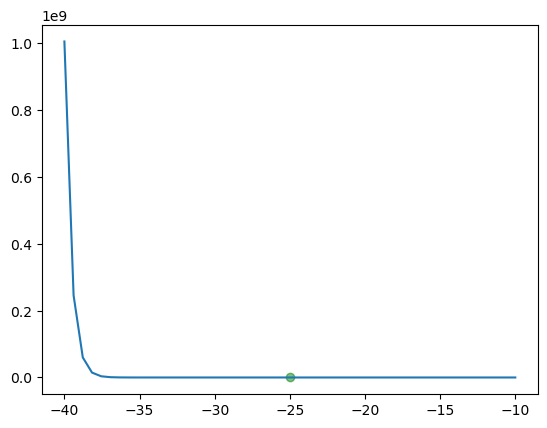

In [6]:
# for choosing a solving algorithm
from cluster_functions import funr
test_cluster=clusters[2]
x0=1e-5*u.GeV
p0s = np.linspace(-40, -10)
solns=[root(funr, x0, args=(test_cluster, [p, -4]), method='df-sane').x for p in p0s]
plt.plot(p0s, solns)
plt.scatter(-25,test_cluster.baryon_temp.value, color='green', alpha=0.5)
print(test_cluster.baryon_temp.value)

In [34]:
root(funr, x0, args=(test_cluster, [-40, -4]), method='df-sane').x

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


array(1.00434258e+09)

In [35]:
root(funr, x0, args=(test_cluster, [-10, -4]), method='df-sane').x

array(1.37804102e-05)

In [36]:
funr(1e9, test_cluster, [-40, -4], )

<Quantity -4.12525464e+09 GeV(1/2)>

In [40]:
funr(1e-11, test_cluster, [-40, -4], )

<Quantity -3.0928841e+09 GeV(1/2)>

In [8]:
Tbs=np.logspace(-20, 5)

Text(0, 0.5, 'f(Tb)')

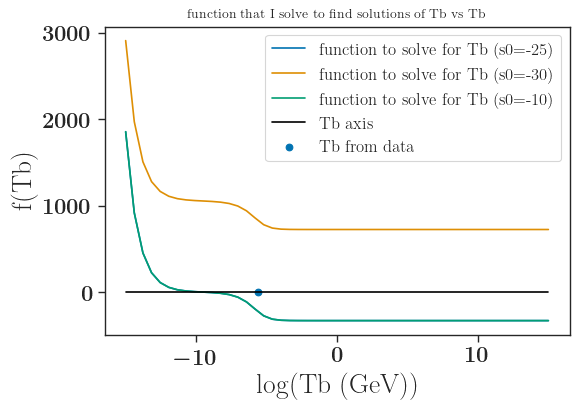

In [198]:
Tbs=np.linspace(-15, 15)
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-25, -4]), label='function to solve for Tb (s0=-25)')
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-31, -4]), label='function to solve for Tb (s0=-30)')
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-10, -4]), label='function to solve for Tb (s0=-10)')
plt.plot(Tbs, Tbs*0, label=("Tb axis"), c='k')
plt.scatter(np.log10(test_cluster.baryon_temp.value), 0, label='Tb from data')
#plt.ylim(-500, 500)
plt.title('function that I solve to find solutions of Tb vs Tb')
plt.legend()
plt.xlabel("log(Tb (GeV))")
plt.ylabel("f(Tb)")

Text(0, 0.5, 'f(Tb)')

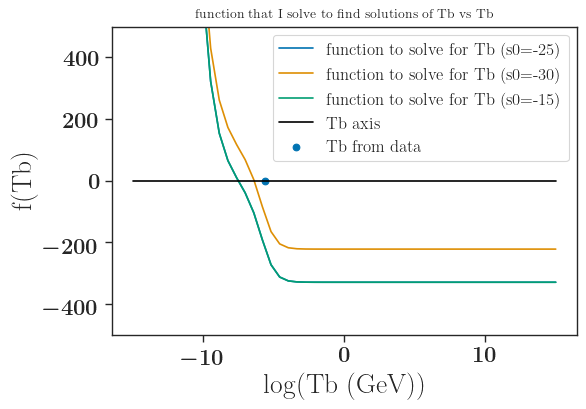

In [202]:
plt.title('function that I solve to find solutions of Tb vs Tb')
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-25, -2]), label='function to solve for Tb (s0=-25)')
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-30, -2]), label='function to solve for Tb (s0=-30)')
plt.plot(Tbs, funr_new(Tbs, test_cluster, [-15, -2]), label='function to solve for Tb (s0=-15)')
plt.plot(Tbs, Tbs*0, label=("Tb axis"), c='k')
plt.scatter(np.log10(test_cluster.baryon_temp.value), 0, label='Tb from data')
plt.ylim(-500, 500)
plt.legend()
plt.xlabel("log(Tb (GeV))")
plt.ylabel("f(Tb)")

In [208]:
from cluster_functions import c
from astropy import constants as const
def test_func(log_T_b, cluster, p0, f_chi=1, n=0):
    T_b = 10**log_T_b * u.GeV
    sigma0 = np.float128(10 ** p0[0]) * u.cm**2
    m_chi = 10 ** p0[1] * u.GeV

    m_b = cluster.m_b
    rho_chi=cluster.rho_dm*f_chi
    rho_b=cluster.rho_b

    pref=6.8*1e-42 *u.erg*u.cm**3
    n_b=cluster.n_e
    Z=1

    T_chi=cluster.virial_temperature(m_chi)

    frac1=((m_chi+m_b)**2/(3*rho_chi*m_b*sigma0*c(n))).to(u.m) #factors coming from cooling term
    #print(frac1)
    frac2=(pref*n_b*Z**2/const.h).to(1/u.s, equivalencies=u.temperature_energy()) #factors coming from heating term
    #print(frac2)
    T_terms=((T_chi / m_chi + T_b / m_b) ** (-1 / 2) * (T_chi-T_b)/(T_b**(1/2)*((1e8*u.K*const.k_B).to(u.GeV))**(1/2)))
    #print((frac1*frac2)/const.c)
    return T_terms, (frac1*frac2)/const.c

In [221]:
test_func(Tbs, test_cluster, [-25, -2])[1]

<Quantity 0.00107595>

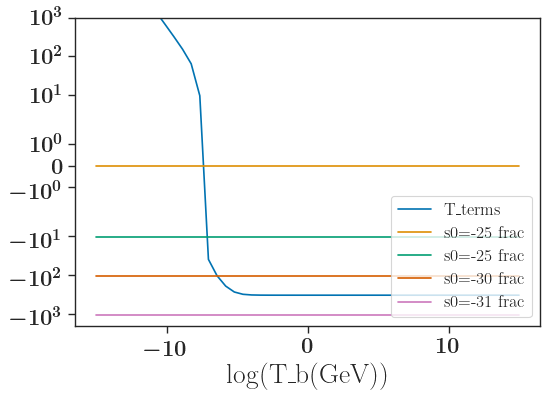

In [268]:

plt.plot(Tbs, test_func(Tbs, test_cluster, [-25, -2])[0], label='T_terms')

plt.plot(Tbs, -test_func(Tbs, test_cluster, [-25, -2])[1]*np.ones(Tbs.size), label='s0=-25 frac')
plt.plot(Tbs, -test_func(Tbs, test_cluster, [-29, -2])[1]*np.ones(Tbs.size), label='s0=-25 frac')
plt.plot(Tbs, -test_func(Tbs, test_cluster, [-30, -2])[1]*np.ones(Tbs.size), label='s0=-30 frac')
plt.plot(Tbs, -test_func(Tbs, test_cluster, [-31, -2])[1]*np.ones(Tbs.size), label='s0=-31 frac')
#plt.plot(Tbs, -test_func(Tbs, test_cluster, [-32, -2])[1]*np.ones(Tbs.size), label='s0=-32 frac')

plt.ylim(-2000, 1000)
plt.legend(loc='lower right')
plt.xlabel("log(T_b(GeV))")
plt.yscale('symlog')

Text(0.5, 0, 'log(T_b(GeV))')

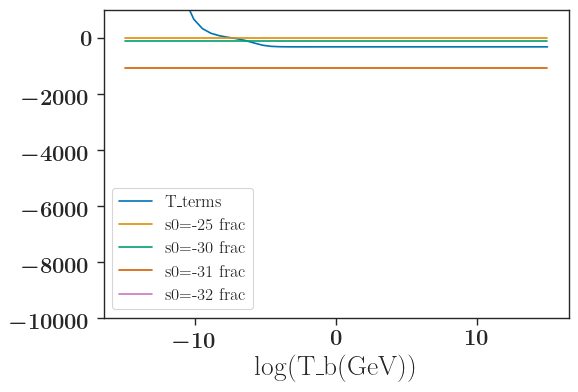

In [242]:

plt.plot(Tbs, test_func(Tbs, test_cluster, [-25, -2])[0], label='T_terms')

plt.plot(Tbs, -test_func(Tbs, test_cluster, [-25, -2])[1]*np.ones(Tbs.size), label='s0=-25 frac')
plt.plot(Tbs, -test_func(Tbs, test_cluster, [-30, -2])[1]*np.ones(Tbs.size), label='s0=-30 frac')
plt.plot(Tbs, -test_func(Tbs, test_cluster, [-31, -2])[1]*np.ones(Tbs.size), label='s0=-31 frac')
plt.plot(Tbs, -test_func(Tbs, test_cluster, [-32, -2])[1]*np.ones(Tbs.size), label='s0=-32 frac')

plt.ylim(-10000, 1000)
plt.legend()
plt.xlabel("log(T_b(GeV))")

2.394580869722816e-06


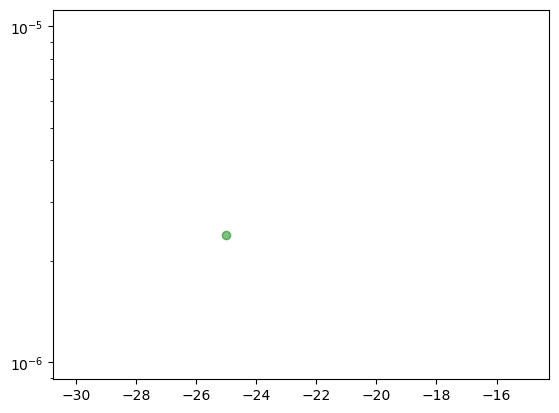

In [72]:
p0s = np.linspace(-30, -15)
solns=[root(funr_new, x0, args=(test_cluster, [p, -4]), method='df-sane').x for p in p0s]
plt.plot(p0s, solns)
plt.scatter(-25,test_cluster.baryon_temp.value, color='green', alpha=0.5)
plt.yscale('log')
print(test_cluster.baryon_temp.value)

In [74]:
from scipy.optimize import brentq
logT=brentq(funr_new, -10, 14, args=(test_cluster, [-25, -4]))
10**logT*u.GeV

<Quantity 2.96434263e-10 GeV>

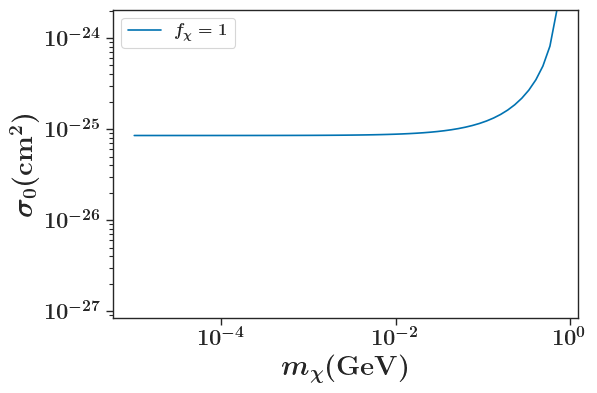

In [77]:
test_cluster.plot_sigma0_vs_m_chi()

2.394580869722816e-06 GeV


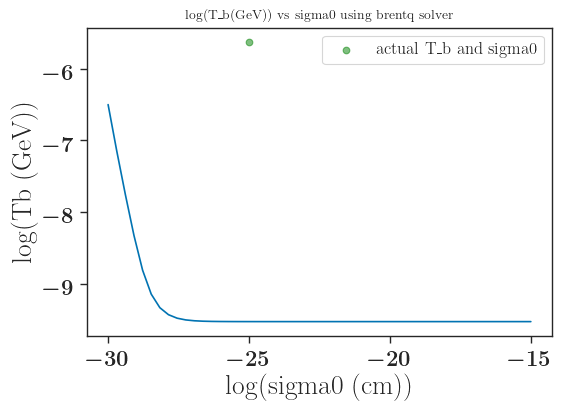

In [176]:
p0s = np.linspace(-30, -15)
solns_bq=[brentq(funr_new, -15, 15, args=(test_cluster, [p, -4])) for p in p0s]
plt.plot(p0s, solns)
plt.scatter(-25,np.log10(test_cluster.baryon_temp.value), color='green', alpha=0.5, label='actual T_b and sigma0')
plt.title("log(T_b(GeV)) vs sigma0 using brentq solver")
plt.legend()
plt.xlabel("log(sigma0 (cm))")
plt.ylabel("log(Tb (GeV))")
print(test_cluster.baryon_temp)

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/Desktop/krisp/thermo-idm/cluster_functions.py:77: RuntimeWarning: overflow encountered in power
  print(log_T_b)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/scipy/optimize/_spectral.py:142: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_k = np.vdot(s_k, s_k) / np.vdot(s_k, y_k)


2.394580869722816e-06


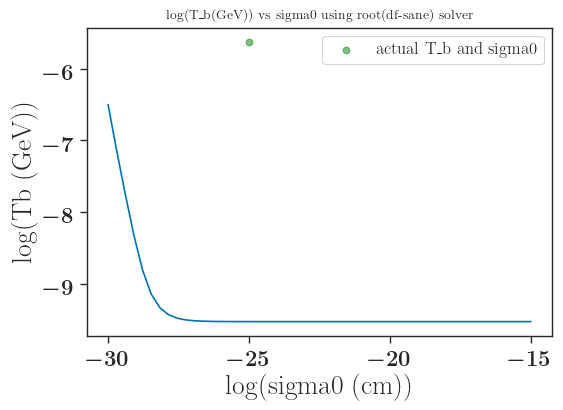

In [97]:
p0s = np.linspace(-30, -15)
solns=[root(funr_new, x0, args=(test_cluster, [p, -4]), method='df-sane').x for p in p0s]
plt.plot(p0s, solns)
plt.scatter(-25,np.log10(test_cluster.baryon_temp.value), color='green', alpha=0.5, label='actual T_b and sigma0')
plt.title("log(T_b(GeV)) vs sigma0 using root(df-sane) solver")
plt.legend()
plt.xlabel("log(sigma0 (cm))")
plt.ylabel("log(Tb (GeV))")
print(test_cluster.baryon_temp.value)

In [303]:
ndim, nwalkers = 1, 5
p0=np.zeros((nwalkers, ndim ))
log_sigma0 = np.random.uniform(low=-30, high=0, size=nwalkers).astype(np.float128)
p0[:,0]=log_sigma0
p0

array([[-14.82427506],
       [-15.75738608],
       [-16.2787286 ],
       [-14.84183701],
       [ -2.83188419]])

In [310]:
m_chi=-2
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[T_data, variances, clusters, 'pred_T_b_1', m_chi])

In [311]:
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

[-14.82427506] 12366.883505770316
[-15.75738608] 12366.883505770309
[-16.2787286] 12366.883505770295
[-14.84183701] 12366.883505770316
[-2.83188419] 12366.883505770316


  0%|                                                     | 0/100 [00:00<?, ?it/s]

[-25.58229054] 12366.842474943172
[-25.24068851] 12366.864820734332
[-14.73181947] 12366.883505770316
[-15.39178344] 12366.88350577031
[-0.08656283] 12366.883505770316


  2%|▉                                            | 2/100 [00:02<02:14,  1.37s/it]

[-17.27452071] 12366.883505770113
[-24.96380246] 12366.873629288966
[-27.89687882] 12358.311295040749
[-26.58760783] 12366.467913738115
[-25.21151782] 12366.866034580875
[-20.20224168] 12366.883505599297
[-16.7307073] 12366.883505770256
[-14.40988228] 12366.883505770316


  3%|█▎                                           | 3/100 [00:04<02:07,  1.31s/it]

[-28.06816149] 12354.089799982872


  4%|█▊                                           | 4/100 [00:05<02:02,  1.28s/it]

[-5.22802325] 12366.883505770316
[-21.67107443] 12366.883500736838
[-24.36178866] 12366.881036414325
[-17.1582694] 12366.883505770162
[-2.48409168] 12366.883505770316
[-2.21792059] 12366.883505770316


  5%|██▎                                          | 5/100 [00:06<01:49,  1.15s/it]

[-26.60591045] 12366.450013586282
[-15.24422468] 12366.883505770315


  6%|██▋                                          | 6/100 [00:07<02:00,  1.28s/it]

[-2.16383742] 12366.883505770316
[-11.98455259] 12366.883505770316
[-20.93372497] 12366.883504848767
[-13.1268635] 12366.883505770316
[-24.75257248] 12366.877433238085
[-15.31577866] 12366.883505770315
[-13.21456643] 12366.883505770316


  8%|███▌                                         | 8/100 [00:09<01:47,  1.16s/it]

[-13.06578337] 12366.883505770316
[-2.90918288] 12366.883505770316
[-18.86232254] 12366.883505762496
[-17.79359636] 12366.883505769647
[-18.68029563] 12366.883505765172
[-24.62164973] 12366.87901370497
[-13.87493682] 12366.883505770316


  9%|████                                         | 9/100 [00:11<01:47,  1.19s/it]

[-19.70129527] 12366.883505716352
[-12.98781589] 12366.883505770316
[-22.32983883] 12366.88348282826
[-26.3092249] 12366.664649780276


 11%|████▊                                       | 11/100 [00:13<01:56,  1.30s/it]

[-27.56355775] 12362.931048266408
[-19.87507606] 12366.8835056898
[-19.65766993] 12366.88350572151
[-29.42373037] 11937.71138677055
[-14.20568775] 12366.883505770316
[-29.64508486] 11452.249491739247


 12%|█████▎                                      | 12/100 [00:15<02:01,  1.38s/it]

[-17.4681476] 12366.883505769998
[-9.76419929] 12366.883505770316
[-25.6222953] 12366.838515607069
[-29.25293255] 12112.495528344398
[-28.23547178] 12347.912694668668
[-20.78843594] 12366.883505110793
[-26.60214693] 12366.453756283683
[-29.46590969] 11874.840008949552


 14%|██████▏                                     | 14/100 [00:18<01:59,  1.39s/it]

[-28.44901152] 12335.323919433375
[-29.31214554] 12063.484056182726
[-21.28423185] 12366.883503704814
[-28.71941525] 12305.75957683761
[-5.99837312] 12366.883505770316
[-16.43946535] 12366.883505770285
[-13.81754126] 12366.883505770316


 15%|██████▌                                     | 15/100 [00:18<01:38,  1.15s/it]

[-29.80935409] 10651.876999777163
[-28.28926134] 12345.334167577179
[-11.36979965] 12366.883505770316
[-29.32572646] 12050.743195959423
[-8.75337] 12366.883505770316


 18%|███████▉                                    | 18/100 [00:22<01:39,  1.21s/it]

[-29.78034036] 10838.595426415222
[-25.08050277] 12366.870584521106
[-10.51496986] 12366.883505770316
[-28.19071319] 12349.81601135762
[-8.11955034] 12366.883505770316
[-27.90930275] 12358.059331406033
[-14.35558236] 12366.883505770316
[-19.91203169] 12366.883505682648


 19%|████████▎                                   | 19/100 [00:24<01:38,  1.22s/it]

[-26.7591971] 12366.266363453626
[-12.69207142] 12366.883505770316
[-28.30865855] 12344.318149862967
[-19.01127293] 12366.883505759299
[-29.04709669] 12224.25320116419


 20%|████████▊                                   | 20/100 [00:25<01:45,  1.32s/it]

[-9.17164025] 12366.883505770316
[-18.06725505] 12366.883505769061
[-29.7879599] 10791.896069604516
[-27.85206005] 12359.161279087482
[-29.61634265] 11542.565362748797
[-14.52085869] 12366.883505770316
[-21.05994774] 12366.883504537944
[-29.85606447] 10294.552624334705


 21%|█████████▏                                  | 21/100 [00:26<01:41,  1.28s/it]

[-14.97060082] 12366.883505770315
[-19.13572659] 12366.88350575564


 23%|██████████                                  | 23/100 [00:28<01:26,  1.12s/it]

[-28.41951534] 12337.4822110775
[-13.17163332] 12366.883505770316
[-28.10438163] 12352.954634354852
[-18.02720587] 12366.883505769174
[-15.4189918] 12366.88350577031
[-29.63022721] 11500.300721911299


 24%|██████████▌                                 | 24/100 [00:29<01:22,  1.09s/it]

[-17.52519234] 12366.883505769954
[-29.90972131] 9777.439091662238
[-2.35265753] 12366.883505770316
[-22.57222917] 12366.883465681552
[-11.35915609] 12366.883505770316


 26%|███████████▍                                | 26/100 [00:31<01:18,  1.06s/it]

[-29.70453488] 11226.333160730492
[-2.55120143] 12366.883505770316
[-29.88353146] 10045.844767362774
[-2.47418562] 12366.883505770316
[-28.19972423] 12349.449211609466


 27%|███████████▉                                | 27/100 [00:32<01:07,  1.08it/s]

[-29.82250916] 10558.807390080437
[-29.1525777] 12176.155051735426


 29%|████████████▊                               | 29/100 [00:33<01:00,  1.17it/s]

[-24.60788077] 12366.879153889247
[-2.32719271] 12366.883505770316
[-29.67068088] 11362.008222036198
[-17.61409847] 12366.883505769876
[-10.66984075] 12366.883505770316


 30%|█████████████▏                              | 30/100 [00:34<00:54,  1.28it/s]

[-29.51047736] 11796.293343145626
[-28.75361846] 12300.301149822273


 32%|██████████████                              | 32/100 [00:36<01:05,  1.04it/s]

[-29.69200714] 11278.870699429139
[-15.25202317] 12366.883505770315
[-13.2582886] 12366.883505770316
[-29.49831871] 11819.098351076671
[-29.50605568] 11804.713545139493
[-16.39609861] 12366.88350577029


 33%|██████████████▌                             | 33/100 [00:36<00:51,  1.31it/s]

[-29.40592617] 11961.384572709876
[-20.29246262] 12366.883505559814


 34%|██████████████▉                             | 34/100 [00:38<00:59,  1.12it/s]

[-29.84269903] 10404.685130748849
[-11.77021722] 12366.883505770316
[-29.34062931] 12036.037339921191
[-13.9024096] 12366.883505770316
[-29.81242166] 10630.668147851111
[-24.58405225] 12366.879386233824


 35%|███████████████▍                            | 35/100 [00:39<01:04,  1.01it/s]

[-29.89203802] 9962.208278228702
[-29.86870167] 10184.023275438716
[-22.72066626] 12366.88344934685
[-29.38179637] 11991.067337446932


 36%|███████████████▊                            | 36/100 [00:40<01:14,  1.16s/it]

[-9.51205611] 12366.883505770316
[-29.59327579] 11607.580103132714
[-19.2577254] 12366.883505750882
[-11.20920817] 12366.883505770316
[-22.29263213] 12366.883484711903


 38%|████████████████▋                           | 38/100 [00:42<01:07,  1.09s/it]

[-29.85707924] 10285.91207569905
[-22.76382366] 12366.88344345179
[-7.20976763] 12366.883505770316
[-29.78360703] 10818.769820242469
[-28.60941654] 12320.307159442718
[-29.35578351] 12020.257090346195
[-22.99739898] 12366.883399063412


 39%|█████████████████▏                          | 39/100 [00:44<01:08,  1.13s/it]

[-21.99668102] 12366.883495117254
[-29.96854731] 9040.923120499765
[-26.90957423] 12366.010683547356
[-3.37554543] 12366.883505770316


 41%|██████████████████                          | 41/100 [00:46<01:09,  1.17s/it]

[-29.45705245] 11888.895058058924
[-0.72524388] 12366.883505770316
[-29.88772043] 10005.069786082473
[-21.15507347] 12366.883504236168
[-29.92622268] 9590.78536573915
[-29.55035524] 11713.264307272779
[-23.27070094] 12366.883305556272
[-29.83539702] 10462.070393975991
[-1.21532647] 12366.883505770316


 42%|██████████████████▍                         | 42/100 [00:48<01:13,  1.27s/it]

[-29.95356801] 9248.06270705261
[-24.09379778] 12366.882173500791


 44%|███████████████████▎                        | 44/100 [00:49<01:02,  1.11s/it]

[-29.82431495] 10545.592482038657
[-20.52015468] 12366.883505414728
[-1.890239] 12366.883505770316
[-29.93450795] 9491.520600761885
[-25.03651419] 12366.871829204536


 45%|███████████████████▊                        | 45/100 [00:50<00:47,  1.15it/s]

[-28.57963432] 12323.57912918799


 46%|████████████████████▏                       | 46/100 [00:51<00:56,  1.05s/it]

[-20.6358459] 12366.883505306185
[-13.58715606] 12366.883505770316
[-29.32167177] 12054.611313236448
[-23.43526586] 12366.883213315008
[-29.93850208] 9442.280476668986
[-14.27937589] 12366.883505770316


 47%|████████████████████▋                       | 47/100 [00:52<00:57,  1.09s/it]

[-29.27231338] 12097.542132348157
[-27.81838354] 12359.743455968075
[-25.67585028] 12366.832610628517
[-19.03332502] 12366.883505758726


 49%|█████████████████████▌                      | 49/100 [00:55<00:58,  1.15s/it]

[-29.95353266] 9248.534536242696
[-27.48486571] 12363.58924337256
[-8.80264658] 12366.883505770316
[-29.93873263] 9439.410169720175
[-29.78750783] 10794.711579480901
[-29.76368928] 10935.267159955625
[-17.62244173] 12366.883505769865


 50%|██████████████████████                      | 50/100 [00:56<00:53,  1.07s/it]

[-29.83349024] 10476.743193815819
[-18.94282787] 12366.883505760903
[-28.22139791] 12348.533545975166


 52%|██████████████████████▉                     | 52/100 [00:58<00:52,  1.09s/it]

[-29.62028585] 11530.811592158801
[-26.54559121] 12366.506258536197
[-29.91843001] 9680.717435356084
[-16.94150096] 12366.88350577022
[-24.25182847] 12366.881588765704
[-23.97236888] 12366.882498460678
[-28.35790204] 12341.510893038836
[-21.55799502] 12366.883501890701


 53%|███████████████████████▎                    | 53/100 [00:59<00:53,  1.13s/it]

[-29.98149158] 8849.85904906132
[-28.21937342] 12348.6211243193
[-17.12051439] 12366.883505770173


 56%|████████████████████████▋                   | 56/100 [01:02<00:48,  1.11s/it]

[-24.65171159] 12366.87869174763
[-29.97634327] 8927.238930736414
[-27.01319408] 12365.775107007395
[-29.93406014] 9496.984263485807
[-8.54327524] 12366.883505770316
[-27.87751326] 12358.689601864218
[-8.69276196] 12366.883505770316
[-29.9847818] 8799.421557471203


 57%|█████████████████████████                   | 57/100 [01:03<00:44,  1.04s/it]

[-29.79842452] 10725.09536720627
[-29.97945643] 8880.670466516536
[-12.26321003] 12366.883505770316
[-29.95490979] 9230.09368501936
[-29.97731459] 8912.782007637852
[-29.78137625] 10832.339939315645
[-2.28970653] 12366.883505770316


 58%|█████████████████████████▌                  | 58/100 [01:04<00:45,  1.08s/it]

[-29.7758388] 10865.444319289812
[-27.0659271] 12365.631747338928


 59%|█████████████████████████▉                  | 59/100 [01:06<00:50,  1.23s/it]

[-12.0362116] 12366.883505770316
[-25.89066653] 12366.80003903601
[-29.07731413] 12212.045729950634
[-29.84407819] 10393.629920187614
[-29.15188307] 12176.526912165387
[-20.41420338] 12366.883505491705


 61%|██████████████████████████▊                 | 61/100 [01:08<00:44,  1.15s/it]

[-29.96448828] 9098.493297707602
[-29.71678181] 11172.126033673896
[-13.35151455] 12366.883505770316
[-29.05321712] 12221.87079001767
[-29.77819995] 10851.429142043675
[-29.24518725] 12118.200956863666


 62%|███████████████████████████▎                | 62/100 [01:09<00:37,  1.01it/s]

[-29.40406139] 11963.774241933947
[-16.47398592] 12366.883505770282
[-29.27603955] 12094.551667807555
[-29.87126113] 10160.844381132767


 64%|████████████████████████████▏               | 64/100 [01:11<00:39,  1.09s/it]

[-29.88810527] 10001.284096887874
[-12.6862416] 12366.883505770316
[-29.96705482] 9062.218591679355
[-29.00435962] 12239.71665531361
[-29.23188165] 12127.660494887194
[-14.4263208] 12366.883505770316


 66%|█████████████████████████████               | 66/100 [01:13<00:37,  1.09s/it]

[-29.80193914] 10701.94374082742
[-29.9971405] 8602.88289118257
[-24.72355911] 12366.877825667385
[-29.95773673] 9191.8648611222
[-10.43002765] 12366.883505770316


 67%|█████████████████████████████▍              | 67/100 [01:14<00:34,  1.04s/it]

[-20.59880829] 12366.883505344127
[-29.77685293] 10859.442866737461
[-8.30733022] 12366.883505770316
[-19.37970826] 12366.883505744581
[-29.99430456] 8648.99164108162
[-25.45489303] 12366.852906851323
[-29.99483632] 8640.39231069744


 68%|█████████████████████████████▉              | 68/100 [01:15<00:34,  1.09s/it]

[-29.94129417] 9407.310467231968
[-29.99643446] 8614.419319650064
[-17.34938878] 12366.883505770076


 69%|██████████████████████████████▎             | 69/100 [01:17<00:37,  1.20s/it]

[-29.99187226] 8688.053640912767
[-29.59474882] 11603.611925198975
[-29.99262477] 8676.015921318094
[-27.8159276] 12359.784136213368
[-24.78477645] 12366.876965825311
[-29.9816621] 8847.26395699538
[-20.13185591] 12366.883505624886


 70%|██████████████████████████████▊             | 70/100 [01:18<00:38,  1.29s/it]

[-29.98667254] 8770.08433948608
[-27.79211836] 12360.166580098616
[-29.92451965] 9610.718842194876
[-22.09664795] 12366.883492359922


 72%|███████████████████████████████▋            | 72/100 [01:21<00:34,  1.24s/it]

[-27.07383178] 12365.60871211197
[-29.96504833] 9090.614739517863
[-29.49205823] 11830.422074094531
[-24.2546479] 12366.881576280019
[-29.96046757] 9154.45285675411
[-29.59914407] 11591.626662255772
[-26.13278567] 12366.737734330989


 74%|████████████████████████████████▌           | 74/100 [01:23<00:27,  1.07s/it]

[-29.99747782] 8597.357723527186
[-28.60822011] 12320.443513456212
[-26.83122777] 12366.154909052537
[-29.99545997] 8630.27981183455
[-29.96426285] 9101.658726632584
[-27.98123815] 12356.445576776763
[-29.4871224] 11839.156172506704


 75%|█████████████████████████████████           | 75/100 [01:24<00:27,  1.11s/it]

[-29.95807975] 9187.191659966451
[-29.25030939] 12114.444625159409
[-29.80977112] 10649.010942273417
[-27.63087302] 12362.263906383107


 77%|█████████████████████████████████▉          | 77/100 [01:26<00:24,  1.06s/it]

[-28.91975522] 12265.123012762344
[-29.46884867] 11870.069347193983
[-29.50496715] 11806.763964751091
[-29.96792012] 9049.890278926305
[-29.31111547] 12064.425742935187
[-28.92671837] 12263.259629071366
[-29.98184832] 8844.427739913357


 78%|██████████████████████████████████▎         | 78/100 [01:27<00:24,  1.10s/it]

[-29.74171491] 11052.348029255032
[-29.89348468] 9947.654525400487
[-29.97892313] 8888.69614384133


 79%|██████████████████████████████████▊         | 79/100 [01:28<00:23,  1.13s/it]

[-29.28379629] 12088.201933185563
[-29.99787709] 8590.806485188825
[-29.9085261] 9790.410715715225
[-29.36611125] 12008.997552632276
[-29.99501302] 8637.530111423577
[-29.96870053] 9038.728566199732


 80%|███████████████████████████████████▏        | 80/100 [01:30<00:24,  1.24s/it]

[-29.99033179] 8712.564321293352
[-28.97153432] 12250.325986682989
[-29.66173281] 11394.68293877241


 82%|████████████████████████████████████        | 82/100 [01:32<00:20,  1.15s/it]

[-29.99893478] 8573.392925962475
[-28.99173817] 12243.918161255617
[-29.98364102] 8816.997116945759
[-29.94710334] 9333.075833065132
[-29.99707629] 8603.933598170914
[-29.81011279] 10646.65879512878
[-29.94942337] 9302.861383063833
[-29.09973757] 12202.223801455544


 84%|████████████████████████████████████▉       | 84/100 [01:34<00:18,  1.16s/it]

[-29.99425531] 8649.786994269642
[-29.92809884] 9568.641674306928
[-29.97057365] 9011.771715014434
[-29.476189] 11857.914796729243
[-29.9999652] 8556.345257813677
[-29.98004353] 8871.812073035942
[-29.69222892] 11277.96524472522
[-29.9744694] 8954.944132104505


 85%|█████████████████████████████████████▍      | 85/100 [01:35<00:17,  1.17s/it]

[-29.99977536] 8559.492225811628
[-29.86353885] 10229.955937898378
[-29.96825859] 9045.054345510685


 86%|█████████████████████████████████████▊      | 86/100 [01:37<00:17,  1.26s/it]

[-29.99804609] 8588.029844959025
[-29.75188037] 10999.603348456312
[-29.99823377] 8584.94385146521
[-29.9541026] 9240.916956888324
[-29.99934547] 8566.608159813164
[-29.83437335] 10469.963470518047


 88%|██████████████████████████████████████▋     | 88/100 [01:39<00:15,  1.30s/it]

[-29.98504753] 8795.31402453937
[-29.99806956] 8587.644214062055
[-29.8550086] 10303.500595494384
[-29.99914848] 8569.864163468343
[-29.96565978] 9081.989622844188
[-29.86896924] 10181.612852378723
[-29.98778005] 8752.779044759296
[-29.98477915] 8799.462449892459


 89%|███████████████████████████████████████▏    | 89/100 [01:40<00:12,  1.17s/it]

[-29.98896217] 8734.208777926555
[-29.99686938] 8607.317437468835
[-29.89183651] 9964.227847611468
[-29.99911192] 8570.468063795497


 91%|████████████████████████████████████████    | 91/100 [01:42<00:09,  1.08s/it]

[-29.99650831] 8613.214390358651
[-29.9817694] 8845.630064391458
[-29.91467426] 9722.910561005798
[-29.99460035] 8644.210889831204
[-29.9900253] 8717.419965135783
[-29.92454338] 9610.442141377293
[-29.99983607] 8558.486221921334


 92%|████████████████████████████████████████▍   | 92/100 [01:44<00:09,  1.20s/it]

[-29.98856355] 8740.482338740565
[-29.99744592] 8597.880641128437
[-29.99102614] 8701.53828628203
[-29.89318975] 9950.629532135266
[-29.99293894] 8670.977784864317
[-29.99851962] 8580.238267162249


 93%|████████████████████████████████████████▉   | 93/100 [01:45<00:09,  1.29s/it]

[-29.99518474] 8634.746297970234
[-29.95080958] 9284.651448589659
[-29.99871709] 8576.983920972501
[-29.99058152] 8708.602832718389


 94%|█████████████████████████████████████████▎  | 94/100 [01:46<00:07,  1.25s/it]

[-29.99101428] 8701.72690760885
[-29.99424252] 8649.993531284825
[-29.95832536] 9183.841063890482
[-29.99919688] 8569.064418158718


 96%|██████████████████████████████████████████▏ | 96/100 [01:49<00:05,  1.29s/it]

[-29.99839043] 8582.36579188552
[-29.99489629] 8639.421272843792
[-29.9692704] 9030.552336401006
[-29.99861048] 8578.741248348568
[-29.99463395] 8643.667538544072
[-29.99993647] 8556.821740609015
[-29.9943165] 8648.798722154326
[-29.94907233] 9307.454123636013
[-29.99691888] 8606.5081267799


 97%|██████████████████████████████████████████▋ | 97/100 [01:50<00:03,  1.25s/it]

[-29.99543429] 8630.696880998657
[-29.95373135] 9245.881230975661
[-29.99802714] 8588.3413232582
[-29.99933997] 8566.69913305497


 99%|███████████████████████████████████████████▌| 99/100 [01:53<00:01,  1.20s/it]

[-29.99799211] 8588.917087213722
[-29.9989388] 8573.326643296492
[-29.97127004] 9001.689175797288
[-29.99222049] 8682.488314147482
[-29.9987519] 8576.409935133197


100%|███████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]

[-29.99339614] 8663.632505590627
[-29.96353615] 9111.840088722896
[-29.99833094] 8583.344945342526


In [312]:
sampler.run_mcmc(state, 1000, progress=True)

  0%|                                            | 1/1000 [00:01<20:51,  1.25s/it]

[-29.99556566] 8628.563249148501
[-29.98399762] 8811.513210869321
[-29.99951016] 8563.883717015606
[-29.998963] 8572.927210983415
[-29.99323449] 8666.231270941764
[-29.97311509] 8974.817114855025


  0%|                                            | 2/1000 [00:01<14:16,  1.17it/s]

[-29.99933662] 8566.754565996322
[-29.9944849] 8646.077634741283
[-29.97209609] 8989.686912839063
[-29.99983176] 8558.557552525128
[-29.99964205] 8561.700516572851


  0%|▏                                           | 4/1000 [00:04<20:57,  1.26s/it]

[-29.99972824] 8560.272975101709
[-29.99665986] 8610.740451486592
[-29.97435219] 8956.669130287815
[-29.99508351] 8636.387685656333
[-29.99944937] 8564.889647372649
[-29.9996964] 8560.800281200956
[-29.99912335] 8570.279334746887
[-29.98681866] 8767.806233872063


  0%|▏                                           | 5/1000 [00:05<18:40,  1.13s/it]

[-29.99950935] 8563.897113953497
[-29.99918255] 8569.301288721372
[-29.98651202] 8772.58507559745


  1%|▎                                           | 6/1000 [00:07<21:25,  1.29s/it]

[-29.999824] 8558.686254227603
[-29.99778826] 8592.265070459182


  1%|▎                                           | 7/1000 [00:08<22:10,  1.34s/it]

[-29.99964181] 8561.704341111761
[-29.99890198] 8573.934286045385
[-29.98520175] 8792.927804279325
[-29.99503772] 8637.129876764073
[-29.9992721] 8567.821194492934
[-29.98790535] 8750.815474877061


  1%|▎                                           | 8/1000 [00:09<18:09,  1.10s/it]

[-29.99985187] 8558.224283029793
[-29.97933867] 8882.44439720661


  1%|▍                                          | 10/1000 [00:11<18:05,  1.10s/it]

[-29.99435936] 8648.10635760668
[-29.99986827] 8557.952391781178
[-29.99960537] 8562.3077615661
[-29.99622795] 8617.786503684743
[-29.99251107] 8677.837450388963
[-29.9998606] 8558.079639867621
[-29.99906965] 8571.166279713607
[-29.99327376] 8665.60025324872
[-29.99978988] 8559.25165842463
[-29.99812737] 8586.693739462375


  1%|▍                                          | 11/1000 [00:12<19:51,  1.20s/it]

[-29.99989101] 8557.575442632111
[-29.99887249] 8574.42079054464
[-29.99867689] 8577.646640718582
[-29.99948878] 8564.237505453117
[-29.99588267] 8623.40896504514


  1%|▌                                          | 13/1000 [00:15<19:00,  1.16s/it]

[-29.99947856] 8564.406746403705
[-29.99889295] 8574.083215299928
[-29.99647736] 8613.719547741113
[-29.99955539] 8563.135140587288
[-29.99976754] 8559.6218738826
[-29.99905852] 8571.350110617048
[-29.99374543] 8658.010457569537


  1%|▌                                          | 14/1000 [00:16<19:00,  1.16s/it]

[-29.9997224] 8560.369586580915
[-29.99951455] 8563.811101937996
[-29.9960552] 8620.600754593837


  2%|▋                                          | 16/1000 [00:17<16:33,  1.01s/it]

[-29.99997399] 8556.199587421437
[-29.99903191] 8571.78945205643
[-29.99816471] 8586.079651472033
[-29.99986337] 8558.033691017921
[-29.99991672] 8557.149151303625
[-29.99978692] 8559.300633596213
[-29.99967633] 8561.132829463935
[-29.99790166] 8590.402937754154


  2%|▋                                          | 17/1000 [00:19<18:43,  1.14s/it]

[-29.99957655] 8562.784855615739


  2%|▊                                          | 18/1000 [00:20<18:52,  1.15s/it]

[-29.99996481] 8556.351815837117
[-29.99733797] 8599.649485911086
[-29.99956956] 8562.900580254998
[-29.99975628] 8559.80833488012
[-29.99962205] 8562.031628616336
[-29.99721312] 8601.694190940118
[-29.99976049] 8559.738667895965
[-29.99995925] 8556.443974416788


  2%|▊                                          | 20/1000 [00:23<20:02,  1.23s/it]

[-29.99988038] 8557.751767178837
[-29.99977526] 8559.493839451401
[-29.99883095] 8575.106238551296
[-29.99925108] 8568.168666077909
[-29.99997987] 8556.101988638165
[-29.99974811] 8559.943686010705
[-29.99956606] 8562.95852052646
[-29.9996012] 8562.376863599398
[-29.99802414] 8588.390622982335


  2%|▉                                          | 22/1000 [00:26<21:49,  1.34s/it]

[-29.99969984] 8560.74340614458
[-29.99996509] 8556.347154736744
[-29.99885528] 8574.704870172614
[-29.99970895] 8560.592399834062
[-29.99960508] 8562.312547268251
[-29.99995335] 8556.541853837087
[-29.99940358] 8565.647180417058


  2%|▉                                          | 23/1000 [00:27<20:54,  1.28s/it]

[-29.99999472] 8555.855701840013
[-29.99920057] 8569.00344476935
[-29.9999678] 8556.302118482805
[-29.9997223] 8560.371291959116
[-29.99959506] 8562.47843738696
[-29.99937874] 8566.058037539484


  2%|█                                          | 24/1000 [00:28<20:17,  1.25s/it]

[-29.99989405] 8557.524997976914
[-29.99967076] 8561.225027305272
[-29.99937893] 8566.054831393072
[-29.99907532] 8571.0726195292


  3%|█▏                                         | 27/1000 [00:32<20:43,  1.28s/it]

[-29.99963559] 8561.80740970248
[-29.99999997] 8555.768587714178
[-29.99935515] 8566.448114964425
[-29.9998081] 8558.94978533242
[-29.99969862] 8560.76363496152
[-29.99984215] 8558.385340394008
[-29.99942876] 8565.230617548781
[-29.99992209] 8557.060203903573
[-29.99985933] 8558.100716993737


  3%|█▏                                         | 28/1000 [00:33<21:30,  1.33s/it]

[-29.999924] 8557.028587283832
[-29.99975824] 8559.775874593262
[-29.99980768] 8558.95668943129
[-29.99981503] 8558.834881199817
[-29.99917384] 8569.445140148171
[-29.99999576] 8555.838488468518
[-29.99970984] 8560.57765514607
[-29.99987192] 8557.891898829084


  3%|█▏                                         | 29/1000 [00:35<22:10,  1.37s/it]

[-29.99990323] 8557.372817925814
[-29.99946432] 8564.64224936266
[-29.99999868] 8555.790079062506
[-29.99967231] 8561.199337317796
[-29.99982307] 8558.70158221493
[-29.99991651] 8557.152720004977
[-29.99916777] 8569.545477289


  3%|█▎                                         | 31/1000 [00:37<21:21,  1.32s/it]

[-29.99987327] 8557.869591051609
[-29.99985533] 8558.166913499424
[-29.99961261] 8562.187964135957
[-29.9991529] 8569.791176891356
[-29.99960271] 8562.351809163449
[-29.99932715] 8566.911127776853
[-29.99970486] 8560.660170235416


  3%|█▍                                         | 32/1000 [00:38<19:17,  1.20s/it]

[-29.99985458] 8558.179337913873
[-29.99960634] 8562.291737295722


  3%|█▍                                         | 33/1000 [00:39<19:06,  1.19s/it]

[-29.9998077] 8558.956311468879
[-29.99977468] 8559.503549278767
[-29.99979845] 8559.109627752254
[-29.99971939] 8560.419517627464
[-29.99984077] 8558.40827693955
[-29.99995898] 8556.448409898361


  3%|█▍                                         | 34/1000 [00:40<18:56,  1.18s/it]

[-29.9997577] 8559.784839246287
[-29.99979075] 8559.237262705443
[-29.99994827] 8556.62610736234
[-29.99971567] 8560.48109571358


  4%|█▌                                         | 36/1000 [00:43<20:06,  1.25s/it]

[-29.99955336] 8563.168846177645
[-29.99984909] 8558.270435030143
[-29.99960314] 8562.344709932044
[-29.99990264] 8557.382674652248
[-29.99989889] 8557.444870177722
[-29.99976391] 8559.681895763499
[-29.99988127] 8557.73701222711
[-29.99980453] 8559.008969490484
[-29.99959581] 8562.466060385153


  4%|█▌                                         | 37/1000 [00:44<19:38,  1.22s/it]

[-29.9999271] 8556.977086320027
[-29.99976083] 8559.733045707277
[-29.99967664] 8561.127686984917


  4%|█▋                                         | 38/1000 [00:46<20:40,  1.29s/it]

[-29.99971627] 8560.471160233259
[-29.99985407] 8558.187902385962
[-29.99970342] 8560.684067498742
[-29.99984329] 8558.366470537057
[-29.99978942] 8559.25926279034
[-29.99990328] 8557.372133021898
[-29.99967404] 8561.170632486936


  4%|█▋                                         | 39/1000 [00:47<21:23,  1.34s/it]

[-29.99982297] 8558.703258063626
[-29.99966394] 8561.338012544024
[-29.99968729] 8560.951299358534


  4%|█▋                                         | 40/1000 [00:48<20:30,  1.28s/it]

[-29.99973099] 8560.227309730411
[-29.99986618] 8557.987118693743
[-29.99972304] 8560.3590646482
[-29.99956139] 8563.035889308025
[-29.99970664] 8560.630651516998
[-29.99985573] 8558.160249722932


  4%|█▊                                         | 42/1000 [00:51<21:52,  1.37s/it]

[-29.99996873] 8556.286704450386
[-29.99993211] 8556.89403230768
[-29.99969571] 8560.811784066653
[-29.99967233] 8561.198940605142
[-29.99973987] 8560.080206839344
[-29.99996367] 8556.370755278107
[-29.99969628] 8560.802307995453
[-29.99977162] 8559.55418816431
[-29.99984849] 8558.280374796852


  4%|█▉                                         | 44/1000 [00:54<20:10,  1.27s/it]

[-29.999769] 8559.597666510854
[-29.9999753] 8556.177789052957
[-29.99948222] 8564.346093041011
[-29.99982211] 8558.717508340378
[-29.99996235] 8556.392510187494
[-29.9997793] 8559.426987114108
[-29.99958941] 8562.572009478277
[-29.99981611] 8558.817033523372


  5%|█▉                                         | 46/1000 [00:56<20:43,  1.30s/it]

[-29.99995007] 8556.596135276828
[-29.99974616] 8559.9760669023
[-29.99986179] 8558.059945153494
[-29.99997364] 8556.205255081992
[-29.9996278] 8561.936429681067
[-29.99995048] 8556.589344414391
[-29.99965882] 8561.422666048387


  5%|██                                         | 48/1000 [00:59<21:01,  1.33s/it]

[-29.99992937] 8556.939499165346
[-29.9999863] 8555.995286295776
[-29.9997066] 8560.631399449643
[-29.99968409] 8561.004154678521
[-29.99982577] 8558.656963749558
[-29.99997485] 8556.185304102073
[-29.99992785] 8556.964663807123


  5%|██                                         | 49/1000 [01:00<20:12,  1.28s/it]

[-29.9999688] 8556.28568109987
[-29.99956582] 8562.962467376523
[-29.99981912] 8558.76717618084
[-29.99999847] 8555.79343205428
[-29.9999496] 8556.604083492055
[-29.99935718] 8566.414588670154
[-29.99981048] 8558.910243378059
[-29.9999234] 8557.03849596527


  5%|██▏                                        | 50/1000 [01:01<19:38,  1.24s/it]

[-29.9999751] 8556.181052965101
[-29.99938478] 8565.958051244534
[-29.9998054] 8558.99444541315


  5%|██▏                                        | 51/1000 [01:03<20:37,  1.30s/it]

[-29.99995048] 8556.589395682862
[-29.99988184] 8557.727468937539
[-29.99995433] 8556.525557740946
[-29.99988852] 8557.616752532704
[-29.99973428] 8560.172796495432
[-29.99966911] 8561.252364906937


  5%|██▎                                        | 53/1000 [01:04<16:45,  1.06s/it]

[-29.99959756] 8562.437090520008
[-29.9996003] 8562.391802231483
[-29.99997499] 8556.183009892773
[-29.99986201] 8558.056250983387
[-29.99945458] 8564.80339662118
[-29.99989982] 8557.429465598296


  6%|██▎                                        | 55/1000 [01:07<17:43,  1.13s/it]

[-29.99996761] 8556.30537574714
[-29.99985626] 8558.151507974666
[-29.99963833] 8561.761997343943
[-29.99994075] 8556.75075821414
[-29.99988138] 8557.735193804929
[-29.99936067] 8566.356786094851
[-29.99991596] 8557.161753102211
[-29.99994452] 8556.688188025571


  6%|██▍                                        | 58/1000 [01:11<19:20,  1.23s/it]

[-29.99996056] 8556.422215453826
[-29.9996331] 8561.848565626718
[-29.99990566] 8557.332577286532
[-29.99987426] 8557.85308894794
[-29.99990738] 8557.304019534566
[-29.99979176] 8559.220465572758
[-29.99936403] 8566.30128915866
[-29.99990353] 8557.367935137006
[-29.99995109] 8556.579371446049


  6%|██▌                                        | 59/1000 [01:12<19:00,  1.21s/it]

[-29.99999847] 8555.793560645101
[-29.99986339] 8558.033393034199
[-29.99956511] 8562.974357624149
[-29.99981376] 8558.855880226349
[-29.99998718] 8555.980789245905


  6%|██▌                                        | 60/1000 [01:13<17:23,  1.11s/it]

[-29.99994449] 8556.688674698695
[-29.99940033] 8565.700795789315
[-29.99999789] 8555.803121057277
[-29.99998267] 8556.055604624218
[-29.99998552] 8556.008293673282
[-29.99978122] 8559.39511858764


  6%|██▋                                        | 62/1000 [01:15<17:46,  1.14s/it]

[-29.99994881] 8556.617177855487
[-29.99972425] 8560.338974145634
[-29.99998073] 8556.087770887478
[-29.9999854] 8556.010217437646
[-29.99998519] 8556.013750920847
[-29.99993971] 8556.767988622452
[-29.99995712] 8556.479312041221
[-29.99994804] 8556.6299426893
[-29.99977099] 8559.564675452546


  6%|██▋                                        | 63/1000 [01:17<19:25,  1.24s/it]

[-29.99999552] 8555.842512085892
[-29.99994647] 8556.655906438997
[-29.99982383] 8558.689015153795
[-29.99998537] 8556.010780784973


  6%|██▊                                        | 65/1000 [01:19<20:12,  1.30s/it]

[-29.99997433] 8556.19387900001
[-29.99969301] 8560.856422190764
[-29.99998168] 8556.071992428057
[-29.99999897] 8555.785192380497
[-29.99998639] 8555.993864713748
[-29.99997745] 8556.142218307452
[-29.99981129] 8558.89694499426
[-29.99997424] 8556.195323792972


  7%|██▊                                        | 66/1000 [01:20<18:13,  1.17s/it]

[-29.99997991] 8556.101273121696
[-29.99999478] 8555.854704100144


  7%|██▉                                        | 67/1000 [01:21<18:10,  1.17s/it]

[-29.99971896] 8560.426715901223
[-29.99997574] 8556.17052318676
[-29.99997909] 8556.114869967929
[-29.99998517] 8556.014028825379
[-29.99964049] 8561.72620512361


  7%|██▉                                        | 68/1000 [01:22<16:45,  1.08s/it]

[-29.99999887] 8555.786928594807
[-29.99999862] 8555.791047271694


  7%|██▉                                        | 69/1000 [01:23<17:30,  1.13s/it]

[-29.999656] 8561.469453780252
[-29.99997896] 8556.117115468694
[-29.99999909] 8555.783221447464
[-29.99996537] 8556.342513246194
[-29.99954404] 8563.322987982707
[-29.99998922] 8555.947007428887


  7%|███                                        | 71/1000 [01:26<17:50,  1.15s/it]

[-29.99999851] 8555.792843915593
[-29.99994526] 8556.676005528592
[-29.9997717] 8559.552919106412
[-29.99997954] 8556.107557726797
[-29.99996891] 8556.283812990436
[-29.99987969] 8557.763171390896
[-29.99997861] 8556.12285149013


  7%|███                                        | 72/1000 [01:27<16:34,  1.07s/it]

[-29.99999033] 8555.92849433378
[-29.99997914] 8556.114123267367


  7%|███▏                                       | 74/1000 [01:29<18:22,  1.19s/it]

[-29.99990392] 8557.361362485472
[-29.99999479] 8555.854579907731
[-29.99997536] 8556.176819870103
[-29.99995204] 8556.563592822837
[-29.99995468] 8556.519759886578
[-29.99997951] 8556.107959292905
[-29.99988178] 8557.728488207542


  8%|███▎                                       | 76/1000 [01:32<20:25,  1.33s/it]

[-29.99999743] 8555.810727611806
[-29.99998523] 8556.013070344683
[-29.99994633] 8556.658209257448
[-29.99997527] 8556.178254179418
[-29.99982093] 8558.737022096997
[-29.99999349] 8555.876178113602
[-29.99997977] 8556.1035910567
[-29.99991153] 8557.235191897831
[-29.99998836] 8555.961278327166
[-29.99995647] 8556.490034157689


  8%|███▎                                       | 77/1000 [01:33<19:39,  1.28s/it]

[-29.99998388] 8556.035425394582
[-29.99999745] 8555.810402437934
[-29.99999271] 8555.889023746946
[-29.99988827] 8557.620945528248
[-29.99999066] 8555.923101465401
[-29.99997834] 8556.12745829142
[-29.99998161] 8556.07311662028


  8%|███▎                                       | 78/1000 [01:35<19:17,  1.26s/it]

[-29.99990329] 8557.371919179343
[-29.99998544] 8556.00970024913
[-29.99998427] 8556.02909497492
[-29.99990483] 8557.34633612717
[-29.9999932] 8555.880901895489


  8%|███▍                                       | 80/1000 [01:37<17:18,  1.13s/it]

[-29.99995671] 8556.486139846444
[-29.99997342] 8556.208937390984
[-29.99991862] 8557.117724089445
[-29.99996172] 8556.402994703793
[-29.99998924] 8555.94662801913
[-29.99986299] 8558.0400268332


  8%|███▌                                       | 82/1000 [01:39<16:37,  1.09s/it]

[-29.99999381] 8555.87085192778
[-29.99995973] 8556.436058995034
[-29.99998905] 8555.949779473454
[-29.99990227] 8557.388812475994
[-29.99998735] 8555.97799684269
[-29.99997661] 8556.156067110727
[-29.99999591] 8555.835908350318
[-29.9998273] 8558.631514685969


  8%|███▌                                       | 84/1000 [01:41<17:10,  1.13s/it]

[-29.99999748] 8555.80999520072
[-29.99980042] 8559.076920852869
[-29.99999613] 8555.832240864373
[-29.99998486] 8556.019289209185
[-29.99999134] 8555.911764040236
[-29.99974003] 8560.077581929185
[-29.99999173] 8555.905218535388
[-29.99999469] 8555.856231565182
[-29.9999815] 8556.074892013168


  9%|███▋                                       | 86/1000 [01:44<18:26,  1.21s/it]

[-29.99997131] 8556.243914244224
[-29.99977886] 8559.434195614025
[-29.99999155] 8555.90835728729
[-29.99999735] 8555.812132915495
[-29.99999766] 8555.806874479085
[-29.99996765] 8556.304626630304
[-29.99980475] 8559.005298148717
[-29.99999335] 8555.878390637869
[-29.99999167] 8555.906372098214


  9%|███▊                                       | 88/1000 [01:46<19:01,  1.25s/it]

[-29.99999297] 8555.884806857666
[-29.99981705] 8558.801456001242
[-29.99998705] 8555.982988295189
[-29.99997713] 8556.147393004181
[-29.99999086] 8555.919783730662
[-29.99984661] 8558.31153162483
[-29.99999102] 8555.917057455195
[-29.99999993] 8555.76933189157


  9%|███▊                                       | 90/1000 [01:48<16:58,  1.12s/it]

[-29.99973303] 8560.19359529176
[-29.99998222] 8556.063076842158
[-29.99997941] 8556.109561088288
[-29.99999596] 8555.835183214354
[-29.99987571] 8557.829180029832
[-29.99998574] 8556.004571071931
[-29.99998778] 8555.970898587533
[-29.99993349] 8556.871206187849


  9%|███▉                                       | 91/1000 [01:50<18:34,  1.23s/it]

[-29.99999648] 8555.82653755927
[-29.99990315] 8557.374230367686
[-29.99996831] 8556.293802604698
[-29.99979634] 8559.144683376682


  9%|███▉                                       | 93/1000 [01:52<19:25,  1.28s/it]

[-29.99999276] 8555.888291255256
[-29.99997428] 8556.194778734618
[-29.9998311] 8558.56858714723
[-29.99977455] 8559.505723727349
[-29.99998141] 8556.076539024292
[-29.99999878] 8555.78842993588
[-29.99982656] 8558.643847331856
[-29.99978756] 8559.290027091576


  9%|████                                       | 94/1000 [01:54<20:10,  1.34s/it]

[-29.9999435] 8556.705166330126
[-29.99997276] 8556.219888395653
[-29.99989845] 8557.452169500406
[-29.99973743] 8560.120756251803
[-29.99999784] 8555.803877046128


 10%|████                                       | 95/1000 [01:55<18:04,  1.20s/it]

[-29.99985952] 8558.097463716935
[-29.99961056] 8562.221889475646


 10%|████▏                                      | 96/1000 [01:56<17:55,  1.19s/it]

[-29.99999947] 8555.776942319915
[-29.99991303] 8557.210455963641
[-29.99999992] 8555.769485074114
[-29.99991926] 8557.107170230494
[-29.99980718] 8558.964984278493
[-29.99959585] 8562.465327458305
[-29.99999588] 8555.83646148315


 10%|████▏                                      | 98/1000 [01:58<16:08,  1.07s/it]

[-29.99969867] 8560.762668645444
[-29.99985463] 8558.178569753305
[-29.99981417] 8558.849109089635
[-29.99957091] 8562.878290628783
[-29.99997923] 8556.112564595378
[-29.99992227] 8557.057224005433


 10%|████▏                                     | 100/1000 [02:00<16:49,  1.12s/it]

[-29.99985834] 8558.117124247412
[-29.99998444] 8556.026224827932
[-29.99990928] 8557.272565654435
[-29.99970222] 8560.703888073811
[-29.99992943] 8556.938470814515
[-29.99990285] 8557.37911289544
[-29.99960747] 8562.273035499431
[-29.99994554] 8556.671373506377


 10%|████▎                                     | 102/1000 [02:02<15:48,  1.06s/it]

[-29.99977705] 8559.46427856047
[-29.99994137] 8556.740510517135
[-29.9999325] 8556.887617289096
[-29.99993736] 8556.807058255186
[-29.99986574] 8557.9943988323
[-29.99970095] 8560.724941181767


 10%|████▍                                     | 105/1000 [02:06<16:14,  1.09s/it]

[-29.99994964] 8556.60337603469
[-29.99993313] 8556.877077437923
[-29.99999154] 8555.908499706153
[-29.99957365] 8562.832923715334
[-29.99989225] 8557.554905531068
[-29.99998991] 8555.93543153249
[-29.99998818] 8555.964127411044
[-29.99952029] 8563.716045323794


 11%|████▍                                     | 106/1000 [02:06<13:58,  1.07it/s]

[-29.99996577] 8556.33587826894
[-29.99961304] 8562.180831914671
[-29.9999984] 8555.794743163153
[-29.99994954] 8556.604925401454
[-29.99968172] 8561.04347282926
[-29.99995883] 8556.4510069726
[-29.9999923] 8555.89576662153


 11%|████▍                                     | 107/1000 [02:08<16:16,  1.09s/it]

[-29.99999269] 8555.889323647594
[-29.99993872] 8556.784368585064
[-29.99971366] 8560.514446990413
[-29.99996985] 8556.268127891391
[-29.99999245] 8555.89336084828


 11%|████▌                                     | 109/1000 [02:10<18:59,  1.28s/it]

[-29.99997157] 8556.239678604294
[-29.99993691] 8556.814425942775
[-29.99999242] 8555.893830037101
[-29.99999259] 8555.891108450865
[-29.99950977] 8563.89016487237
[-29.99992091] 8557.07980167706
[-29.99960925] 8562.243500076827


 11%|████▌                                     | 110/1000 [02:11<15:52,  1.07s/it]

[-29.99998938] 8555.944195772685
[-29.99968483] 8560.99195110275
[-29.99998691] 8555.98525584717


 11%|████▋                                     | 111/1000 [02:13<17:35,  1.19s/it]

[-29.99990559] 8557.333722421521
[-29.99988913] 8557.606658366827
[-29.99999666] 8555.823475441091
[-29.99963918] 8561.7480484907
[-29.99989988] 8557.428425193251
[-29.99989344] 8557.535219751962


 11%|████▋                                     | 113/1000 [02:15<17:30,  1.18s/it]

[-29.99994936] 8556.608031606433
[-29.99988978] 8557.59585428256
[-29.99990444] 8557.352790738003
[-29.99934933] 8566.544302039085
[-29.9999513] 8556.575834034522
[-29.9998935] 8557.534120795874
[-29.99943808] 8565.076414925317
[-29.9998977] 8557.464545357245
[-29.99997607] 8556.165062541917


 12%|████▊                                     | 116/1000 [02:18<17:13,  1.17s/it]

[-29.9998022] 8559.047473095063
[-29.99985794] 8558.123667100015
[-29.99966641] 8561.29704007177
[-29.99993956] 8556.770487243766
[-29.99987371] 8557.862302517868
[-29.9996727] 8561.192810294322
[-29.99990973] 8557.265091727073


 12%|████▉                                     | 117/1000 [02:20<17:16,  1.17s/it]

[-29.99993022] 8556.925374885257
[-29.99993133] 8556.906986684786
[-29.99976095] 8559.731071520207
[-29.99984511] 8558.336305877123
[-29.99986983] 8557.926544403475
[-29.99995907] 8556.446965915135


 12%|████▉                                     | 118/1000 [02:21<17:12,  1.17s/it]

[-29.99995285] 8556.550193895548
[-29.999749] 8559.92905551166
[-29.99989131] 8557.570495006072
[-29.99958811] 8562.593504988097
[-29.99995923] 8556.444325871524
[-29.9999473] 8556.642215109336
[-29.99992983] 8556.93190350695


 12%|████▉                                     | 119/1000 [02:22<18:34,  1.27s/it]

[-29.99989015] 8557.589762914919
[-29.99980388] 8559.019737186542
[-29.99995999] 8556.431735834258
[-29.99994355] 8556.704419388374
[-29.99992268] 8557.05036981892


 12%|█████                                     | 121/1000 [02:25<19:58,  1.36s/it]

[-29.99986147] 8558.06510479424
[-29.9998369] 8558.472503094385
[-29.99995234] 8556.558508184504
[-29.99998216] 8556.064074444268
[-29.99994221] 8556.726524350328
[-29.99992433] 8557.023121113929
[-29.99986443] 8558.016048146772
[-29.99995938] 8556.441827341487
[-29.99997678] 8556.153303717754
[-29.99983753] 8558.461940904874


 12%|█████                                     | 122/1000 [02:27<20:19,  1.39s/it]

[-29.99991269] 8557.21605734317
[-29.99983428] 8558.515856213206
[-29.9998889] 8557.610378838572


 12%|█████▏                                    | 123/1000 [02:28<19:18,  1.32s/it]

[-29.99990646] 8557.319350758979
[-29.99990412] 8557.358115486426
[-29.99979395] 8559.184188634597
[-29.99987999] 8557.758097552613
[-29.99989914] 8557.440712336662
[-29.99994166] 8556.735598722946


 12%|█████▏                                    | 124/1000 [02:29<19:50,  1.36s/it]

[-29.99992626] 8556.990984547374
[-29.99985774] 8558.12695696116
[-29.99997327] 8556.211479053443
[-29.99986088] 8558.074941875364
[-29.99986775] 8557.9611428318


 13%|█████▎                                    | 126/1000 [02:32<20:36,  1.41s/it]

[-29.9999588] 8556.451401966233
[-29.99988527] 8557.670708387608
[-29.99992062] 8557.084554425612
[-29.9998025] 8559.04253068611
[-29.99981764] 8558.791672401694
[-29.99984155] 8558.39530704149
[-29.99994864] 8556.619926011786
[-29.99990682] 8557.313370523407
[-29.99978552] 8559.323878251895
[-29.99999604] 8555.833834535466


 13%|█████▎                                    | 127/1000 [02:34<21:21,  1.47s/it]

[-29.99996015] 8556.429111130628
[-29.99973688] 8560.129824723988
[-29.99989906] 8557.442013091217
[-29.99994478] 8556.683986920403


 13%|█████▍                                    | 130/1000 [02:37<18:03,  1.25s/it]

[-29.99992825] 8556.958029964078
[-29.99963563] 8561.80670370772
[-29.99996389] 8556.3670906437
[-29.99985488] 8558.174347819104
[-29.99998175] 8556.070856162532
[-29.99985247] 8558.21439535541
[-29.99989991] 8557.42800669792
[-29.99983416] 8558.517863121335


 13%|█████▌                                    | 131/1000 [02:38<16:23,  1.13s/it]

[-29.99983005] 8558.585885837754
[-29.99994773] 8556.635050118479
[-29.99984206] 8558.386867639576
[-29.99982905] 8558.602606365783
[-29.9999484] 8556.623887093365
[-29.99997597] 8556.166657174086
[-29.99975163] 8559.88539381439
[-29.99999274] 8555.888505863648


 13%|█████▌                                    | 132/1000 [02:40<17:46,  1.23s/it]

[-29.99973949] 8560.086622117107
[-29.99996283] 8556.384603534656
[-29.99970447] 8560.666593322947
[-29.99997943] 8556.109245436319


 13%|█████▋                                    | 134/1000 [02:42<16:21,  1.13s/it]

[-29.99960196] 8562.364323439573
[-29.99961665] 8562.120963050167
[-29.99999122] 8555.913742207496
[-29.99965043] 8561.561657752512


 14%|█████▋                                    | 136/1000 [02:44<15:25,  1.07s/it]

[-29.9999823] 8556.061733225426
[-29.9992445] 8568.277384082035
[-29.99996849] 8556.290760879738
[-29.9995466] 8563.280729145
[-29.99968645] 8560.965181509304
[-29.99997362] 8556.20574258826


 14%|█████▊                                    | 138/1000 [02:47<18:18,  1.27s/it]

[-29.99996874] 8556.286578646252
[-29.99944005] 8565.043829711598
[-29.99998119] 8556.080047326002
[-29.99956769] 8562.931494206145
[-29.99998203] 8556.0662337609
[-29.99953414] 8563.486927869842
[-29.99996752] 8556.306849980416
[-29.99998101] 8556.083028895247
[-29.99905108] 8571.472938578618
[-29.99998404] 8556.032804739865


 14%|█████▊                                    | 139/1000 [02:48<17:49,  1.24s/it]

[-29.99967992] 8561.073252803477
[-29.99995303] 8556.547078838257
[-29.99836397] 8582.801289770348
[-29.99990197] 8557.393769497026
[-29.99997424] 8556.195443942475


 14%|█████▉                                    | 140/1000 [02:49<17:32,  1.22s/it]

[-29.99991861] 8557.117902644086
[-29.99976708] 8559.629530178554
[-29.99922128] 8568.661189343606
[-29.99982069] 8558.74108066899
[-29.99941152] 8565.515701172057
[-29.99998327] 8556.045550686362
[-29.999913] 8557.210965518589


 14%|█████▉                                    | 142/1000 [02:51<15:49,  1.11s/it]

[-29.99974403] 8560.011266092126
[-29.99975891] 8559.764770056443
[-29.99897333] 8572.756627168928
[-29.9998578] 8558.12605555676
[-29.9999749] 8556.184480819875
[-29.99985659] 8558.146114887943
[-29.9993723] 8566.16448919454
[-29.99999164] 8555.906811932768


 14%|██████                                    | 144/1000 [02:54<18:21,  1.29s/it]

[-29.99997351] 8556.207535455238
[-29.99903311] 8571.769725181748
[-29.99981891] 8558.770627666094
[-29.99989493] 8557.510531428168
[-29.99996967] 8556.271233220177
[-29.9998832] 8557.704937235641
[-29.99959679] 8562.449768169436
[-29.99979931] 8559.095418708997
[-29.99981313] 8558.866433170224


 14%|██████                                    | 145/1000 [02:55<17:49,  1.25s/it]

[-29.99981081] 8558.904783470216
[-29.99986452] 8558.01454221074
[-29.99990065] 8557.415682244524
[-29.99962063] 8562.055179234218
[-29.99995928] 8556.443432252103


 15%|██████▏                                   | 147/1000 [02:58<18:01,  1.27s/it]

[-29.99988975] 8557.596399516133
[-29.99937182] 8566.172447852361
[-29.99993144] 8556.90509110269
[-29.99987952] 8557.766007820393
[-29.99971171] 8560.546773098795
[-29.9999282] 8556.958796651028
[-29.99973079] 8560.230630750852
[-29.9999047] 8557.348518667757


 15%|██████▏                                   | 148/1000 [02:59<18:46,  1.32s/it]

[-29.99934672] 8566.587431818618
[-29.99991158] 8557.234514105885
[-29.99941745] 8565.417710296617
[-29.99991068] 8557.249309193978
[-29.99994096] 8556.747294656447


 15%|██████▎                                   | 150/1000 [03:02<18:57,  1.34s/it]

[-29.99987651] 8557.815792683641
[-29.99943101] 8565.193440573465
[-29.99993486] 8556.848433348881
[-29.99990376] 8557.364115594506
[-29.99993534] 8556.84051204232
[-29.99988474] 8557.679376725915
[-29.99919061] 8569.168007740715
[-29.99993316] 8556.87661757764
[-29.9998532] 8558.202206845794
[-29.99993441] 8556.855953420833


 15%|██████▍                                   | 152/1000 [03:04<17:22,  1.23s/it]

[-29.99993936] 8556.773825991102
[-29.99989896] 8557.443596961812
[-29.99957081] 8562.879946529258
[-29.99991524] 8557.173771598771
[-29.99999793] 8555.80248989669
[-29.99983393] 8558.521594913665
[-29.99940831] 8565.56886898443


 15%|██████▍                                   | 153/1000 [03:05<17:05,  1.21s/it]

[-29.99996917] 8556.27948585412
[-29.99990027] 8557.421922044961
[-29.99954425] 8563.319550891734
[-29.99999662] 8555.824116689353


 16%|██████▌                                   | 155/1000 [03:07<15:27,  1.10s/it]

[-29.9999414] 8556.739935423559
[-29.99929414] 8567.456809067511
[-29.99987672] 8557.812382877451
[-29.99995714] 8556.479031915786
[-29.99986703] 8557.973083785202
[-29.99997242] 8556.225540133768
[-29.99947085] 8564.534186236617


 16%|██████▌                                   | 156/1000 [03:09<16:56,  1.20s/it]

[-29.99989865] 8557.448741258651
[-29.9998309] 8558.571892476859
[-29.9998623] 8558.051458546304
[-29.99999019] 8555.930916872885
[-29.99962787] 8561.935308838223
[-29.99995236] 8556.558248973442


 16%|██████▌                                   | 157/1000 [03:10<17:58,  1.28s/it]

[-29.9998244] 8558.6796669043
[-29.99992519] 8557.008835236496
[-29.99978609] 8559.314456724273
[-29.9999868] 8555.987074496903
[-29.99995552] 8556.505765841033


 16%|██████▋                                   | 159/1000 [03:13<19:14,  1.37s/it]

[-29.9998794] 8557.768018618248
[-29.99986342] 8558.032884935827
[-29.99995773] 8556.469131593358
[-29.99983178] 8558.557330620797
[-29.99999902] 8555.784344005431
[-29.99989391] 8557.527318846127
[-29.99989455] 8557.516834440503
[-29.99996112] 8556.413026819782
[-29.9997335] 8560.185755422013


 16%|██████▋                                   | 160/1000 [03:14<18:20,  1.31s/it]

[-29.99989794] 8557.460657146183
[-29.99997842] 8556.126124100267
[-29.999983] 8556.050081107645
[-29.99963032] 8561.894726488943
[-29.9999368] 8556.816336615071


 16%|██████▊                                   | 162/1000 [03:17<19:24,  1.39s/it]

[-29.99985118] 8558.235712558579
[-29.99995995] 8556.432371988045
[-29.99989449] 8557.517819557574
[-29.99975849] 8559.771711637952
[-29.99993504] 8556.845459493448


 16%|██████▊                                   | 163/1000 [03:19<18:37,  1.33s/it]

[-29.99970698] 8560.625139003367
[-29.99999385] 8555.87011245264
[-29.99974979] 8559.915941236122
[-29.99991585] 8557.163706793312
[-29.99988068] 8557.74673816426
[-29.99999247] 8555.892960705954
[-29.99963525] 8561.813109328707
[-29.9999436] 8556.70350878868


 16%|██████▉                                   | 164/1000 [03:20<17:56,  1.29s/it]

[-29.99980387] 8559.01974666169
[-29.99990947] 8557.26935261002
[-29.99991071] 8557.24891544331
[-29.9996231] 8562.01421315816


 17%|██████▉                                   | 166/1000 [03:22<17:02,  1.23s/it]

[-29.99956177] 8563.029530085882
[-29.99991152] 8557.235473985646
[-29.99976394] 8559.681437855064
[-29.99998765] 8555.973050983584
[-29.99961062] 8562.22087167131
[-29.9999436] 8556.703564861209
[-29.99954504] 8563.306460085163
[-29.99998938] 8555.944322179153


 17%|███████                                   | 168/1000 [03:25<18:02,  1.30s/it]

[-29.99927207] 8567.821775203733
[-29.99979719] 8559.130557843819
[-29.9999168] 8557.14786244425
[-29.99946705] 8564.597164751116
[-29.99998861] 8555.956981151661


 17%|███████                                   | 169/1000 [03:26<18:48,  1.36s/it]

[-29.99983299] 8558.537178257771
[-29.99982142] 8558.729053289851
[-29.99994558] 8556.67066978535
[-29.99956926] 8562.905663492367
[-29.99962095] 8562.049860126483
[-29.9995519] 8563.192869253278
[-29.99948199] 8564.349876389659


 17%|███████▏                                  | 170/1000 [03:27<15:34,  1.13s/it]

[-29.99956104] 8563.041696956907
[-29.99998858] 8555.957524695445
[-29.9999037] 8557.365118335929


 17%|███████▏                                  | 171/1000 [03:28<15:48,  1.14s/it]

[-29.99955604] 8563.124332208428
[-29.9995596] 8563.065443070745
[-29.9999797] 8556.104748148296
[-29.99994757] 8556.63769762154
[-29.99968545] 8560.981686178722
[-29.99993189] 8556.897682622426


 17%|███████▎                                  | 173/1000 [03:31<16:48,  1.22s/it]

[-29.99976402] 8559.680203858983
[-29.99984714] 8558.302715124737
[-29.99955743] 8563.101438233078
[-29.99998024] 8556.09581391498
[-29.99930456] 8567.284583574365
[-29.9997661] 8559.645726078741
[-29.99998395] 8556.034422756371
[-29.9997769] 8559.46681183404


 17%|███████▎                                  | 174/1000 [03:32<16:33,  1.20s/it]

[-29.99953985] 8563.392386353207
[-29.99990886] 8557.279492093541
[-29.99994329] 8556.708567145663
[-29.99966319] 8561.350442364555


 18%|███████▎                                  | 175/1000 [03:33<17:37,  1.28s/it]

[-29.99998679] 8555.987281802953
[-29.99960651] 8562.288912294895
[-29.99992547] 8557.004196607664
[-29.99978486] 8559.334809997235
[-29.99945555] 8564.787451536258


 18%|███████▍                                  | 176/1000 [03:35<17:34,  1.28s/it]

[-29.99971408] 8560.507473579783
[-29.99960798] 8562.26461473114
[-29.99991071] 8557.248824732535


 18%|███████▍                                  | 178/1000 [03:37<17:11,  1.26s/it]

[-29.99979913] 8559.098410707858
[-29.99937368] 8566.141602629477
[-29.99997779] 8556.13649104454
[-29.99996742] 8556.308486872129
[-29.99992288] 8557.047148764024
[-29.99955591] 8563.126498379064
[-29.99997447] 8556.191625540912
[-29.99999109] 8555.915996078607
[-29.99977207] 8559.54676217766
[-29.99992175] 8557.06582816807


 18%|███████▌                                  | 179/1000 [03:38<18:01,  1.32s/it]

[-29.99954135] 8563.367592433096
[-29.99989228] 8557.554403495415
[-29.9996664] 8561.29722007971
[-29.99996068] 8556.420229357635


 18%|███████▌                                  | 181/1000 [03:41<16:57,  1.24s/it]

[-29.99952602] 8563.621327044384
[-29.99999553] 8555.842260501699
[-29.99977828] 8559.443817223746
[-29.999897] 8557.476238976178
[-29.99977078] 8559.568172727362
[-29.99977592] 8559.482925507446
[-29.99958956] 8562.569491157377


 18%|███████▋                                  | 182/1000 [03:42<15:29,  1.14s/it]

[-29.99966178] 8561.373737181633
[-29.999865] 8558.00663161633
[-29.99932906] 8566.879501836238
[-29.99994768] 8556.63576868779


 18%|███████▋                                  | 184/1000 [03:44<16:49,  1.24s/it]

[-29.99924805] 8568.218785082088
[-29.999898] 8557.459635194891
[-29.99990281] 8557.379875521141
[-29.99983631] 8558.48223378836
[-29.99980776] 8558.955445540578
[-29.99960957] 8562.238297273838
[-29.99994039] 8556.756707944685
[-29.99990866] 8557.282851185384


 18%|███████▊                                  | 185/1000 [03:45<16:31,  1.22s/it]

[-29.99987342] 8557.867093994455
[-29.99987204] 8557.890023383801
[-29.99929196] 8567.49293862269
[-29.99990726] 8557.306072419733
[-29.99980152] 8559.058824055151
[-29.99991948] 8557.103516532121


 19%|███████▊                                  | 187/1000 [03:48<18:11,  1.34s/it]

[-29.99990995] 8557.26151328056
[-29.99992572] 8556.999995836348
[-29.99991959] 8557.101711903617
[-29.99963786] 8561.769828167631
[-29.99991536] 8557.171710842023
[-29.9997424] 8560.038339896126
[-29.99991852] 8557.119381167462
[-29.99991658] 8557.151517583798
[-29.99983809] 8558.452641786704
[-29.99992208] 8557.060303760483


 19%|███████▉                                  | 189/1000 [03:51<19:02,  1.41s/it]

[-29.99967528] 8561.150130687281
[-29.99996878] 8556.285947623119
[-29.99989857] 8557.450188910507
[-29.99989666] 8557.481828626449
[-29.99988338] 8557.701993377905
[-29.99990806] 8557.292797839475
[-29.99978514] 8559.330170110616
[-29.99986515] 8558.004103733661


 19%|███████▉                                  | 190/1000 [03:53<19:21,  1.43s/it]

[-29.99997363] 8556.205560368131
[-29.9998844] 8557.684998500383
[-29.99985616] 8558.153172308022
[-29.99985986] 8558.091792690087
[-29.99988835] 8557.619526183533
[-29.99979951] 8559.092034440559
[-29.9999353] 8556.841187034692


 19%|████████                                  | 192/1000 [03:56<19:30,  1.45s/it]

[-29.99979203] 8559.216015899658
[-29.99994203] 8556.729571853655
[-29.99983464] 8558.50985298303
[-29.99987663] 8557.81388065566
[-29.99992846] 8556.95457080116
[-29.99974075] 8560.06563933537
[-29.99998293] 8556.051182644249
[-29.99974873] 8559.93344961086
[-29.99983651] 8558.478909041494
[-29.99993437] 8556.85660624051


 19%|████████▏                                 | 194/1000 [03:59<19:32,  1.46s/it]

[-29.99983799] 8558.454437014223
[-29.99991386] 8557.196675060568
[-29.99983826] 8558.449862217856
[-29.99984636] 8558.315567883983
[-29.99983535] 8558.498134586278
[-29.99985265] 8558.211287051467
[-29.99991772] 8557.132674856473
[-29.9998927] 8557.547455553859
[-29.99986345] 8558.032352967017
[-29.99970684] 8560.627388469


 20%|████████▏                                 | 195/1000 [04:00<19:32,  1.46s/it]

[-29.99984644] 8558.314366370172
[-29.99987641] 8557.817451224813
[-29.99986682] 8557.976402859831
[-29.99984223] 8558.384009123456


 20%|████████▎                                 | 197/1000 [04:02<17:30,  1.31s/it]

[-29.99990623] 8557.323164228086
[-29.99984171] 8558.392631001165
[-29.99988356] 8557.698943189995
[-29.99985922] 8558.102452178844
[-29.99989498] 8557.509638410047
[-29.99985705] 8558.13841921853
[-29.99971279] 8560.528871937422
[-29.9999774] 8556.142985373886
[-29.99990422] 8557.356411534562


 20%|████████▎                                 | 198/1000 [04:04<18:11,  1.36s/it]

[-29.99989665] 8557.481999920537
[-29.99986989] 8557.925610398941
[-29.99991906] 8557.110462031453
[-29.99985121] 8558.235205874631
[-29.99992923] 8556.941853561704


 20%|████████▎                                 | 199/1000 [04:05<18:40,  1.40s/it]

[-29.9998862] 8557.655179951053
[-29.9998702] 8557.92046817602
[-29.9999207] 8557.08327725783
[-29.9998352] 8558.500653916726
[-29.99994415] 8556.694367446536


 20%|████████▍                                 | 201/1000 [04:08<19:05,  1.43s/it]

[-29.99991278] 8557.214524742889
[-29.99980611] 8558.98269352764
[-29.9999081] 8557.292131674061
[-29.99983236] 8558.547697401233
[-29.99991401] 8557.194218499244
[-29.99995355] 8556.538525595517
[-29.99989776] 8557.463571980477
[-29.99991971] 8557.099663507697
[-29.99990316] 8557.374013942526
[-29.99981607] 8558.817630866537


 20%|████████▍                                 | 202/1000 [04:10<19:10,  1.44s/it]

[-29.99992557] 8557.002474221941
[-29.99978606] 8559.314887686556
[-29.99992773] 8556.966701358439
[-29.99992582] 8556.998344716272


 20%|████████▌                                 | 203/1000 [04:11<19:13,  1.45s/it]

[-29.99985806] 8558.121690091666
[-29.99997118] 8556.246137553298
[-29.99986735] 8557.96769427799
[-29.99999274] 8555.888541783055
[-29.99986394] 8558.024284982996
[-29.99980744] 8558.960697235221


 20%|████████▌                                 | 204/1000 [04:13<19:13,  1.45s/it]

[-29.99986313] 8558.037630594587
[-29.99964751] 8561.609970358153
[-29.99980724] 8558.964057428127


 21%|████████▋                                 | 207/1000 [04:16<16:55,  1.28s/it]

[-29.99980525] 8558.996970843413
[-29.99952441] 8563.647884821867
[-29.9999935] 8555.875984480012
[-29.99996662] 8556.321737377419
[-29.99976017] 8559.743883216675
[-29.99991368] 8557.199677868986
[-29.99967718] 8561.118630872721
[-29.99987008] 8557.922424217631
[-29.99984994] 8558.256352451861


 21%|████████▋                                 | 208/1000 [04:17<16:26,  1.25s/it]

[-29.9998798] 8557.761295658114
[-29.99958426] 8562.657233011521
[-29.99997453] 8556.190606910342
[-29.99973462] 8560.167300369945


 21%|████████▊                                 | 209/1000 [04:19<17:20,  1.32s/it]

[-29.99991285] 8557.21336048726
[-29.99945618] 8564.776925701775
[-29.99994456] 8556.687565774326
[-29.99993015] 8556.926541123245
[-29.99979834] 8559.111540924318
[-29.99993206] 8556.894928802256
[-29.99982906] 8558.602299594393
[-29.99960436] 8562.324516211009
[-29.99980988] 8558.920292204435


 21%|████████▊                                 | 210/1000 [04:20<16:44,  1.27s/it]

[-29.99987371] 8557.862223176597
[-29.99996313] 8556.37955473137
[-29.99955488] 8563.143548099084
[-29.99972084] 8560.395463164932
[-29.99998438] 8556.027285714368


 21%|████████▉                                 | 212/1000 [04:22<15:45,  1.20s/it]

[-29.99974288] 8560.030402441196
[-29.9997853] 8559.327630332084
[-29.99932058] 8567.01979185255
[-29.99984093] 8558.405638924913
[-29.99993823] 8556.792476666084
[-29.99967937] 8561.082383254728
[-29.99989205] 8557.55824442795


 21%|████████▉                                 | 213/1000 [04:24<15:35,  1.19s/it]

[-29.99991077] 8557.247950429999
[-29.99987712] 8557.805808285657
[-29.99967611] 8561.136324751382


 22%|█████████                                 | 215/1000 [04:26<15:45,  1.20s/it]

[-29.99995412] 8556.529064631619
[-29.9999282] 8556.958933125326
[-29.99988841] 8557.618500752376
[-29.99988023] 8557.754225526458
[-29.99981038] 8558.911909639008
[-29.99987574] 8557.828700073997
[-29.99992374] 8557.0328664191
[-29.99991248] 8557.219526322191
[-29.99971036] 8560.569075279802
[-29.99989393] 8557.526988222233


 22%|█████████                                 | 216/1000 [04:27<16:45,  1.28s/it]

[-29.99997861] 8556.122865813093
[-29.99982114] 8558.733611901502
[-29.99990972] 8557.265316775003
[-29.99972622] 8560.306454313137


 22%|█████████▏                                | 218/1000 [04:30<15:56,  1.22s/it]

[-29.99990236] 8557.387319366168
[-29.99975796] 8559.780607734014
[-29.99986762] 8557.963255787983
[-29.999976] 8556.16625785937
[-29.99986853] 8557.948062801162
[-29.99997731] 8556.144508549427
[-29.99972328] 8560.355147586179


 22%|█████████▏                                | 219/1000 [04:31<16:50,  1.29s/it]

[-29.9998735] 8557.86579672712
[-29.99995121] 8556.577325849767
[-29.99985481] 8558.175551146174
[-29.99995809] 8556.46329205227
[-29.9998577] 8558.127668254365
[-29.99997364] 8556.205378965764


 22%|█████████▎                                | 221/1000 [04:34<16:02,  1.24s/it]

[-29.999824] 8558.68616802922
[-29.99999223] 8555.897039774622
[-29.99981416] 8558.849350810133
[-29.99996617] 8556.329236111527
[-29.99987826] 8557.786853217845
[-29.99989038] 8557.585863750233
[-29.99997515] 8556.180301662187
[-29.99996805] 8556.298070210843


 22%|█████████▎                                | 222/1000 [04:35<15:50,  1.22s/it]

[-29.99988193] 8557.72595907438
[-29.99995733] 8556.47574468663


 22%|█████████▎                                | 223/1000 [04:36<16:45,  1.29s/it]

[-29.99996195] 8556.399175963323
[-29.99999975] 8555.77224913704
[-29.99989224] 8557.55511500438
[-29.99983582] 8558.49029750895
[-29.99999207] 8555.899734745193
[-29.99996613] 8556.329826746305
[-29.99987936] 8557.768633543827


 22%|█████████▍                                | 225/1000 [04:38<14:52,  1.15s/it]

[-29.99993563] 8556.835685029535
[-29.99987827] 8557.78670869517
[-29.99984836] 8558.282541842227
[-29.99993612] 8556.827495920155


 23%|█████████▍                                | 226/1000 [04:39<13:55,  1.08s/it]

[-29.99984573] 8558.326142680515
[-29.99986609] 8557.988572282584
[-29.99987559] 8557.831109116236
[-29.99988479] 8557.678586633645
[-29.99997975] 8556.104079411458
[-29.99999122] 8555.913683552955


 23%|█████████▌                                | 228/1000 [04:42<15:38,  1.22s/it]

[-29.99996789] 8556.30072693516
[-29.99988547] 8557.667367442644
[-29.99998376] 8556.03743274198
[-29.99988994] 8557.593158377917
[-29.99999869] 8555.789834512736
[-29.99993271] 8556.88403148036
[-29.99997351] 8556.20749893865
[-29.99992002] 8557.094540244003
[-29.9999629] 8556.383435153695


 23%|█████████▋                                | 230/1000 [04:44<16:28,  1.28s/it]

[-29.99998668] 8555.988986756027
[-29.99991777] 8557.131790710073
[-29.99995256] 8556.554897004153
[-29.99993061] 8556.918881281257
[-29.99997949] 8556.10823413597
[-29.99995618] 8556.494928928085
[-29.99991305] 8557.210101954859
[-29.9999276] 8556.968763291716


 23%|█████████▋                                | 231/1000 [04:45<14:53,  1.16s/it]

[-29.99999251] 8555.892361082497
[-29.99992034] 8557.089136178263
[-29.99996546] 8556.340978347322
[-29.99993853] 8556.787509806662
[-29.99997034] 8556.260068162806


 23%|█████████▊                                | 233/1000 [04:48<16:53,  1.32s/it]

[-29.99997809] 8556.131573752162
[-29.99991273] 8557.215410192846
[-29.99998179] 8556.070192733325
[-29.99995463] 8556.520545479156
[-29.99996409] 8556.363653102078
[-29.99997373] 8556.203830189837
[-29.99999424] 8555.863658406028
[-29.99994469] 8556.685397671843
[-29.99987921] 8557.771043023928


 23%|█████████▊                                | 234/1000 [04:49<16:19,  1.28s/it]

[-29.99996225] 8556.394196668414
[-29.99983534] 8558.498282479943
[-29.99999069] 8555.922579104401


 24%|█████████▊                                | 235/1000 [04:51<17:00,  1.33s/it]

[-29.99992763] 8556.968384628035
[-29.9999951] 8555.849373181305
[-29.99980534] 8558.995502317783
[-29.99994334] 8556.707749237452


 24%|█████████▉                                | 237/1000 [04:52<13:19,  1.05s/it]

[-29.99991822] 8557.12435889731
[-29.99996669] 8556.320614066246
[-29.99968684] 8560.958682909059
[-29.99997339] 8556.209438527747
[-29.99980656] 8558.975200954765


 24%|█████████▉                                | 238/1000 [04:53<12:41,  1.00it/s]

[-29.99998303] 8556.04951593821
[-29.99997652] 8556.157504951905
[-29.99978714] 8559.297038458231


 24%|██████████                                | 239/1000 [04:55<14:43,  1.16s/it]

[-29.9999939] 8555.86934880692
[-29.99995613] 8556.495691260423
[-29.99999557] 8555.841627250258
[-29.99995559] 8556.504611963845
[-29.99999188] 8555.90287366352
[-29.99996784] 8556.301505456904
[-29.99981039] 8558.911728004272


 24%|██████████                                | 240/1000 [04:56<14:47,  1.17s/it]

[-29.99994511] 8556.678395974657
[-29.99993982] 8556.766251702269
[-29.99966107] 8561.38552810805
[-29.99999432] 8555.862305081671


 24%|██████████▏                               | 242/1000 [04:59<16:01,  1.27s/it]

[-29.99997801] 8556.132930266978
[-29.99942609] 8565.274840300028
[-29.99997963] 8556.10596752783
[-29.99992315] 8557.042675446432
[-29.99991299] 8557.211032460527
[-29.99993476] 8556.850053280434
[-29.99997681] 8556.152809455762


 24%|██████████▏                               | 243/1000 [05:00<16:47,  1.33s/it]

[-29.99952646] 8563.6139642488
[-29.9999237] 8557.033549848607
[-29.99997848] 8556.125052667832
[-29.99990443] 8557.352944273542
[-29.9998106] 8558.908377299398
[-29.99997946] 8556.108797213728
[-29.9999347] 8556.85101135615


 24%|██████████▎                               | 245/1000 [05:03<16:53,  1.34s/it]

[-29.99995093] 8556.581987385709
[-29.99985143] 8558.231658785955
[-29.99978781] 8559.285995981678
[-29.99997964] 8556.105842937348
[-29.99999772] 8555.805913969842
[-29.99993249] 8556.887707553029
[-29.99987269] 8557.879102907957
[-29.99995526] 8556.510208137632
[-29.99977185] 8559.550462862786


 25%|██████████▎                               | 246/1000 [05:04<16:17,  1.30s/it]

[-29.99983118] 8558.567202769214
[-29.99999346] 8555.87665524047
[-29.99994867] 8556.619417549187


 25%|██████████▎                               | 247/1000 [05:06<16:55,  1.35s/it]

[-29.99993828] 8556.791754144551
[-29.99985733] 8558.133790884025
[-29.999839] 8558.437591450183
[-29.99985642] 8558.14884100734
[-29.99994526] 8556.675930520323
[-29.99989783] 8557.462491602339


 25%|██████████▍                               | 249/1000 [05:08<14:39,  1.17s/it]

[-29.99985947] 8558.098290083084
[-29.99971111] 8560.556645737504
[-29.99978011] 8559.413538230618
[-29.9999019] 8557.394983661647
[-29.99970948] 8560.583670544956
[-29.99971266] 8560.531032212295


 25%|██████████▌                               | 250/1000 [05:08<13:32,  1.08s/it]

[-29.99977054] 8559.572064819813
[-29.99993569] 8556.834622424576
[-29.9998696] 8557.930445852222
[-29.99970188] 8560.709531003191


 25%|██████████▌                               | 252/1000 [05:11<15:13,  1.22s/it]

[-29.9998301] 8558.585144664217
[-29.99984492] 8558.339486077366
[-29.99988721] 8557.638501538162
[-29.99998927] 8555.9460588505
[-29.99981312] 8558.866457134009
[-29.99986222] 8558.052741373922
[-29.99994709] 8556.6456589176
[-29.99982324] 8558.698849412758
[-29.99966479] 8561.323855122924


 25%|██████████▋                               | 253/1000 [05:12<14:59,  1.20s/it]

[-29.99981029] 8558.913401254373
[-29.99997346] 8556.208318252355
[-29.99988306] 8557.707191948854
[-29.99985565] 8558.16167924019


 26%|██████████▋                               | 255/1000 [05:15<15:52,  1.28s/it]

[-29.99987159] 8557.897475567497
[-29.99998311] 8556.048224322814
[-29.99984162] 8558.39411274571
[-29.99986425] 8558.019113234703
[-29.99999595] 8555.835300921899
[-29.99986261] 8558.046215964065
[-29.99997656] 8556.156880290499
[-29.99981691] 8558.803712621462
[-29.99986695] 8557.974334613233


 26%|██████████▊                               | 257/1000 [05:17<15:07,  1.22s/it]

[-29.99973187] 8560.212711863756
[-29.99998471] 8556.021760358364
[-29.99988818] 8557.622392500898
[-29.9999041] 8557.358418483542


 26%|██████████▊                               | 258/1000 [05:18<13:50,  1.12s/it]

[-29.99987931] 8557.769422595857
[-29.99987735] 8557.801977429284
[-29.99986286] 8558.042086597923
[-29.99990493] 8557.344724170884
[-29.99987947] 8557.766796177864
[-29.99996367] 8556.3707441652
[-29.99986309] 8558.03824337474
[-29.99998918] 8555.947602075044


 26%|██████████▉                               | 260/1000 [05:20<13:50,  1.12s/it]

[-29.99989038] 8557.585948851403
[-29.99977533] 8559.492832765314
[-29.99983905] 8558.436800488817
[-29.99990875] 8557.28128925363
[-29.99988614] 8557.656144730105
[-29.99998691] 8555.985312774972
[-29.99986017] 8558.086703087993


 26%|██████████▉                               | 261/1000 [05:22<14:00,  1.14s/it]

[-29.99988632] 8557.653182453483
[-29.99999279] 8555.887796878867
[-29.99990214] 8557.390931936465
[-29.99985165] 8558.227948905007


 26%|███████████                               | 263/1000 [05:24<14:09,  1.15s/it]

[-29.99995229] 8556.559451793026
[-29.99994353] 8556.704665010388
[-29.99983743] 8558.463670480854
[-29.99980716] 8558.965331430005
[-29.9999811] 8556.081686693213


 26%|███████████                               | 264/1000 [05:25<15:19,  1.25s/it]

[-29.99984041] 8558.414229365695
[-29.99990236] 8557.387324044254
[-29.99971631] 8560.4704894941
[-29.99999696] 8555.818548393121
[-29.99994561] 8556.670231390088
[-29.99983076] 8558.574174896696
[-29.9999353] 8556.841095883914
[-29.99976172] 8559.71830161543


 26%|███████████▏                              | 265/1000 [05:27<15:05,  1.23s/it]

[-29.99990559] 8557.333801261275
[-29.99988852] 8557.61672167626
[-29.99970407] 8560.673351311514
[-29.99994875] 8556.618087133847


 27%|███████████▎                              | 268/1000 [05:30<15:40,  1.28s/it]

[-29.99970185] 8560.709998743792
[-29.99996531] 8556.34345308112
[-29.99994457] 8556.68734724479
[-29.9998437] 8558.359729908985
[-29.99988823] 8557.621520078015
[-29.99963105] 8561.882667506168
[-29.99997149] 8556.241050400691
[-29.99992796] 8556.962875170626
[-29.99990529] 8557.338699919723


 27%|███████████▎                              | 269/1000 [05:32<15:13,  1.25s/it]

[-29.99990129] 8557.405021330947
[-29.99996493] 8556.34974327468
[-29.99992534] 8557.006361748476
[-29.99965727] 8561.44839707516
[-29.99993951] 8556.771408925437
[-29.99994779] 8556.634037832198
[-29.99959577] 8562.466750009391
[-29.99990243] 8557.386197656515
[-29.9999817] 8556.07168082951


 27%|███████████▎                              | 270/1000 [05:33<15:58,  1.31s/it]

[-29.99995435] 8556.525195706003
[-29.9999824] 8556.059970763465
[-29.99941973] 8565.380024942126
[-29.99983417] 8558.517633675985
[-29.99998143] 8556.076207657117


 27%|███████████▍                              | 271/1000 [05:35<16:31,  1.36s/it]

[-29.99994576] 8556.66772824591
[-29.99934311] 8566.647129332048
[-29.99997165] 8556.238268938454


 27%|███████████▍                              | 272/1000 [05:36<16:55,  1.39s/it]

[-29.99996299] 8556.382015481766
[-29.99992367] 8557.034019589719
[-29.99995659] 8556.488058870513
[-29.99991841] 8557.121159277734
[-29.99927846] 8567.71600968021
[-29.99997982] 8556.102901056187


 27%|███████████▍                              | 273/1000 [05:37<16:07,  1.33s/it]

[-29.99991939] 8557.10501015163
[-29.99995103] 8556.580299483265
[-29.99975578] 8559.816596801462
[-29.99987416] 8557.854742475713
[-29.99987893] 8557.775674224922


 28%|███████████▌                              | 275/1000 [05:40<14:47,  1.22s/it]

[-29.99990972] 8557.26523807822
[-29.99994761] 8556.63693560226
[-29.99984739] 8558.298542347331
[-29.99987586] 8557.826567144997
[-29.99990495] 8557.344438696275
[-29.99994973] 8556.601875501545
[-29.99987441] 8557.850709559638


 28%|███████████▌                              | 276/1000 [05:41<14:35,  1.21s/it]

[-29.99991886] 8557.113800478195
[-29.99987438] 8557.851107643075
[-29.99996864] 8556.288331656835


 28%|███████████▋                              | 277/1000 [05:42<15:40,  1.30s/it]

[-29.99981879] 8558.772574225515
[-29.99992413] 8557.026426350689
[-29.99978205] 8559.38137329947
[-29.99991226] 8557.223222315353
[-29.99991453] 8557.185473764648
[-29.99990244] 8557.385963047032


 28%|███████████▋                              | 279/1000 [05:45<14:52,  1.24s/it]

[-29.99982718] 8558.633581615455
[-29.99990894] 8557.278261736668
[-29.99995521] 8556.510948824014
[-29.9998724] 8557.883967759297
[-29.99986942] 8557.933312866038
[-29.99987574] 8557.828690186236
[-29.99997147] 8556.241330666171
[-29.9998579] 8558.124362053375
[-29.99995707] 8556.480142996388


 28%|███████████▊                              | 281/1000 [05:48<16:13,  1.35s/it]

[-29.99980138] 8559.061154315783
[-29.99987425] 8557.853269349418
[-29.99998508] 8556.01555750824
[-29.99985576] 8558.159884946817
[-29.99994749] 8556.639080429492
[-29.99990934] 8557.271592776038
[-29.9998683] 8557.951926823669
[-29.99996746] 8556.307832521701
[-29.9998982] 8557.45629475685
[-29.99982509] 8558.6680967956


 28%|███████████▉                              | 283/1000 [05:50<16:51,  1.41s/it]

[-29.99988938] 8557.602437544274
[-29.99980506] 8559.000100680843
[-29.99993888] 8556.78185172328
[-29.99991819] 8557.124812582888
[-29.99987109] 8557.905763256167
[-29.9999821] 8556.064977360653
[-29.999858] 8558.122734591758
[-29.99994495] 8556.681162532259
[-29.99985479] 8558.175959256916
[-29.99982999] 8558.586937059588


 28%|███████████▉                              | 284/1000 [05:52<16:59,  1.42s/it]

[-29.99984828] 8558.283763181558


 28%|███████████▉                              | 285/1000 [05:53<16:01,  1.34s/it]

[-29.99985634] 8558.1501367874
[-29.99993895] 8556.780598914103
[-29.99983348] 8558.529183570434
[-29.99985146] 8558.231150309011
[-29.99981937] 8558.76289175437
[-29.99974499] 8559.995426444315


 29%|████████████                              | 286/1000 [05:54<14:18,  1.20s/it]

[-29.99985199] 8558.222288435163
[-29.99996439] 8556.358698742804


 29%|████████████                              | 287/1000 [05:55<14:10,  1.19s/it]

[-29.99983516] 8558.501239475198
[-29.99988446] 8557.684112359544
[-29.99984353] 8558.362466188008
[-29.99996286] 8556.384057323232
[-29.99989075] 8557.57976380715
[-29.99985725] 8558.135181559917
[-29.99997951] 8556.108012438306


 29%|████████████                              | 288/1000 [05:57<15:04,  1.27s/it]

[-29.99983765] 8558.459918675337
[-29.99990097] 8557.410329659488
[-29.99993546] 8556.83854274149
[-29.99979223] 8559.21264226478


 29%|████████████▏                             | 289/1000 [05:58<15:49,  1.34s/it]

[-29.99995407] 8556.529900475874
[-29.99986192] 8558.057659291746
[-29.99999081] 8555.92061302189
[-29.9999545] 8556.522743235892
[-29.99978446] 8559.341500112449
[-29.99987768] 8557.796495210161


 29%|████████████▏                             | 291/1000 [06:01<15:29,  1.31s/it]

[-29.99986735] 8557.967739458025
[-29.99988266] 8557.71389239597
[-29.99983519] 8558.500688996935
[-29.99991712] 8557.142627123498
[-29.99989016] 8557.589560769478
[-29.99992015] 8557.092285495994
[-29.99999976] 8555.772086680048
[-29.99974845] 8559.938070228847
[-29.99991716] 8557.141915235048


 29%|████████████▎                             | 292/1000 [06:02<15:58,  1.35s/it]

[-29.99989773] 8557.464085806161
[-29.99992516] 8557.009265643079
[-29.99997066] 8556.25483806263
[-29.99989298] 8557.542850058273
[-29.9999881] 8555.965439191312


 29%|████████████▎                             | 294/1000 [06:05<16:30,  1.40s/it]

[-29.99988906] 8557.607880865098
[-29.99994613] 8556.661605211304
[-29.99997874] 8556.120745279797
[-29.9998937] 8557.530856560392
[-29.99994397] 8556.69730012629
[-29.99992302] 8557.04468718531
[-29.99992915] 8556.943117136536
[-29.99991752] 8557.13595854371
[-29.99994532] 8556.675018782302
[-29.99997543] 8556.17559557674


 30%|████████████▍                             | 295/1000 [06:07<16:39,  1.42s/it]

[-29.99994099] 8556.746738365873
[-29.9999621] 8556.396764765479
[-29.99995436] 8556.525004385328
[-29.99992918] 8556.942619636491
[-29.99991352] 8557.202219870656


 30%|████████████▍                             | 297/1000 [06:09<16:49,  1.44s/it]

[-29.99993072] 8556.917053590842
[-29.99998313] 8556.047868971522
[-29.99995816] 8556.462055324371
[-29.99991446] 8557.186662776867
[-29.99995775] 8556.46881638013
[-29.99995133] 8556.575242042043
[-29.9999809] 8556.084855810423
[-29.99995388] 8556.5330021188
[-29.9999296] 8556.935592496451
[-29.99985953] 8558.097248291966


 30%|████████████▌                             | 298/1000 [06:11<16:52,  1.44s/it]

[-29.99992182] 8557.064593376464
[-29.999884] 8557.691676671451
[-29.999957] 8556.48128847984
[-29.99993751] 8556.80449383139


 30%|████████████▌                             | 300/1000 [06:14<16:14,  1.39s/it]

[-29.99991239] 8557.221073896157
[-29.99986836] 8557.950937131645
[-29.99997337] 8556.209745316959
[-29.99995221] 8556.560749866154
[-29.9999045] 8557.351804068394
[-29.9998951] 8557.507733596534
[-29.99985927] 8558.101632501539
[-29.99999552] 8555.842416851381
[-29.99995583] 8556.50066835799
[-29.9999317] 8556.90090462601


 30%|████████████▋                             | 301/1000 [06:15<16:31,  1.42s/it]

[-29.99990947] 8557.269504231563
[-29.99984361] 8558.361211348938
[-29.99997319] 8556.212802140883
[-29.99996789] 8556.300664257624


 30%|████████████▋                             | 302/1000 [06:16<16:42,  1.44s/it]

[-29.99992436] 8557.022541204624
[-29.99991865] 8557.117272956539
[-29.99982155] 8558.726861465795
[-29.99995786] 8556.467026089122
[-29.99993319] 8556.87619000663


 30%|████████████▊                             | 304/1000 [06:19<15:06,  1.30s/it]

[-29.99997126] 8556.244732308947
[-29.99988273] 8557.712698251873
[-29.99994884] 8556.616579707279
[-29.99983256] 8558.5442729567
[-29.99994799] 8556.6306338222
[-29.9998318] 8558.556877181438
[-29.99985871] 8558.110915146659


 30%|████████████▊                             | 305/1000 [06:20<13:35,  1.17s/it]

[-29.99996958] 8556.27274368329
[-29.99994969] 8556.60258003592


 31%|████████████▊                             | 306/1000 [06:21<14:32,  1.26s/it]

[-29.99987353] 8557.86528818548
[-29.99979611] 8559.148443734714
[-29.99998235] 8556.060905539074
[-29.9999264] 8556.988752709658
[-29.99983418] 8558.517499658692
[-29.99982955] 8558.594295289922


 31%|████████████▉                             | 308/1000 [06:23<14:15,  1.24s/it]

[-29.99994136] 8556.740593479733
[-29.99991797] 8557.128453311934
[-29.99989846] 8557.451968762796
[-29.99985835] 8558.116883031278
[-29.99979478] 8559.170445830357
[-29.99993611] 8556.827734263221
[-29.99983408] 8558.519186047773
[-29.99964342] 8561.677811140702
[-29.99989428] 8557.521290529818


 31%|████████████▉                             | 309/1000 [06:25<13:58,  1.21s/it]

[-29.99978997] 8559.250098425466
[-29.99949373] 8564.155708276747


 31%|█████████████                             | 310/1000 [06:26<12:49,  1.12s/it]

[-29.99990203] 8557.392729421143
[-29.99991711] 8557.142785365977
[-29.99980137] 8559.061290805254
[-29.99983832] 8558.448931510053
[-29.99950356] 8563.992940394319


 31%|█████████████                             | 311/1000 [06:27<12:58,  1.13s/it]

[-29.99998137] 8556.077203015802
[-29.99986152] 8558.064319453988
[-29.99947929] 8564.394654762691
[-29.99983438] 8558.51417996259


 31%|█████████████▏                            | 313/1000 [06:29<14:08,  1.24s/it]

[-29.99998538] 8556.010565297574
[-29.99994658] 8556.654055009802
[-29.99961622] 8562.128106476783
[-29.99987933] 8557.769041971356
[-29.99983053] 8558.578069601348


 31%|█████████████▏                            | 314/1000 [06:30<13:00,  1.14s/it]

[-29.99979943] 8559.093410621914
[-29.99986898] 8557.940729472404
[-29.99947131] 8564.526559268987
[-29.99990505] 8557.342761557673
[-29.99969554] 8560.814551166368
[-29.99998137] 8556.07716814543
[-29.99987364] 8557.86345101469


 32%|█████████████▏                            | 315/1000 [06:31<13:05,  1.15s/it]

[-29.99992074] 8557.082632997817
[-29.9999831] 8556.048377177667
[-29.99954787] 8563.259656766579


 32%|█████████████▎                            | 316/1000 [06:33<14:10,  1.24s/it]

[-29.99998465] 8556.022736515759
[-29.99983553] 8558.495198123665
[-29.9999841] 8556.031827791883
[-29.99984281] 8558.374385923973
[-29.99951846] 8563.746423414685
[-29.99993921] 8556.776285145625
[-29.99998275] 8556.054258777163


 32%|█████████████▎                            | 318/1000 [06:36<16:29,  1.45s/it]

[-29.99991421] 8557.19078115208
[-29.99995104] 8556.580163992303
[-29.99983115] 8558.567759314428
[-29.99993244] 8556.888545415546
[-29.99973866] 8560.100241444707
[-29.99990857] 8557.284335326376
[-29.99992113] 8557.076039087606
[-29.99988132] 8557.73616837073
[-29.99970412] 8560.672514634929


 32%|█████████████▍                            | 320/1000 [06:39<14:54,  1.32s/it]

[-29.99992036] 8557.088789599871
[-29.99981587] 8558.820918864081
[-29.99994107] 8556.745491010885
[-29.99970442] 8560.667556766059
[-29.99991461] 8557.184240586439
[-29.99999385] 8555.870062920068
[-29.99962132] 8562.043740027999
[-29.99991094] 8557.2450334474
[-29.99989668] 8557.481498206058


 32%|█████████████▍                            | 321/1000 [06:40<15:20,  1.36s/it]

[-29.99990452] 8557.35155594824
[-29.99994114] 8556.744314014752
[-29.99969404] 8560.839395912897


 32%|█████████████▌                            | 323/1000 [06:42<14:27,  1.28s/it]

[-29.99990793] 8557.29503332474
[-29.99996298] 8556.38215194514
[-29.99960049] 8562.388625800395
[-29.99997919] 8556.113355132791
[-29.99982826] 8558.615545110899
[-29.99998724] 8555.97969380004
[-29.99970163] 8560.713758433292
[-29.99932995] 8566.864748663544
[-29.99993349] 8556.871197406226
[-29.99997734] 8556.143964061826


 32%|█████████████▌                            | 324/1000 [06:44<15:00,  1.33s/it]

[-29.99995755] 8556.472252436999
[-29.99994035] 8556.757449961755
[-29.99937712] 8566.08479562084


 33%|█████████████▋                            | 326/1000 [06:46<13:22,  1.19s/it]

[-29.99994392] 8556.698273969667
[-29.99975244] 8559.87200640174
[-29.99995722] 8556.47767448064
[-29.99926461] 8567.945070568252
[-29.99988227] 8557.72031522395
[-29.99997111] 8556.24724856122
[-29.99975115] 8559.89342379509
[-29.99936405] 8566.30086328787


 33%|█████████████▋                            | 327/1000 [06:47<13:18,  1.19s/it]

[-29.99981339] 8558.862124989924
[-29.99999734] 8555.812194330887
[-29.99974182] 8560.047965542091
[-29.9999134] 8557.204310850742
[-29.99934514] 8566.613608364085


 33%|█████████████▊                            | 329/1000 [06:50<13:46,  1.23s/it]

[-29.99995453] 8556.522228689435
[-29.99964573] 8561.639441904643
[-29.99983796] 8558.454867509325
[-29.9999061] 8557.325313994654
[-29.99973294] 8560.19512963373
[-29.99995137] 8556.574694129149


 33%|█████████████▊                            | 330/1000 [06:51<14:30,  1.30s/it]

[-29.99952934] 8563.566390215976
[-29.9999225] 8557.053365970349
[-29.99999771] 8555.806183533792
[-29.99993279] 8556.882787790584
[-29.99994092] 8556.747888026404
[-29.99941343] 8565.484168712248
[-29.99986424] 8558.01929315478
[-29.99998807] 8555.96603235972


 33%|█████████████▉                            | 332/1000 [06:54<15:18,  1.37s/it]

[-29.99994415] 8556.69434964111
[-29.99997072] 8556.253770247582
[-29.99968632] 8560.967243966139
[-29.99984218] 8558.384923078776
[-29.99948984] 8564.219995764843
[-29.99989961] 8557.432899732443
[-29.99967557] 8561.145294211274
[-29.99978715] 8559.2968423282
[-29.99997885] 8556.118901874434


 33%|██████████████                            | 334/1000 [06:56<13:22,  1.21s/it]

[-29.99992356] 8557.035844773822
[-29.99979493] 8559.167986535029
[-29.99980679] 8558.971436511662
[-29.99981689] 8558.804136204279
[-29.99991693] 8557.145746593818
[-29.99977901] 8559.431827509072
[-29.99995691] 8556.482817722253
[-29.99989247] 8557.551203554593


 34%|██████████████                            | 336/1000 [06:59<13:47,  1.25s/it]

[-29.99987104] 8557.906573016568
[-29.99999515] 8555.848569474216
[-29.99986463] 8558.012810910968
[-29.99965032] 8561.563480458088
[-29.9998505] 8558.247014733586
[-29.99983945] 8558.430087205237
[-29.9995795] 8562.736026732395


 34%|██████████████▏                           | 338/1000 [07:01<12:35,  1.14s/it]

[-29.99983355] 8558.528018035862
[-29.99997229] 8556.227678792033
[-29.99937366] 8566.141900321067
[-29.99999178] 8555.904472141334
[-29.99996392] 8556.366554050921
[-29.99997314] 8556.21369973003
[-29.99935386] 8566.469374356184


 34%|██████████████▎                           | 340/1000 [07:03<12:04,  1.10s/it]

[-29.9998274] 8558.629830875701
[-29.99985591] 8558.157270605192
[-29.99998482] 8556.019898393764
[-29.99974234] 8560.039316704326
[-29.99988936] 8557.602806042523
[-29.99997511] 8556.181001073524
[-29.99995519] 8556.511329142328
[-29.99997269] 8556.221155110212
[-29.99980307] 8559.033014118288


 34%|██████████████▎                           | 341/1000 [07:04<13:16,  1.21s/it]

[-29.99987712] 8557.80579243475
[-29.99998228] 8556.062072939008


 34%|██████████████▎                           | 342/1000 [07:05<13:09,  1.20s/it]

[-29.99972203] 8560.375722391076
[-29.99993921] 8556.77626799659
[-29.99995588] 8556.499925597376
[-29.9998547] 8558.177454292121
[-29.99971139] 8560.55202430296


 34%|██████████████▍                           | 344/1000 [07:08<13:12,  1.21s/it]

[-29.99982298] 8558.70314095025
[-29.99998272] 8556.054811728603
[-29.99995964] 8556.437531494823
[-29.99996914] 8556.279940783936
[-29.99966457] 8561.327469106522
[-29.99998347] 8556.042343246876
[-29.99999763] 8555.807450543494
[-29.99950798] 8563.919829494142
[-29.99976] 8559.746757828563
[-29.99994568] 8556.669097450042


 35%|██████████████▌                           | 346/1000 [07:11<14:33,  1.34s/it]

[-29.99968635] 8560.96680856896
[-29.99996419] 8556.362121423348
[-29.99967555] 8561.145734407164
[-29.99995532] 8556.509187713944
[-29.99991444] 8557.186953590943
[-29.99975309] 8559.861274312812
[-29.99992697] 8556.97932450268
[-29.99991992] 8557.096082861428
[-29.99973298] 8560.194407503066


 35%|██████████████▌                           | 348/1000 [07:13<14:35,  1.34s/it]

[-29.99973668] 8560.133149295658
[-29.99992719] 8556.975541523916
[-29.99986585] 8557.992572699399
[-29.99985783] 8558.125543415425
[-29.99957706] 8562.776429807729
[-29.99977797] 8559.448934878306
[-29.99985669] 8558.144397500144
[-29.99987102] 8557.906914740577
[-29.99986744] 8557.966212360847
[-29.99960626] 8562.293130641063


 35%|██████████████▋                           | 350/1000 [07:16<15:10,  1.40s/it]

[-29.99972018] 8560.406467773753
[-29.99986719] 8557.970369556235
[-29.99947059] 8564.538508084657
[-29.99986127] 8558.068551084638
[-29.99987392] 8557.858833506354
[-29.99987817] 8557.788325904685
[-29.99987181] 8557.893721197413
[-29.9994504] 8564.872642794488
[-29.99985877] 8558.110005214916
[-29.99986514] 8558.004285262707


 35%|██████████████▊                           | 352/1000 [07:19<14:36,  1.35s/it]

[-29.99986402] 8558.022980527483
[-29.99987925] 8557.77045169032
[-29.99987433] 8557.85197287751
[-29.999392] 8565.838643344503
[-29.99986] 8558.08961839196
[-29.99988304] 8557.70765790587
[-29.99955298] 8563.175132623839
[-29.99988924] 8557.604755994775
[-29.99987783] 8557.79389924389


 35%|██████████████▊                           | 354/1000 [07:22<15:08,  1.41s/it]

[-29.99985978] 8558.093232778634
[-29.99987889] 8557.776383061553
[-29.9994883] 8564.245557620357
[-29.99991411] 8557.192426908572
[-29.9999934] 8555.877553763345
[-29.99987108] 8557.90588141955
[-29.99986537] 8558.00053042434
[-29.99933141] 8566.84062537505


 36%|██████████████▉                           | 356/1000 [07:24<13:08,  1.22s/it]

[-29.99987192] 8557.891887325235
[-29.99942067] 8565.36443683707
[-29.99986384] 8558.025922401077
[-29.99988837] 8557.619220324605
[-29.99987276] 8557.878095416807
[-29.99994574] 8556.66805627137
[-29.99957585] 8562.796420270484
[-29.99990005] 8557.425615265052


 36%|███████████████                           | 358/1000 [07:27<13:45,  1.29s/it]

[-29.99985789] 8558.124586299326
[-29.99987751] 8557.799328182218
[-29.99997548] 8556.174782522105
[-29.99986972] 8557.928460831796
[-29.99938923] 8565.884517800296
[-29.99985431] 8558.183798119679
[-29.99986818] 8557.953895069299
[-29.99938768] 8565.910112886193
[-29.99987024] 8557.9198133563
[-29.99998586] 8556.002612006436


 36%|███████████████                           | 359/1000 [07:28<14:19,  1.34s/it]

[-29.99986851] 8557.94854896818
[-29.99929924] 8567.372501502517
[-29.99978858] 8559.27326237449
[-29.99980001] 8559.083801026816


 36%|███████████████▏                          | 361/1000 [07:30<13:20,  1.25s/it]

[-29.99986817] 8557.954131430079
[-29.99955543] 8563.134521288583
[-29.99987194] 8557.891589410166
[-29.99972173] 8560.380694639623
[-29.99985568] 8558.161132723619
[-29.99969294] 8560.85770656304
[-29.99953084] 8563.541595825529
[-29.99987157] 8557.897684516163
[-29.999964] 8556.365225559104


 36%|███████████████▏                          | 362/1000 [07:32<13:57,  1.31s/it]

[-29.99975197] 8559.879836823087
[-29.99986618] 8557.98711846807
[-29.99984438] 8558.34839070796
[-29.99956216] 8563.02307710783


 36%|███████████████▎                          | 364/1000 [07:34<13:12,  1.25s/it]

[-29.99995816] 8556.4620842278
[-29.99967551] 8561.14630638152
[-29.99996963] 8556.271905276368
[-29.99954747] 8563.26625264703
[-29.99940317] 8565.653879761847
[-29.99955349] 8563.166616929313
[-29.99988917] 8557.606003790914


 36%|███████████████▎                          | 365/1000 [07:35<12:02,  1.14s/it]

[-29.99995053] 8556.588535411496
[-29.99971129] 8560.553691513422
[-29.99942164] 8565.348359988135


 37%|███████████████▎                          | 366/1000 [07:37<13:02,  1.23s/it]

[-29.99986273] 8558.044231120486
[-29.99996405] 8556.36444325003
[-29.99950491] 8563.970575414189
[-29.99923777] 8568.388642460392
[-29.99995563] 8556.504028912166
[-29.99986704] 8557.972784855


 37%|███████████████▍                          | 367/1000 [07:38<12:48,  1.21s/it]

[-29.99993018] 8556.92596636815
[-29.99946576] 8564.618513753898
[-29.99971634] 8560.470059870744
[-29.99971947] 8560.418120850401


 37%|███████████████▍                          | 369/1000 [07:40<12:29,  1.19s/it]

[-29.99970731] 8560.619663979896
[-29.99986682] 8557.976554794623
[-29.99995152] 8556.572146672257
[-29.9996437] 8561.673157346722
[-29.99991119] 8557.24084985458
[-29.99986688] 8557.975458374898
[-29.99957731] 8562.772280271422
[-29.99966059] 8561.393393041977
[-29.99986851] 8557.94852105376


 37%|███████████████▌                          | 370/1000 [07:41<13:21,  1.27s/it]

[-29.99961793] 8562.09983688905
[-29.99986722] 8557.96990737471
[-29.99969019] 8560.903154080605
[-29.99991023] 8557.256806372567


 37%|███████████████▌                          | 372/1000 [07:44<12:44,  1.22s/it]

[-29.9999259] 8556.996979873544
[-29.99955599] 8563.12523878001
[-29.99984944] 8558.264641449634
[-29.99965562] 8561.475811957716
[-29.99979478] 8559.17039528468
[-29.99974154] 8560.052671272493
[-29.99976487] 8559.666058637502


 37%|███████████████▋                          | 373/1000 [07:45<13:27,  1.29s/it]

[-29.99996126] 8556.410709519252
[-29.99943572] 8565.115421549832
[-29.99924202] 8568.31842707755
[-29.99987518] 8557.837830124776
[-29.99962107] 8562.0477703508
[-29.99976097] 8559.730662056774


 37%|███████████████▋                          | 374/1000 [07:46<13:03,  1.25s/it]

[-29.99951351] 8563.828242287576
[-29.99997257] 8556.223007454211
[-29.99965408] 8561.501194433104


 38%|███████████████▊                          | 375/1000 [07:48<12:45,  1.22s/it]

[-29.99984281] 8558.374485407256
[-29.99995434] 8556.525418467672
[-29.99962909] 8561.91506575347
[-29.99955967] 8563.064316940576
[-29.9997997] 8559.088978959886
[-29.99996535] 8556.342850193587


 38%|███████████████▊                          | 377/1000 [07:50<13:07,  1.26s/it]

[-29.99976071] 8559.735024836527
[-29.99996211] 8556.396569985873
[-29.9996974] 8560.783841292363
[-29.99953411] 8563.487348495923


 38%|███████████████▉                          | 378/1000 [07:52<13:42,  1.32s/it]

[-29.99967673] 8561.126205748587
[-29.9999494] 8556.607350217897
[-29.99970004] 8560.740053464011
[-29.99998885] 8555.953051709948
[-29.99979095] 8559.23385568628
[-29.99985923] 8558.10236194157
[-29.99986458] 8558.01369553123
[-29.9997269] 8560.295076881393
[-29.99960519] 8562.310779267102


 38%|███████████████▉                          | 379/1000 [07:53<13:12,  1.28s/it]

[-29.99975544] 8559.822341938176
[-29.99997785] 8556.135554986182
[-29.99977412] 8559.512798820228


 38%|███████████████▉                          | 380/1000 [07:54<13:46,  1.33s/it]

[-29.9999566] 8556.487933895229
[-29.99995864] 8556.454170468836
[-29.99993089] 8556.914315878235
[-29.99973692] 8560.129129713676
[-29.99995301] 8556.547459211557
[-29.99979738] 8559.127395270714


 38%|████████████████                          | 382/1000 [07:56<11:57,  1.16s/it]

[-29.99992784] 8556.964772689873
[-29.99980262] 8559.040497334083
[-29.99969794] 8560.774860739086
[-29.99994406] 8556.695886369413
[-29.99968681] 8560.959126280544
[-29.99959139] 8562.539207279342
[-29.99989293] 8557.543710532926


 38%|████████████████                          | 383/1000 [07:58<11:59,  1.17s/it]

[-29.99993785] 8556.798816503642
[-29.99988068] 8557.746796839043
[-29.99985081] 8558.241870504216
[-29.99997527] 8556.178305472095
[-29.99973043] 8560.236588459142


 38%|████████████████▏                         | 385/1000 [08:00<12:36,  1.23s/it]

[-29.99994487] 8556.682417841299
[-29.99982432] 8558.680974351568
[-29.99953035] 8563.549687986431
[-29.99991781] 8557.131163098007
[-29.99996661] 8556.321967663245
[-29.99989253] 8557.550224904939
[-29.99978275] 8559.369863170741
[-29.99993223] 8556.891996029211
[-29.99974091] 8560.063003146686


 39%|████████████████▏                         | 386/1000 [08:02<13:17,  1.30s/it]

[-29.9998843] 8557.686696325629
[-29.99990241] 8557.386437634805
[-29.99973722] 8560.124183777662
[-29.99995305] 8556.546870794758
[-29.99977729] 8559.460252574245


 39%|████████████████▎                         | 388/1000 [08:05<14:08,  1.39s/it]

[-29.99999591] 8555.835892644172
[-29.99999038] 8555.927639001708
[-29.99995459] 8556.521298457728
[-29.99983071] 8558.575072426733
[-29.99971967] 8560.41492022583
[-29.99997975] 8556.10392438151
[-29.99985765] 8558.128531492432
[-29.99996683] 8556.318238259146


 39%|████████████████▎                         | 389/1000 [08:06<13:32,  1.33s/it]

[-29.99966727] 8561.28287925144
[-29.99999583] 8555.83733891314
[-29.99992361] 8557.034953309312
[-29.99974818] 8559.942518393284
[-29.99997459] 8556.189522033104
[-29.99986888] 8557.942389779422


 39%|████████████████▍                         | 391/1000 [08:09<14:14,  1.40s/it]

[-29.99990192] 8557.39460634381
[-29.99988254] 8557.71594810718
[-29.99992914] 8556.94332651301
[-29.99997687] 8556.151746176185
[-29.99973067] 8560.23272127
[-29.99996252] 8556.389705460686
[-29.99990122] 8557.406149894885
[-29.9997637] 8559.685440695222
[-29.99993761] 8556.802763951713


 39%|████████████████▍                         | 392/1000 [08:10<13:31,  1.33s/it]

[-29.99993336] 8556.873294587387
[-29.99963542] 8561.8101971351
[-29.99992182] 8557.0646312871


 39%|████████████████▌                         | 393/1000 [08:11<13:01,  1.29s/it]

[-29.99992067] 8557.083694555255
[-29.99992553] 8557.003165324175
[-29.99997203] 8556.232099766885
[-29.99967976] 8561.07600975941
[-29.99993862] 8556.786137128014


 39%|████████████████▌                         | 394/1000 [08:12<12:39,  1.25s/it]

[-29.99993024] 8556.925117219731
[-29.99991552] 8557.169097322158
[-29.99976604] 8559.646630413617
[-29.99995494] 8556.51542984102
[-29.99994371] 8556.701650402068


 40%|████████████████▋                         | 396/1000 [08:15<13:40,  1.36s/it]

[-29.99993955] 8556.770587850471
[-29.99991542] 8557.170849456834
[-29.99962393] 8562.000437695866
[-29.99997362] 8556.205714887921
[-29.99992784] 8556.964886694197
[-29.99991782] 8557.130933136828
[-29.99994769] 8556.63569640893
[-29.99983918] 8558.434692001705


 40%|████████████████▋                         | 397/1000 [08:17<14:00,  1.39s/it]

[-29.99997181] 8556.235673978757
[-29.99991148] 8557.236104272655
[-29.99991638] 8557.154835092782
[-29.99993158] 8556.902871817616
[-29.99971329] 8560.520622930904
[-29.99995863] 8556.454257765296
[-29.9999126] 8557.217545801288


 40%|████████████████▋                         | 398/1000 [08:18<14:12,  1.42s/it]

[-29.99992626] 8556.991088795012
[-29.99990015] 8557.42389250406


 40%|████████████████▊                         | 399/1000 [08:20<14:19,  1.43s/it]

[-29.99990226] 8557.388991583095
[-29.99990917] 8557.274315867715
[-29.99984568] 8558.326966933146
[-29.99993004] 8556.928419827405
[-29.99993037] 8556.922947473244
[-29.99985944] 8558.098785191007
[-29.99996309] 8556.380238847076
[-29.99990032] 8557.421106552183


 40%|████████████████▊                         | 401/1000 [08:23<14:33,  1.46s/it]

[-29.99999328] 8555.879638455379
[-29.99989823] 8557.455765803687
[-29.99993067] 8556.917908482792
[-29.99993021] 8556.925477559
[-29.99979814] 8559.114768008796
[-29.99991746] 8557.136955272834
[-29.99974246] 8560.03738991366
[-29.99990635] 8557.321168107335
[-29.99990725] 8557.306301136836


 40%|████████████████▉                         | 403/1000 [08:25<13:54,  1.40s/it]

[-29.99992979] 8556.93242430583
[-29.99990685] 8557.312907303003
[-29.99992032] 8557.089518104145
[-29.9999013] 8557.40496202622
[-29.99981558] 8558.82584879105
[-29.99990617] 8557.324182467057
[-29.99992643] 8556.988224757628
[-29.99985345] 8558.198053135737
[-29.99993296] 8556.879986251983
[-29.99990664] 8557.316397638378


 40%|█████████████████                         | 405/1000 [08:28<14:11,  1.43s/it]

[-29.99990609] 8557.32551808274
[-29.99992196] 8557.06229454693
[-29.99986543] 8557.999494525051
[-29.99998002] 8556.099581649749
[-29.99992648] 8556.987390045435
[-29.99990355] 8557.367555019984
[-29.99991844] 8557.120752105891
[-29.99982116] 8558.73336053193
[-29.99988163] 8557.731055811004


 41%|█████████████████                         | 406/1000 [08:29<13:22,  1.35s/it]

[-29.99990246] 8557.385675905467
[-29.99990268] 8557.381979278805
[-29.99982957] 8558.593959803035
[-29.99989129] 8557.57079396605


 41%|█████████████████▏                        | 408/1000 [08:32<12:24,  1.26s/it]

[-29.99990256] 8557.384026716996
[-29.99991122] 8557.240392079284
[-29.99971718] 8560.456091962033
[-29.99995364] 8556.536938370336
[-29.99988795] 8557.626186150013
[-29.99997737] 8556.143439415446
[-29.99975501] 8559.829472997764


 41%|█████████████████▏                        | 409/1000 [08:33<12:58,  1.32s/it]

[-29.99994914] 8556.611568602802
[-29.99995798] 8556.465112661803
[-29.99993946] 8556.772099245669
[-29.99995996] 8556.432125670812
[-29.99991021] 8557.257075684203
[-29.99968308] 8561.020958961704


 41%|█████████████████▎                        | 411/1000 [08:35<12:20,  1.26s/it]

[-29.99988183] 8557.727688998752
[-29.99995709] 8556.479842790213
[-29.99959467] 8562.484904198966
[-29.99993205] 8556.894976487838
[-29.99998459] 8556.023740549475
[-29.99996203] 8556.397904255538
[-29.99937837] 8566.064102586693
[-29.99983984] 8558.423666751107
[-29.99995856] 8556.455365742126


 41%|█████████████████▎                        | 412/1000 [08:37<12:55,  1.32s/it]

[-29.99972708] 8560.292161182275
[-29.99994922] 8556.610373231828
[-29.99921901] 8568.698717628591


 41%|█████████████████▎                        | 413/1000 [08:38<12:32,  1.28s/it]

[-29.99995887] 8556.450220661929
[-29.99985649] 8558.147643200939
[-29.99997745] 8556.142169786312
[-29.99935939] 8566.37802977778
[-29.9999484] 8556.623943278559


 42%|█████████████████▍                        | 415/1000 [08:41<12:46,  1.31s/it]

[-29.99990848] 8557.285849174152
[-29.99995475] 8556.518533637955
[-29.99897539] 8572.722636616021
[-29.99977562] 8559.487968962443
[-29.99999242] 8555.893903865635
[-29.99984616] 8558.318928076069
[-29.99985326] 8558.201202427848
[-29.99995097] 8556.581343544707
[-29.99945361] 8564.819463892061


 42%|█████████████████▍                        | 416/1000 [08:42<12:18,  1.27s/it]

[-29.99984328] 8558.366718445559
[-29.9999395] 8556.771431734216
[-29.9989507] 8573.130137135084
[-29.99994131] 8556.741543519667


 42%|█████████████████▌                        | 418/1000 [08:44<10:55,  1.13s/it]

[-29.99994282] 8556.716480920959
[-29.99989499] 8557.50944476555
[-29.99936497] 8566.2856677408
[-29.99989435] 8557.52005579369
[-29.99937018] 8566.19958407824


 42%|█████████████████▌                        | 419/1000 [08:45<11:01,  1.14s/it]

[-29.9998654] 8557.999981383002
[-29.99993701] 8556.812702146452
[-29.99990283] 8557.37944617144
[-29.99992384] 8557.031103436568
[-29.9994955] 8564.126304711275


 42%|█████████████████▋                        | 421/1000 [08:47<10:31,  1.09s/it]

[-29.99992902] 8556.945243770373
[-29.99993622] 8556.825938272721
[-29.99989767] 8557.46510387953
[-29.99914894] 8569.856541603458
[-29.9999184] 8557.121382534095
[-29.99989589] 8557.494607281289
[-29.99945967] 8564.719188959614
[-29.99996702] 8556.315075123708
[-29.99990376] 8557.364170379426


 42%|█████████████████▊                        | 423/1000 [08:50<11:27,  1.19s/it]

[-29.99998762] 8555.973494809125
[-29.99988996] 8557.592907265418
[-29.99994414] 8556.694618242878
[-29.99947096] 8564.532343583202
[-29.99998039] 8556.093429202374
[-29.99993454] 8556.853775814108
[-29.99956529] 8562.971318321612
[-29.99994547] 8556.672555872863


 42%|█████████████████▊                        | 425/1000 [08:52<11:17,  1.18s/it]

[-29.99995176] 8556.568228941647
[-29.99992171] 8557.066546532873
[-29.99997598] 8556.166474542502
[-29.99935608] 8566.432668786678
[-29.99995087] 8556.582926458606
[-29.99993965] 8556.768944669362
[-29.99944428] 8564.973776541427


 43%|█████████████████▉                        | 427/1000 [08:54<11:33,  1.21s/it]

[-29.99994643] 8556.656540342512
[-29.9999429] 8556.715172443008
[-29.99965364] 8561.50859620331
[-29.99999203] 8555.900279580095
[-29.99995466] 8556.520120854875
[-29.99994459] 8556.68701616316
[-29.99979159] 8559.223374875053
[-29.99994782] 8556.633603657025
[-29.99993818] 8556.79346323803


 43%|██████████████████                        | 429/1000 [08:57<12:10,  1.28s/it]

[-29.99995294] 8556.548577823825
[-29.99996538] 8556.342345127268
[-29.99994191] 8556.731503898136
[-29.99993655] 8556.820470296612
[-29.99965581] 8561.472651165866
[-29.99989594] 8557.493689405432
[-29.99996711] 8556.313602364069
[-29.99991821] 8557.124450365143
[-29.99993757] 8556.80350198965
[-29.99964402] 8561.667824614724


 43%|██████████████████                        | 431/1000 [09:00<12:10,  1.28s/it]

[-29.99992567] 8557.00080078813
[-29.99991347] 8557.203066174705
[-29.99986876] 8557.944288032124
[-29.99956363] 8562.99876105739
[-29.99983959] 8558.427798080204
[-29.99991236] 8557.221467947204
[-29.9997755] 8559.489874194489
[-29.99992446] 8557.020932953797


 43%|██████████████████▏                       | 434/1000 [09:03<11:22,  1.21s/it]

[-29.99983259] 8558.543819475983
[-29.99992137] 8557.072072090263
[-29.99990403] 8557.359568421956
[-29.99974558] 8559.985626847465
[-29.9998551] 8558.170677320388
[-29.99998382] 8556.03646970995
[-29.99994449] 8556.688754872908
[-29.99979356] 8559.190652242118


 44%|██████████████████▎                       | 435/1000 [09:04<10:25,  1.11s/it]

[-29.99985841] 8558.11581634013
[-29.99993925] 8556.77557402423
[-29.99983988] 8558.423069336053
[-29.99983692] 8558.472029750299
[-29.99997632] 8556.160824338112
[-29.99994042] 8556.756302814565


 44%|██████████████████▎                       | 436/1000 [09:06<11:25,  1.22s/it]

[-29.99998378] 8556.037229493719
[-29.99982861] 8558.609813092675
[-29.99983308] 8558.535663927445
[-29.99998269] 8556.055157836308
[-29.99985275] 8558.209720790112
[-29.99996249] 8556.390210263498
[-29.99996337] 8556.375684959727


 44%|██████████████████▎                       | 437/1000 [09:07<12:04,  1.29s/it]

[-29.99979724] 8559.129704415524
[-29.99995404] 8556.530456038716
[-29.99985757] 8558.12982406291
[-29.99993308] 8556.87795856968
[-29.9999982] 8555.797954477319


 44%|██████████████████▍                       | 440/1000 [09:11<12:00,  1.29s/it]

[-29.99998276] 8556.054127394847
[-29.99980662] 8558.974325186658
[-29.99988091] 8557.742939666188
[-29.99995639] 8556.491376902883
[-29.99997466] 8556.188472632415
[-29.99992651] 8556.986970135828
[-29.99978283] 8559.36842819704
[-29.9999112] 8557.240778910851


 44%|██████████████████▌                       | 441/1000 [09:12<11:37,  1.25s/it]

[-29.99996068] 8556.420269020475
[-29.99992625] 8556.991163218965
[-29.99972111] 8560.391078880226
[-29.999906] 8557.32702710402
[-29.99968968] 8560.911704066668
[-29.99988873] 8557.61331840623


 44%|██████████████████▌                       | 442/1000 [09:13<09:45,  1.05s/it]

[-29.99992464] 8557.017839380165
[-29.99994714] 8556.644732236471
[-29.99992751] 8556.970269835696
[-29.99967958] 8561.078927463848
[-29.99997037] 8556.259637254087


 44%|██████████████████▋                       | 444/1000 [09:15<10:49,  1.17s/it]

[-29.99945521] 8564.79302786219
[-29.99993183] 8556.898699613968
[-29.99992809] 8556.960633817322
[-29.99994086] 8556.748945582163
[-29.99944775] 8564.916373108126


 44%|██████████████████▋                       | 445/1000 [09:17<11:45,  1.27s/it]

[-29.99992591] 8556.996920200709
[-29.999941] 8556.746550060136
[-29.99999305] 8555.88339947035
[-29.99993519] 8556.843022537618
[-29.99969898] 8560.757602188258
[-29.99995857] 8556.455324929088
[-29.99993423] 8556.858943085734
[-29.99996967] 8556.271100810722


 45%|██████████████████▊                       | 447/1000 [09:19<11:12,  1.22s/it]

[-29.99973939] 8560.088201630213
[-29.99995527] 8556.51000900935
[-29.99994219] 8556.726969161935
[-29.99992564] 8557.001261151534
[-29.99979696] 8559.134258199034
[-29.9999432] 8556.710176890409


 45%|██████████████████▊                       | 448/1000 [09:20<09:26,  1.03s/it]

[-29.99989162] 8557.565293795302
[-29.99996822] 8556.295208186672
[-29.99994718] 8556.644109609153
[-29.99965769] 8561.441507475014
[-29.99991755] 8557.135479049397


 45%|██████████████████▉                       | 450/1000 [09:23<11:25,  1.25s/it]

[-29.99986693] 8557.974615147668
[-29.99994594] 8556.664676413584
[-29.99996315] 8556.37932878314
[-29.99989758] 8557.466565565475
[-29.99994443] 8556.68972439588
[-29.99990192] 8557.394558211461
[-29.99994523] 8556.67649211095
[-29.99997431] 8556.194264069609


 45%|██████████████████▉                       | 451/1000 [09:24<12:07,  1.33s/it]

[-29.99985764] 8558.128645156907
[-29.99995262] 8556.553961504604
[-29.999983] 8556.05009899179
[-29.99994039] 8556.756656072188
[-29.99998205] 8556.065825889908
[-29.99983945] 8558.430102559787
[-29.99988829] 8557.620489040137


 45%|███████████████████                       | 453/1000 [09:27<11:59,  1.31s/it]

[-29.99986286] 8558.042130441958
[-29.99996282] 8556.384782607192
[-29.99990849] 8557.285637539157
[-29.99993628] 8556.82492111246
[-29.99990252] 8557.384575036698


 45%|███████████████████                       | 454/1000 [09:28<12:22,  1.36s/it]

[-29.99994807] 8556.629419569641
[-29.9999684] 8556.29217805733
[-29.99983282] 8558.540035884575
[-29.99993934] 8556.774166877925
[-29.99989256] 8557.549778514429
[-29.99993733] 8556.807532952378
[-29.99980127] 8559.062964653594
[-29.99999379] 8555.871172952324


 46%|███████████████████                       | 455/1000 [09:29<11:50,  1.30s/it]

[-29.9998324] 8558.547005024535
[-29.9998022] 8559.047498360094
[-29.99998341] 8556.043291869415


 46%|███████████████████▏                      | 457/1000 [09:31<09:50,  1.09s/it]

[-29.99992471] 8557.016804936766
[-29.99980975] 8558.922346160667
[-29.99988988] 8557.59418631209
[-29.99998925] 8555.946420927845
[-29.99991209] 8557.226058613713
[-29.99974186] 8560.047248492803
[-29.99979235] 8559.210686831128


 46%|███████████████████▏                      | 458/1000 [09:32<10:03,  1.11s/it]

[-29.99966538] 8561.314143236857
[-29.99994829] 8556.625727584433
[-29.99989151] 8557.567264236852


 46%|███████████████████▎                      | 460/1000 [09:34<08:55,  1.01it/s]

[-29.99974289] 8560.030276437508
[-29.99984711] 8558.303172309492
[-29.99991527] 8557.173300384622
[-29.99981996] 8558.753158795194
[-29.99983529] 8558.49904312745
[-29.99999413] 8555.865545549364
[-29.99995952] 8556.439516547678


 46%|███████████████████▎                      | 461/1000 [09:36<10:12,  1.14s/it]

[-29.99993791] 8556.797832712915
[-29.99981234] 8558.879423136985
[-29.99994187] 8556.73225309266
[-29.9998482] 8558.285119168737
[-29.99991901] 8557.111235600349


 46%|███████████████████▍                      | 462/1000 [09:37<10:16,  1.15s/it]

[-29.99997109] 8556.247621808927
[-29.9999259] 8556.996955112647
[-29.9997754] 8559.49154593998
[-29.99981478] 8558.839045740375


 46%|███████████████████▍                      | 464/1000 [09:39<11:08,  1.25s/it]

[-29.99982949] 8558.595246254408
[-29.9998604] 8558.08297945661
[-29.99997285] 8556.21841748694
[-29.99993298] 8556.879565121362
[-29.99993789] 8556.798146863264
[-29.99985794] 8558.123624573756
[-29.99990493] 8557.344756523511
[-29.99995177] 8556.568105267144
[-29.99982088] 8558.737885603407
[-29.99998888] 8555.952513192527


 46%|███████████████████▌                      | 465/1000 [09:41<11:40,  1.31s/it]

[-29.99990226] 8557.389005551666
[-29.99995625] 8556.49374874242


 47%|███████████████████▌                      | 466/1000 [09:42<11:21,  1.28s/it]

[-29.99990408] 8557.358831656975
[-29.99980898] 8558.935081144673
[-29.99993993] 8556.764353118839
[-29.9999555] 8556.506193262372
[-29.99967579] 8561.14162795602
[-29.99995966] 8556.437247234211


 47%|███████████████████▌                      | 467/1000 [09:43<11:02,  1.24s/it]

[-29.9999422] 8556.72674801616
[-29.99987043] 8557.91659563256
[-29.99995155] 8556.571602619242
[-29.99998406] 8556.032589788245
[-29.9999688] 8556.285681355757


 47%|███████████████████▋                      | 469/1000 [09:46<11:10,  1.26s/it]

[-29.9999541] 8556.52931013386
[-29.99995949] 8556.440039924522
[-29.99980143] 8559.060296827976
[-29.99996541] 8556.341848457654
[-29.99980003] 8559.083521013936
[-29.99996105] 8556.41413270606
[-29.99997137] 8556.242949905793
[-29.99990248] 8557.38530717073
[-29.9999703] 8556.260786214067


 47%|███████████████████▋                      | 470/1000 [09:47<11:40,  1.32s/it]

[-29.99986339] 8558.03326649524
[-29.99997269] 8556.221023952787
[-29.99995749] 8556.473114861274
[-29.99984502] 8558.337759581387
[-29.99995826] 8556.460368354463


 47%|███████████████████▊                      | 472/1000 [09:50<12:14,  1.39s/it]

[-29.9998952] 8557.505959099102
[-29.9998705] 8557.91541854292
[-29.99995754] 8556.472411290117
[-29.9999892] 8555.947222984963
[-29.99996878] 8556.285960925226
[-29.99986095] 8558.0737898265
[-29.99996396] 8556.365794273894
[-29.99997184] 8556.235117749631


 47%|███████████████████▊                      | 473/1000 [09:52<12:23,  1.41s/it]

[-29.99989337] 8557.536345122795
[-29.99999794] 8555.802291014848
[-29.99988208] 8557.72359595382
[-29.99995817] 8556.46191691121
[-29.99990294] 8557.377627595732
[-29.99996676] 8556.319498472678


 47%|███████████████████▉                      | 474/1000 [09:53<11:43,  1.34s/it]

[-29.99987403] 8557.856969523345
[-29.99993556] 8556.83679981242
[-29.99996419] 8556.362006710076
[-29.99989525] 8557.505200986003


 48%|███████████████████▉                      | 475/1000 [09:54<12:01,  1.37s/it]

[-29.99999196] 8555.901408523416
[-29.99989797] 8557.460094050582
[-29.99988333] 8557.702791393944
[-29.99997324] 8556.21199848108
[-29.99978232] 8559.37698205253
[-29.99998338] 8556.04376024012


 48%|███████████████████▉                      | 476/1000 [09:56<12:13,  1.40s/it]

[-29.99987226] 8557.886288563714
[-29.9999264] 8556.988755436872
[-29.99997554] 8556.173870701114
[-29.99965683] 8561.455755844623
[-29.9999909] 8555.919145967238


 48%|████████████████████                      | 478/1000 [09:58<11:45,  1.35s/it]

[-29.99954619] 8563.287490498755
[-29.99999928] 8555.78013125673
[-29.99994839] 8556.624037680855
[-29.99985786] 8558.124978780272
[-29.99981932] 8558.763803228952
[-29.9999148] 8557.181071854406
[-29.99992948] 8556.937574286992
[-29.99942702] 8565.259455585903
[-29.99992491] 8557.013362136588


 48%|████████████████████                      | 479/1000 [10:00<12:00,  1.38s/it]

[-29.99990898] 8557.277592541188
[-29.99959932] 8562.407912998986
[-29.99990408] 8557.35880264122


 48%|████████████████████▏                     | 480/1000 [10:01<11:25,  1.32s/it]

[-29.99994384] 8556.699530350055
[-29.99950841] 8563.912759342085
[-29.99996001] 8556.431309278583


 48%|████████████████████▏                     | 481/1000 [10:02<09:29,  1.10s/it]

[-29.99980918] 8558.931809915806
[-29.99996373] 8556.369634236904
[-29.99933369] 8566.802957494016
[-29.9999197] 8557.099742526072


 48%|████████████████████▎                     | 483/1000 [10:04<09:46,  1.13s/it]

[-29.99990686] 8557.312746166146
[-29.99995674] 8556.485578993557
[-29.99980453] 8559.008971401556
[-29.9996419] 8561.702933659888
[-29.99961683] 8562.118067828016
[-29.99976506] 8559.66296148918
[-29.99992924] 8556.941554162757
[-29.99997094] 8556.250075528194


 48%|████████████████████▎                     | 484/1000 [10:05<09:48,  1.14s/it]

[-29.99995636] 8556.491866932069
[-29.99976032] 8559.741433712767


 48%|████████████████████▎                     | 485/1000 [10:06<09:58,  1.16s/it]

[-29.99992806] 8556.961129287558
[-29.99945479] 8564.799906415914
[-29.99989464] 8557.515239567134
[-29.99955819] 8563.08878218332
[-29.99960298] 8562.347357830637
[-29.99990927] 8557.272683520125
[-29.99998173] 8556.071144604117


 49%|████████████████████▍                     | 486/1000 [10:08<10:47,  1.26s/it]

[-29.9996164] 8562.125144032776
[-29.99974006] 8560.077067585711


 49%|████████████████████▍                     | 487/1000 [10:08<09:02,  1.06s/it]

[-29.99997498] 8556.183159073067
[-29.99980577] 8558.988349480012
[-29.9998895] 8557.600547040453
[-29.99942666] 8565.265340474403


 49%|████████████████████▌                     | 489/1000 [10:11<09:09,  1.08s/it]

[-29.99991098] 8557.244418040065
[-29.99952351] 8563.662899397808
[-29.999693] 8560.856706685918
[-29.99985244] 8558.214910427547
[-29.9999024] 8557.386622366304
[-29.9994687] 8564.569868994236


 49%|████████████████████▌                     | 490/1000 [10:11<08:40,  1.02s/it]

[-29.99925755] 8568.061803979115
[-29.99997633] 8556.160714603137
[-29.99986888] 8557.94239931404
[-29.99990371] 8557.364976620009
[-29.99998023] 8556.096056614291


 49%|████████████████████▋                     | 493/1000 [10:15<10:04,  1.19s/it]

[-29.99945336] 8564.82356713104
[-29.99987813] 8557.788941152314
[-29.99997552] 8556.174181699998
[-29.99988822] 8557.621788278133
[-29.99995134] 8556.575197577824
[-29.99986211] 8558.054485598283
[-29.99914573] 8569.909647636567
[-29.99993813] 8556.794155804271


 49%|████████████████████▋                     | 494/1000 [10:17<10:42,  1.27s/it]

[-29.99948806] 8564.249435302205
[-29.99993277] 8556.883091410264
[-29.99995307] 8556.546480526173
[-29.99989632] 8557.487472782286
[-29.9998631] 8558.038189780695
[-29.99979587] 8559.152476776268
[-29.99995338] 8556.541344389489
[-29.99921916] 8568.696201306597
[-29.99995097] 8556.581256136253


 50%|████████████████████▊                     | 495/1000 [10:18<10:25,  1.24s/it]

[-29.99941046] 8565.533237419368
[-29.99999929] 8555.779957335013
[-29.9998656] 8557.99664068339
[-29.99992797] 8556.96275768945
[-29.99996298] 8556.382110918623


 50%|████████████████████▊                     | 497/1000 [10:21<11:17,  1.35s/it]

[-29.99989237] 8557.552905505294
[-29.99995551] 8556.506002779111
[-29.99979707] 8559.13254971819
[-29.99960691] 8562.282342308006
[-29.99996479] 8556.352039411731
[-29.99996993] 8556.266893316011
[-29.99942157] 8565.34952166538
[-29.99968477] 8560.992922397414


 50%|████████████████████▉                     | 498/1000 [10:22<10:04,  1.20s/it]

[-29.9999673] 8556.310507962324
[-29.99994144] 8556.73940467358
[-29.99963613] 8561.798515302662
[-29.99997154] 8556.240103166618
[-29.99932792] 8566.898414797928


 50%|█████████████████████                     | 500/1000 [10:25<11:06,  1.33s/it]

[-29.9993473] 8566.577919649553
[-29.99996686] 8556.317842447268
[-29.99993779] 8556.799921428335
[-29.99997554] 8556.173829639252
[-29.99983881] 8558.440727483028
[-29.99892203] 8573.60339795824
[-29.99995014] 8556.595082484566
[-29.99985231] 8558.216987872676
[-29.99998327] 8556.045604172803


 50%|█████████████████████                     | 501/1000 [10:26<10:39,  1.28s/it]

[-29.99901818] 8572.016218643197
[-29.99998249] 8556.05857464457
[-29.99987773] 8557.795707614085


 50%|█████████████████████                     | 502/1000 [10:27<10:20,  1.25s/it]

[-29.99997312] 8556.213998416577
[-29.9999708] 8556.252511241384
[-29.99922722] 8568.56307073289


 50%|█████████████████████▏                    | 503/1000 [10:28<08:44,  1.05s/it]

[-29.99928335] 8567.635242069846
[-29.99998819] 8555.963983608075
[-29.99995814] 8556.462321954923
[-29.99991817] 8557.12509428469
[-29.99991964] 8557.100847271307


 51%|█████████████████████▎                    | 506/1000 [10:31<08:27,  1.03s/it]

[-29.99991839] 8557.121473233581
[-29.99905725] 8571.370997223741
[-29.99990654] 8557.31793411564
[-29.99994592] 8556.665023322139
[-29.99992005] 8557.093946272607
[-29.99888803] 8574.164405196738


 51%|█████████████████████▎                    | 507/1000 [10:32<09:30,  1.16s/it]

[-29.99991041] 8557.253780223082
[-29.99947186] 8564.517568137428
[-29.99984854] 8558.279427165617
[-29.99996427] 8556.360792788586
[-29.99999728] 8555.813306644417
[-29.999391] 8565.855204573625


 51%|█████████████████████▎                    | 508/1000 [10:33<09:30,  1.16s/it]

[-29.99998857] 8555.957697439968
[-29.99978598] 8559.31625035028
[-29.99989068] 8557.581029281477
[-29.9999938] 8555.870948761925
[-29.99972911] 8560.258552219124


 51%|█████████████████████▍                    | 509/1000 [10:35<09:29,  1.16s/it]

[-29.99946706] 8564.596874352399
[-29.99998493] 8556.018090417261
[-29.99991426] 8557.189986401423
[-29.99958338] 8562.671820694995
[-29.99970704] 8560.624131316905
[-29.99995533] 8556.50900677774


 51%|█████████████████████▍                    | 510/1000 [10:36<09:28,  1.16s/it]

[-29.99994657] 8556.654323766437
[-29.99998065] 8556.089043587757
[-29.99953725] 8563.435448958042


 51%|█████████████████████▍                    | 511/1000 [10:37<10:11,  1.25s/it]

[-29.99989826] 8557.45521026012
[-29.99947844] 8564.408681695995
[-29.99950626] 8563.948299812739
[-29.99994283] 8556.716235211159
[-29.99954292] 8563.341630498546
[-29.99988469] 8557.68031400845
[-29.99985985] 8558.091952597631


 51%|█████████████████████▌                    | 514/1000 [10:41<10:44,  1.33s/it]

[-29.99937422] 8566.132661925838
[-29.99984578] 8558.325194432482
[-29.99922129] 8568.660995175751
[-29.99990095] 8557.410739348052
[-29.99990971] 8557.2654784799
[-29.99922771] 8568.55487628606
[-29.99924623] 8568.248806303247
[-29.99972675] 8560.29760320051
[-29.99980353] 8559.025441954607


 52%|█████████████████████▋                    | 515/1000 [10:42<10:18,  1.28s/it]

[-29.99991579] 8557.16457668416
[-29.99965345] 8561.51163704593
[-29.99934946] 8566.542112440462
[-29.9999352] 8556.842729333626
[-29.99995303] 8556.547062713129
[-29.99917957] 8569.350489726434


 52%|█████████████████████▊                    | 518/1000 [10:46<10:35,  1.32s/it]

[-29.99949133] 8564.195335551643
[-29.9996981] 8560.77225456919
[-29.9999448] 8556.683676429475
[-29.99946711] 8564.59613424716
[-29.99977551] 8559.489840047565
[-29.99993821] 8556.792815931576
[-29.99989715] 8557.473669651185
[-29.99993628] 8556.824885128242
[-29.99951975] 8563.724980392857
[-29.99966237] 8561.36389619312
[-29.99994117] 8556.743722073112
[-29.9999111] 8557.242404787548
[-29.99976578] 8559.650998567276
[-29.99997309] 8556.214460997558
[-29.99993845] 8556.788881609178
[-29.99937555] 8566.110666739214


 52%|█████████████████████▊                    | 519/1000 [10:48<10:53,  1.36s/it]

[-29.99994007] 8556.762057707927
[-29.99988525] 8557.670929749782
[-29.99916754] 8569.54916043335
[-29.99989181] 8557.56229210267
[-29.99972006] 8560.408387948322


 52%|█████████████████████▊                    | 520/1000 [10:49<11:06,  1.39s/it]

[-29.99976549] 8559.655823171946
[-29.99987972] 8557.762666029206
[-29.99933139] 8566.84096713443
[-29.99990023] 8557.422691314508
[-29.99992293] 8557.04618111558


 52%|██████████████████████                    | 524/1000 [10:54<09:42,  1.22s/it]

[-29.99985407] 8558.187771580817
[-29.99983728] 8558.466054392498
[-29.99922106] 8568.6647596827
[-29.99965282] 8561.522052943645
[-29.99986099] 8558.07313045978
[-29.9997793] 8559.426932021432
[-29.99995836] 8556.458742039582
[-29.99990561] 8557.333354431334
[-29.9991568] 8569.726732789133
[-29.99986413] 8558.021026089089
[-29.99992676] 8556.982680269612
[-29.99925205] 8568.152648606678
[-29.99997461] 8556.189168077668
[-29.99982997] 8558.587352278124
[-29.99906244] 8571.285279125968


 53%|██████████████████████                    | 526/1000 [10:56<08:57,  1.13s/it]

[-29.99982728] 8558.63186628484
[-29.99882696] 8575.171928522195
[-29.99951502] 8563.80330015851
[-29.99990441] 8557.353272228303


 53%|██████████████████████▏                   | 527/1000 [10:57<08:20,  1.06s/it]

[-29.99986698] 8557.97382747688
[-29.99984647] 8558.313871010567
[-29.99846839] 8581.082050858968


 53%|██████████████████████▏                   | 528/1000 [10:58<09:15,  1.18s/it]

[-29.99992338] 8557.038773539916
[-29.99986545] 8557.999151377957
[-29.99941974] 8565.379804254491
[-29.99969946] 8560.749619224149
[-29.99963424] 8561.829695304921
[-29.99984787] 8558.29051804744
[-29.99995275] 8556.551797329463
[-29.99935436] 8566.461212859422


 53%|██████████████████████▏                   | 529/1000 [11:00<09:54,  1.26s/it]

[-29.99986147] 8558.065231634699
[-29.99986278] 8558.043480163906
[-29.99984044] 8558.413810050257
[-29.99989512] 8557.507289277539
[-29.99895842] 8573.002805079055
[-29.99985294] 8558.20659139799


 53%|██████████████████████▎                   | 532/1000 [11:04<10:12,  1.31s/it]

[-29.99999551] 8555.842683747336
[-29.99988873] 8557.613323258294
[-29.99985818] 8558.119732302022
[-29.99992458] 8557.018826533145
[-29.99995043] 8556.590318785991
[-29.99950886] 8563.90527037126
[-29.99979393] 8559.184615807775
[-29.99952301] 8563.671061227411
[-29.99990949] 8557.269153836516
[-29.99989356] 8557.533157906346


 53%|██████████████████████▍                   | 533/1000 [11:05<09:50,  1.26s/it]

[-29.99990567] 8557.332505387885
[-29.99986073] 8558.077377591404
[-29.99932461] 8566.953056272305
[-29.99995898] 8556.448383542345
[-29.99986482] 8558.009674112694
[-29.99993481] 8556.849286206985
[-29.99991237] 8557.22135767565
[-29.99968573] 8560.977146069503


 53%|██████████████████████▍                   | 534/1000 [11:06<09:36,  1.24s/it]

[-29.9999467] 8556.65207847887
[-29.9999503] 8556.592367540574
[-29.99988488] 8557.677031071975
[-29.99989589] 8557.494497896418
[-29.99958799] 8562.595500049734


 54%|██████████████████████▌                   | 536/1000 [11:09<09:46,  1.26s/it]

[-29.99994448] 8556.688910919194
[-29.99986738] 8557.967227986283
[-29.99949682] 8564.10458081284
[-29.99991216] 8557.224878024817
[-29.99991712] 8557.14250496044
[-29.99979021] 8559.24613128087
[-29.99978394] 8559.350067432308


 54%|██████████████████████▌                   | 537/1000 [11:10<08:51,  1.15s/it]

[-29.99989969] 8557.431557095497
[-29.99989518] 8557.506371257474
[-29.99990764] 8557.299844008974
[-29.99996637] 8556.325896227212
[-29.99982508] 8558.668387988448


 54%|██████████████████████▌                   | 538/1000 [11:11<09:33,  1.24s/it]

[-29.9999164] 8557.154523222078
[-29.9998723] 8557.88564409278
[-29.99972473] 8560.330993782723


 54%|██████████████████████▋                   | 539/1000 [11:13<09:23,  1.22s/it]

[-29.99990311] 8557.374930525826
[-29.99995536] 8556.50855605144
[-29.99990314] 8557.374350626244
[-29.9998658] 8557.993414014805
[-29.99975714] 8559.794141654726


 54%|██████████████████████▋                   | 541/1000 [11:15<08:29,  1.11s/it]

[-29.99987691] 8557.809187941892
[-29.99978196] 8559.382877075412
[-29.99974471] 8560.000138262234


 54%|██████████████████████▊                   | 543/1000 [11:17<09:08,  1.20s/it]

[-29.99986436] 8558.017215332276
[-29.99987208] 8557.889266392764
[-29.99985984] 8558.092248716988
[-29.99994733] 8556.641630532296
[-29.99999975] 8555.77226657649
[-29.99991036] 8557.254715629459
[-29.99986134] 8558.067284744076
[-29.99988331] 8557.703205872174
[-29.999868] 8557.956963979854
[-29.99988708] 8557.640686278424
[-29.9998256] 8558.659744943898


 55%|██████████████████████▉                   | 545/1000 [11:20<09:42,  1.28s/it]

[-29.9999071] 8557.308787904376
[-29.99976636] 8559.641299101077
[-29.99981946] 8558.761472028355
[-29.9998748] 8557.844196921118
[-29.99987154] 8557.89831244283
[-29.99996454] 8556.356215669493
[-29.99985771] 8558.127552326505
[-29.99984959] 8558.26213379192
[-29.9998778] 8557.794432480538
[-29.99982297] 8558.703351831176
[-29.99990284] 8557.379277648795
[-29.99990239] 8557.386865740775


 55%|██████████████████████▉                   | 547/1000 [11:23<10:20,  1.37s/it]

[-29.99984739] 8558.298508182454
[-29.99990249] 8557.385192134767
[-29.99979018] 8559.246654923369
[-29.99990317] 8557.373949364859
[-29.99987383] 8557.860209501581


 55%|███████████████████████                   | 549/1000 [11:26<10:37,  1.41s/it]

[-29.99985172] 8558.226820328107
[-29.99993728] 8556.808364137449
[-29.99988359] 8557.69854891145
[-29.99989971] 8557.431273972952
[-29.9998101] 8558.916590827603
[-29.99988116] 8557.738792547621
[-29.99990654] 8557.318077944039
[-29.9998012] 8559.06410999324
[-29.99983284] 8558.539679580366
[-29.99991433] 8557.188891001462
[-29.99979365] 8559.189217551246
[-29.99993413] 8556.86060671949
[-29.99987161] 8557.89701876096
[-29.99988186] 8557.727207170252
[-29.99986022] 8558.085907621326


 55%|███████████████████████                   | 550/1000 [11:27<10:43,  1.43s/it]

[-29.99990644] 8557.319586168818
[-29.99987207] 8557.889457464333
[-29.99988668] 8557.647190288979


 55%|███████████████████████▏                  | 551/1000 [11:28<10:08,  1.36s/it]

[-29.99980455] 8559.008628263797
[-29.99985039] 8558.248793109695
[-29.99992177] 8557.065460286938
[-29.99970718] 8560.621812001797
[-29.9998624] 8558.049767576706


 55%|███████████████████████▏                  | 552/1000 [11:30<09:43,  1.30s/it]

[-29.99992275] 8557.049306268227
[-29.99985826] 8558.118310638794


 55%|███████████████████████▏                  | 553/1000 [11:31<09:24,  1.26s/it]

[-29.9998453] 8558.333151296989
[-29.99960255] 8562.354469028493
[-29.99984198] 8558.38816067751
[-29.99998419] 8556.030335773206
[-29.99983839] 8558.447777088199
[-29.99964985] 8561.571313519016
[-29.99999368] 8555.872985946497


 55%|███████████████████████▎                  | 554/1000 [11:32<09:50,  1.32s/it]

[-29.99973682] 8560.13079884298
[-29.99977008] 8559.579718769228


 56%|███████████████████████▎                  | 556/1000 [11:34<08:38,  1.17s/it]

[-29.99979309] 8559.198465307392
[-29.9999358] 8556.832870874166
[-29.99978117] 8559.396054415782
[-29.99974358] 8560.018869914767
[-29.99976076] 8559.734173476794


 56%|███████████████████████▍                  | 558/1000 [11:37<09:42,  1.32s/it]

[-29.99964025] 8561.730298172926
[-29.99994433] 8556.69133035946
[-29.99978125] 8559.394707550418
[-29.99975344] 8559.855448218577
[-29.99998591] 8556.001845516708
[-29.99986109] 8558.07139009206
[-29.99996067] 8556.420353869622
[-29.99985569] 8558.16100242964
[-29.99974158] 8560.051990952863
[-29.99998861] 8555.956988125476


 56%|███████████████████████▍                  | 559/1000 [11:39<10:00,  1.36s/it]

[-29.99992617] 8556.992463942399
[-29.99987651] 8557.815916580454
[-29.99985629] 8558.15110042627
[-29.99979028] 8559.244978480745
[-29.99999662] 8555.824112109502
[-29.99991284] 8557.213469247044
[-29.99997457] 8556.189954916254
[-29.9998566] 8558.145906025578
[-29.99977368] 8559.520016452982
[-29.99987491] 8557.842425838731


 56%|███████████████████████▌                  | 560/1000 [11:40<10:12,  1.39s/it]

[-29.99991256] 8557.218267403983
[-29.99977713] 8559.46291825928
[-29.99991067] 8557.249483368734


 56%|███████████████████████▌                  | 561/1000 [11:42<10:20,  1.41s/it]

[-29.99974535] 8559.989533549811
[-29.99991273] 8557.21537835057
[-29.99980565] 8558.990406413819
[-29.99991256] 8557.218133392907
[-29.99982278] 8558.706457422239
[-29.99988176] 8557.728893082673
[-29.99990964] 8557.266620647715


 56%|███████████████████████▋                  | 563/1000 [11:44<10:27,  1.44s/it]

[-29.99981523] 8558.831616094296
[-29.99980699] 8558.968190603884
[-29.99992689] 8556.980570415224
[-29.99993555] 8556.836956537976
[-29.99986783] 8557.959789527453
[-29.99972387] 8560.345363642698
[-29.99987765] 8557.796947816778
[-29.99981462] 8558.841698401335
[-29.99994489] 8556.682178510096
[-29.99997747] 8556.141849467182


 56%|███████████████████████▋                  | 564/1000 [11:46<10:29,  1.44s/it]

[-29.99980585] 8558.986934324523
[-29.99982935] 8558.597477279913
[-29.99997266] 8556.221540760758
[-29.99988469] 8557.680206608882
[-29.99984752] 8558.296330919193


 57%|███████████████████████▊                  | 566/1000 [11:49<10:33,  1.46s/it]

[-29.99980335] 8559.028450989226
[-29.99989217] 8557.556199894994
[-29.99994278] 8556.717046299324
[-29.99984517] 8558.335293619686
[-29.99971622] 8560.471982271549
[-29.99979546] 8559.159147491328
[-29.99989063] 8557.581712919688
[-29.99966539] 8561.313942307897
[-29.99988118] 8557.738500450492
[-29.99985535] 8558.16666856815


 57%|███████████████████████▊                  | 567/1000 [11:50<10:38,  1.47s/it]

[-29.99987792] 8557.792445241645
[-29.99991066] 8557.249671109581
[-29.99973546] 8560.153251498004


 57%|███████████████████████▊                  | 568/1000 [11:52<10:36,  1.47s/it]

[-29.99982717] 8558.633718473842
[-29.99983899] 8558.437737155353
[-29.99987468] 8557.846218660094
[-29.99958131] 8562.706038685346
[-29.99984306] 8558.37027162318
[-29.9998126] 8558.875183256727
[-29.99993424] 8556.858738280323


 57%|███████████████████████▉                  | 570/1000 [11:55<10:29,  1.46s/it]

[-29.99986064] 8558.079004194484
[-29.99993919] 8556.77670524217
[-29.9998237] 8558.691262188897
[-29.99990047] 8557.41861210574
[-29.99967718] 8561.118700745705
[-29.99985767] 8558.128199207702
[-29.99994541] 8556.673526106277
[-29.99984852] 8558.279780325209
[-29.99991056] 8557.251344253265
[-29.99978783] 8559.285552174664


 57%|████████████████████████                  | 572/1000 [11:58<10:29,  1.47s/it]

[-29.99993619] 8556.826423133292
[-29.99976729] 8559.625928811041
[-29.99980293] 8559.035348860665
[-29.99983209] 8558.552072455223
[-29.99991286] 8557.213147452258
[-29.99981705] 8558.80139921723
[-29.99989433] 8557.520366045692
[-29.99970144] 8560.716819942605
[-29.99966955] 8561.245115630663


 57%|████████████████████████                  | 574/1000 [12:00<09:57,  1.40s/it]

[-29.99980257] 8559.041318764142
[-29.99989255] 8557.550012275182
[-29.99967549] 8561.146647455069
[-29.99995168] 8556.569534483779
[-29.99978185] 8559.384792252766
[-29.99971309] 8560.523854435556
[-29.99976996] 8559.581719762768
[-29.99963851] 8561.759097090804
[-29.99998199] 8556.066820459098
[-29.99997465] 8556.188623226182


 58%|████████████████████████▏                 | 576/1000 [12:03<09:32,  1.35s/it]

[-29.99980991] 8558.919768869833
[-29.99992079] 8557.081742922477
[-29.99974802] 8559.945180710192
[-29.99969036] 8560.900315345862
[-29.99979726] 8559.129298013022
[-29.99998271] 8556.054955787038
[-29.99960194] 8562.364624454234
[-29.99970862] 8560.597897171729


 58%|████████████████████████▏                 | 577/1000 [12:04<09:08,  1.30s/it]

[-29.99982768] 8558.625270603463
[-29.99970499] 8560.658085659448


 58%|████████████████████████▎                 | 578/1000 [12:05<08:52,  1.26s/it]

[-29.9999692] 8556.278901322208
[-29.99966957] 8561.244776046413
[-29.9999216] 8557.06823017806
[-29.99999997] 8555.768578713207
[-29.99970155] 8560.71500388161
[-29.99976701] 8559.630636961832
[-29.99975474] 8559.833927931135


 58%|████████████████████████▎                 | 580/1000 [12:08<08:56,  1.28s/it]

[-29.99970266] 8560.69662834059
[-29.99985618] 8558.15287737577
[-29.99980302] 8559.033855143025
[-29.99964694] 8561.61942264871
[-29.99973563] 8560.15044886824
[-29.99967283] 8561.190734738262
[-29.99978723] 8559.295494711883
[-29.99986837] 8557.950861177193
[-29.99991518] 8557.174698487652


 58%|████████████████████████▍                 | 581/1000 [12:09<09:17,  1.33s/it]

[-29.99994453] 8556.688076382852
[-29.99989282] 8557.545502398405
[-29.99979475] 8559.170979746894
[-29.99974243] 8560.03786016877
[-29.99970375] 8560.67856906028


 58%|████████████████████████▍                 | 583/1000 [12:12<09:43,  1.40s/it]

[-29.99992898] 8556.945932410345
[-29.99973382] 8560.180412740756
[-29.99977709] 8559.46356262346
[-29.99958316] 8562.675502257887
[-29.99995923] 8556.444385287581
[-29.99946363] 8564.653624167517
[-29.9998906] 8557.582242662218
[-29.99962077] 8562.052880984289
[-29.99987088] 8557.909163996143
[-29.99976437] 8559.674326863267


 58%|████████████████████████▌                 | 585/1000 [12:15<09:52,  1.43s/it]

[-29.99956408] 8562.9913532003
[-29.99958751] 8562.60350751015
[-29.99970953] 8560.582888885434
[-29.99994736] 8556.641147445534
[-29.99979099] 8559.23328657744
[-29.99981436] 8558.845982943503
[-29.99966557] 8561.311013791448
[-29.99984264] 8558.377303040603
[-29.99965047] 8561.561038679432
[-29.99993669] 8556.818028761192


 59%|████████████████████████▌                 | 586/1000 [12:17<09:54,  1.44s/it]

[-29.99993277] 8556.883059666741
[-29.99979418] 8559.180480369418
[-29.9996952] 8560.820295259253
[-29.99966252] 8561.36139060291
[-29.99986646] 8557.982455456877


 59%|████████████████████████▋                 | 588/1000 [12:20<09:55,  1.45s/it]

[-29.99989021] 8557.588791285028
[-29.99970497] 8560.658464337741
[-29.99989581] 8557.495848374083
[-29.99946219] 8564.677603158674
[-29.99978502] 8559.33221147645
[-29.99971638] 8560.469309472539
[-29.99982931] 8558.59819232038
[-29.99995157] 8556.571295794321
[-29.99977199] 8559.54802420307


 59%|████████████████████████▋                 | 589/1000 [12:21<09:19,  1.36s/it]

[-29.99959403] 8562.495495734149
[-29.99974235] 8560.039226708492
[-29.99990972] 8557.265341824655


 59%|████████████████████████▊                 | 590/1000 [12:22<09:36,  1.41s/it]

[-29.99996085] 8556.417522077343
[-29.9998491] 8558.270261786156
[-29.99993164] 8556.901880937268
[-29.9998685] 8557.94856726295
[-29.99984984] 8558.257870554204
[-29.99968001] 8561.071801265238
[-29.99982196] 8558.719968229672


 59%|████████████████████████▊                 | 592/1000 [12:25<09:44,  1.43s/it]

[-29.99981998] 8558.752801647523
[-29.99985194] 8558.223106356647
[-29.99988612] 8557.656577829872
[-29.99974899] 8559.929156031172
[-29.99993563] 8556.835620996831
[-29.99974219] 8560.041845626278
[-29.9998126] 8558.875091978442
[-29.99986341] 8558.032995418196
[-29.99989656] 8557.483482741449
[-29.99981587] 8558.820881620806


 59%|████████████████████████▉                 | 593/1000 [12:27<09:45,  1.44s/it]

[-29.99972878] 8560.264031365583
[-29.99982669] 8558.641720195863
[-29.99985727] 8558.134795320471
[-29.9998245] 8558.677979755186
[-29.99993821] 8556.792838289773


 60%|████████████████████████▉                 | 595/1000 [12:29<09:09,  1.36s/it]

[-29.99979337] 8559.193769909056
[-29.99973408] 8560.17616173161
[-29.99985409] 8558.187504305099
[-29.99998536] 8556.01091012139
[-29.99979728] 8559.129055280273
[-29.99989925] 8557.438834817509
[-29.99975887] 8559.765415520584
[-29.99984436] 8558.348697291798


 60%|█████████████████████████                 | 596/1000 [12:30<08:45,  1.30s/it]

[-29.99983079] 8558.573705110866
[-29.99988376] 8557.695736678645
[-29.99956786] 8562.928714260755


 60%|█████████████████████████                 | 598/1000 [12:33<08:50,  1.32s/it]

[-29.99990294] 8557.377708395115
[-29.99989935] 8557.43726624191
[-29.99994518] 8556.67736610508
[-29.99988281] 8557.711354361367
[-29.99999657] 8555.825006463001
[-29.99966582] 8561.306854841267


 60%|█████████████████████████▏                | 599/1000 [12:34<08:31,  1.28s/it]

[-29.99970879] 8560.595033774152
[-29.9998778] 8557.794416853438
[-29.99990318] 8557.373676854659
[-29.99991389] 8557.196061318387
[-29.99988358] 8557.698638508778
[-29.99991254] 8557.218467530894
[-29.99963712] 8561.782077402997
[-29.99990311] 8557.37493726808


 60%|█████████████████████████▏                | 600/1000 [12:35<08:20,  1.25s/it]

[-29.99974346] 8560.020826518898
[-29.99991375] 8557.198451841681
[-29.99986432] 8558.017947095257
[-29.99986407] 8558.02200998428


 60%|█████████████████████████▎                | 602/1000 [12:38<07:28,  1.13s/it]

[-29.99991352] 8557.202198109619
[-29.99987688] 8557.809689737303
[-29.99977783] 8559.451374386688
[-29.99996662] 8556.321740162006
[-29.99979339] 8559.193545547198
[-29.99990098] 8557.410151791742
[-29.99982923] 8558.599541436075
[-29.99996729] 8556.310716326592


 60%|█████████████████████████▎                | 603/1000 [12:39<08:08,  1.23s/it]

[-29.99987303] 8557.873576506769
[-29.99973688] 8560.12979585143
[-29.99992054] 8557.08589726785


 60%|█████████████████████████▍                | 605/1000 [12:41<07:31,  1.14s/it]

[-29.99985631] 8558.150719359708
[-29.99994662] 8556.653422804267
[-29.99982091] 8558.737437476542
[-29.99989784] 8557.462171706109
[-29.99976026] 8559.7424881908
[-29.99978218] 8559.379224381153
[-29.99991614] 8557.158892843041
[-29.99991836] 8557.122015286028
[-29.99999879] 8555.788212889294


 61%|█████████████████████████▍                | 606/1000 [12:43<08:08,  1.24s/it]

[-29.99985684] 8558.14196289089
[-29.99978558] 8559.32288862732
[-29.99992782] 8556.96518620422
[-29.99993986] 8556.765538251664


 61%|█████████████████████████▍                | 607/1000 [12:44<08:31,  1.30s/it]

[-29.99995378] 8556.534675506748
[-29.99988618] 8557.655478302435
[-29.99995195] 8556.564988000226
[-29.9997888] 8559.26953302667
[-29.99993167] 8556.901377452878


 61%|█████████████████████████▌                | 608/1000 [12:45<08:13,  1.26s/it]

[-29.9999651] 8556.347046012566
[-29.99971507] 8560.49106345444
[-29.99994177] 8556.733835489746
[-29.99981196] 8558.885785790086
[-29.99994837] 8556.624407374586


 61%|█████████████████████████▌                | 610/1000 [12:48<08:49,  1.36s/it]

[-29.99992966] 8556.934640733005
[-29.99995953] 8556.439375203736
[-29.99992501] 8557.011786626705
[-29.99990145] 8557.402428672323
[-29.99967282] 8561.190873515787
[-29.99988739] 8557.635472778817
[-29.99995875] 8556.452317912888
[-29.99992192] 8557.063016446044
[-29.99994339] 8556.706922106237
[-29.99960574] 8562.301727449556


 61%|█████████████████████████▋                | 611/1000 [12:50<08:59,  1.39s/it]

[-29.9999534] 8556.54105985428
[-29.99994273] 8556.717936296294
[-29.99948636] 8564.277654353782


 61%|█████████████████████████▋                | 613/1000 [12:52<08:22,  1.30s/it]

[-29.99993541] 8556.839376160671
[-29.99977713] 8559.46293607707
[-29.99997005] 8556.264823218758
[-29.99988191] 8557.726295283212
[-29.99992032] 8557.089519741692
[-29.99990379] 8557.363673288759
[-29.99990508] 8557.342204506003
[-29.99992471] 8557.016661807524


 61%|█████████████████████████▊                | 614/1000 [12:53<08:40,  1.35s/it]

[-29.99979864] 8559.106536559562
[-29.99997685] 8556.152022505472
[-29.99990327] 8557.372272706829
[-29.99993111] 8556.910654081694
[-29.99990496] 8557.344275802205
[-29.99980761] 8558.957812252393


 62%|█████████████████████████▉                | 617/1000 [12:57<08:49,  1.38s/it]

[-29.99990387] 8557.362308325195
[-29.99993691] 8556.81441462206
[-29.99991818] 8557.124953335155
[-29.99990569] 8557.332073927453
[-29.99981155] 8558.89251550437
[-29.99990448] 8557.352238906586
[-29.99998071] 8556.088103727714
[-29.99991758] 8557.134912111542
[-29.99990917] 8557.274427594308
[-29.99983844] 8558.44686378066


 62%|█████████████████████████▉                | 618/1000 [12:59<08:55,  1.40s/it]

[-29.99987579] 8557.827731604732
[-29.99984395] 8558.355500545584
[-29.99997652] 8556.15760877881
[-29.99977145] 8559.557071444837
[-29.99994555] 8556.671225490523
[-29.99985708] 8558.13791422653
[-29.99988286] 8557.710504947858
[-29.99985038] 8558.248912078598
[-29.99990202] 8557.392865364485


 62%|█████████████████████████▉                | 619/1000 [13:00<08:27,  1.33s/it]

[-29.99988084] 8557.744106972414
[-29.9998403] 8558.415989259265
[-29.99990819] 8557.290704379579


 62%|██████████████████████████                | 620/1000 [13:01<08:06,  1.28s/it]

[-29.99983603] 8558.486875172313
[-29.99992248] 8557.053722670273
[-29.99984008] 8558.419758287611
[-29.99990449] 8557.352044063144
[-29.99977509] 8559.49673031251


 62%|██████████████████████████                | 622/1000 [13:04<08:13,  1.31s/it]

[-29.9997213] 8560.38781118145
[-29.99979818] 8559.114106064888
[-29.99991646] 8557.153601057274
[-29.99987631] 8557.819143698245
[-29.99995388] 8556.533053274261
[-29.99978641] 8559.309203916197
[-29.9999078] 8557.297180162253
[-29.99998867] 8555.955983115578
[-29.99966127] 8561.382106204395
[-29.99997485] 8556.185312373953


 62%|██████████████████████████▏               | 624/1000 [13:06<08:06,  1.29s/it]

[-29.99981036] 8558.912204900034
[-29.99992016] 8557.092151778166
[-29.99973696] 8560.12854516948
[-29.9999522] 8556.560879540202
[-29.99982049] 8558.744433477994
[-29.99991142] 8557.237120542177
[-29.9996011] 8562.378561935006


 62%|██████████████████████████▎               | 625/1000 [13:07<07:17,  1.17s/it]

[-29.99966975] 8561.241764159566
[-29.99987532] 8557.835648324173
[-29.99988199] 8557.724936879165


 63%|██████████████████████████▎               | 626/1000 [13:08<07:16,  1.17s/it]

[-29.99972169] 8560.381474187045
[-29.99942275] 8565.329966501546
[-29.99989453] 8557.517103942377
[-29.99996276] 8556.38573324348
[-29.99969667] 8560.795893539018
[-29.99988231] 8557.719637024056


 63%|██████████████████████████▍               | 628/1000 [13:11<07:38,  1.23s/it]

[-29.99946769] 8564.586516198273
[-29.99962435] 8561.993536651682
[-29.99998243] 8556.059503021792
[-29.99987588] 8557.826293786084
[-29.99969878] 8560.760924645958
[-29.99986463] 8558.012796204475
[-29.99973497] 8560.161487283618
[-29.99995154] 8556.571774527101
[-29.9999836] 8556.04022461096


 63%|██████████████████████████▍               | 630/1000 [13:14<08:18,  1.35s/it]

[-29.99958249] 8562.686651575772
[-29.99983271] 8558.54188845021
[-29.99996765] 8556.304615896392
[-29.99986232] 8558.051052105984
[-29.99999697] 8555.818356992813
[-29.99964329] 8561.679946953476
[-29.99987483] 8557.84368973448
[-29.99999351] 8555.875782346708
[-29.99980734] 8558.962312626616
[-29.999953] 8556.547553574526


 63%|██████████████████████████▌               | 632/1000 [13:16<07:31,  1.23s/it]

[-29.99949912] 8564.066405856916
[-29.99985921] 8558.10261570792
[-29.99987639] 8557.817825165253
[-29.99959521] 8562.475912363385
[-29.99986177] 8558.060270479351
[-29.99993008] 8556.927772219624
[-29.99993957] 8556.770362043306


 63%|██████████████████████████▌               | 633/1000 [13:18<07:23,  1.21s/it]

[-29.99933758] 8566.738642414222
[-29.99981182] 8558.888047633358
[-29.99994194] 8556.731016026008
[-29.99990652] 8557.318284763684


 64%|██████████████████████████▋               | 635/1000 [13:20<06:41,  1.10s/it]

[-29.99925188] 8568.155486244154
[-29.99978799] 8559.283038415682
[-29.99986281] 8558.042992276982
[-29.99977957] 8559.422484161212
[-29.9998514] 8558.2321593196
[-29.99992738] 8556.972494127136
[-29.9997895] 8559.257931210741
[-29.99993988] 8556.765128670755


 64%|██████████████████████████▋               | 636/1000 [13:21<07:19,  1.21s/it]

[-29.99976468] 8559.669145989077
[-29.99994593] 8556.664855986366
[-29.9998735] 8557.86574945653
[-29.99970464] 8560.663924651211
[-29.99987178] 8557.894327594022


 64%|██████████████████████████▊               | 638/1000 [13:24<08:03,  1.33s/it]

[-29.99976088] 8559.732226408865
[-29.99995652] 8556.489308399336
[-29.99992763] 8556.968294551367
[-29.99972992] 8560.245041723125
[-29.9998195] 8558.760831313672
[-29.99983035] 8558.580970310457
[-29.99992815] 8556.959717460073
[-29.99991432] 8557.189004926311
[-29.9996869] 8560.957660259188
[-29.99996341] 8556.374968214304


 64%|██████████████████████████▊               | 639/1000 [13:25<08:15,  1.37s/it]

[-29.9997834] 8559.359114643743
[-29.99994137] 8556.74054365715
[-29.99992832] 8556.956860702818
[-29.99976166] 8559.719225843175
[-29.99991983] 8557.09768119311


 64%|██████████████████████████▉               | 641/1000 [13:28<08:31,  1.43s/it]

[-29.99969998] 8560.741081487567
[-29.99994109] 8556.74507608815
[-29.99992279] 8557.048646716146
[-29.99972233] 8560.370866481344
[-29.99992929] 8556.940836964553
[-29.99958263] 8562.68429878728
[-29.99972602] 8560.309764805597
[-29.99992098] 8557.078555607497
[-29.99993313] 8556.877148489895
[-29.99993026] 8556.924642402246


 64%|██████████████████████████▉               | 642/1000 [13:30<08:34,  1.44s/it]

[-29.99965378] 8561.506174160746
[-29.99971778] 8560.446193550924
[-29.99991701] 8557.14432973961
[-29.99994418] 8556.69388564672
[-29.99994838] 8556.62427763263


 64%|███████████████████████████               | 644/1000 [13:32<08:05,  1.36s/it]

[-29.99978219] 8559.379113038669
[-29.99992666] 8556.984369690317
[-29.99954259] 8563.347115020642
[-29.99999918] 8555.781676995457
[-29.99926521] 8567.935035605293
[-29.99966364] 8561.342872509535
[-29.99989532] 8557.503990010939
[-29.99973859] 8560.101517062216


 64%|███████████████████████████               | 645/1000 [13:34<07:43,  1.31s/it]

[-29.99997833] 8556.127598976123
[-29.99927434] 8567.784262874253


 65%|███████████████████████████▏              | 646/1000 [13:35<06:59,  1.18s/it]

[-29.99968193] 8561.039993492353
[-29.9996136] 8562.17148154868
[-29.99998492] 8556.01828607634
[-29.99947528] 8564.461017709622


 65%|███████████████████████████▏              | 648/1000 [13:36<06:01,  1.03s/it]

[-29.9997975] 8559.125337287302
[-29.99969034] 8560.900760820294
[-29.99966533] 8561.315009405896
[-29.99976552] 8559.65531442288
[-29.99959419] 8562.492875947202
[-29.99997874] 8556.120707874468
[-29.99996215] 8556.395879953288
[-29.99994137] 8556.74049792126


 65%|███████████████████████████▎              | 649/1000 [13:38<06:46,  1.16s/it]

[-29.99991712] 8557.1426582823
[-29.99982907] 8558.602230610079
[-29.99967425] 8561.167158650429


 65%|███████████████████████████▎              | 651/1000 [13:40<06:54,  1.19s/it]

[-29.99986448] 8558.015228897193
[-29.99972104] 8560.392236740556
[-29.99997528] 8556.178204504966
[-29.9999963] 8555.829555713028
[-29.999956] 8556.497938133749
[-29.99961316] 8562.178884220399
[-29.99997563] 8556.172367475589
[-29.99992249] 8557.053487592171


 65%|███████████████████████████▍              | 652/1000 [13:41<06:52,  1.18s/it]

[-29.99998648] 8555.99244252175
[-29.99999062] 8555.923684324847
[-29.99988934] 8557.603144456156
[-29.99991916] 8557.108683166296
[-29.9999894] 8555.943998801198
[-29.99974041] 8560.071366981341


 65%|███████████████████████████▍              | 653/1000 [13:43<07:23,  1.28s/it]

[-29.9999896] 8555.940570106472
[-29.9995073] 8563.931132660095
[-29.9999058] 8557.33020788564


 65%|███████████████████████████▍              | 654/1000 [13:44<07:10,  1.24s/it]

[-29.99999056] 8555.924694139923
[-29.99966385] 8561.339362706838
[-29.99994924] 8556.60991604776
[-29.99999557] 8555.841640550494
[-29.9998536] 8558.195571024049


 66%|███████████████████████████▌              | 655/1000 [13:45<07:01,  1.22s/it]

[-29.99997796] 8556.133760301796
[-29.99993804] 8556.795659106192
[-29.99946277] 8564.667857855826
[-29.9998213] 8558.730952584297


 66%|███████████████████████████▌              | 657/1000 [13:48<07:18,  1.28s/it]

[-29.99984063] 8558.410660549662
[-29.99989809] 8557.458114745366
[-29.9997651] 8559.662278812388
[-29.99965575] 8561.473647795647
[-29.99998537] 8556.01076718798
[-29.99997253] 8556.223762338903
[-29.99967352] 8561.179222213295
[-29.99989932] 8557.437716197997
[-29.99998112] 8556.081331643481
[-29.99965472] 8561.49069534331


 66%|███████████████████████████▋              | 658/1000 [13:49<07:36,  1.34s/it]

[-29.99996723] 8556.311672775793
[-29.99953673] 8563.444040531976
[-29.99966416] 8561.334368830181
[-29.9999143] 8557.189382307355
[-29.99999624] 8555.830475370902


 66%|███████████████████████████▋              | 660/1000 [13:52<07:25,  1.31s/it]

[-29.99969175] 8560.87743226724
[-29.99996069] 8556.420040992683
[-29.99986776] 8557.960973393863
[-29.99972569] 8560.315130035022
[-29.9999473] 8556.642179393917
[-29.99959878] 8562.41683319694
[-29.99980791] 8558.952946272211
[-29.99989921] 8557.439448647987
[-29.99996573] 8556.336502648204


 66%|███████████████████████████▊              | 661/1000 [13:53<07:38,  1.35s/it]

[-29.9996951] 8560.82180626362
[-29.99993715] 8556.81045606269
[-29.99984479] 8558.341635304127
[-29.99995289] 8556.549504351902
[-29.99986982] 8557.926723061235


 66%|███████████████████████████▊              | 663/1000 [13:56<07:53,  1.41s/it]

[-29.99970849] 8560.600142300345
[-29.99993397] 8556.863149552584
[-29.99984952] 8558.263234904198
[-29.99994843] 8556.62346724944
[-29.99983692] 8558.472052999723
[-29.99979397] 8559.18390737161
[-29.99978555] 8559.32333881052
[-29.99995682] 8556.484213777268
[-29.99968291] 8561.02375773471


 66%|███████████████████████████▉              | 664/1000 [13:57<07:28,  1.33s/it]

[-29.99987767] 8557.796687373982
[-29.99959963] 8562.402743041606
[-29.99992714] 8556.9764042657
[-29.99998355] 8556.041010860565
[-29.99977907] 8559.43077691946


 67%|███████████████████████████▉              | 666/1000 [14:00<07:55,  1.42s/it]

[-29.99996751] 8556.307037157256
[-29.99974631] 8559.973553538863
[-29.99981932] 8558.763859942912
[-29.99994138] 8556.74026362356
[-29.99994757] 8556.637751998915
[-29.99992745] 8556.971223910521
[-29.99973369] 8560.18259861099


 67%|████████████████████████████              | 667/1000 [14:02<07:55,  1.43s/it]

[-29.99997463] 8556.18890827092
[-29.99967898] 8561.088921713446
[-29.99996398] 8556.365535238947
[-29.9997187] 8560.430950301889
[-29.9999318] 8556.899196658322
[-29.99993445] 8556.855292971017
[-29.99990455] 8557.351012821964


 67%|████████████████████████████              | 668/1000 [14:03<07:55,  1.43s/it]

[-29.9999755] 8556.17450089511
[-29.9995782] 8562.757653876328
[-29.99988126] 8557.737089725739
[-29.99979391] 8559.184865038871
[-29.99993892] 8556.781051946884


 67%|████████████████████████████▏             | 670/1000 [14:06<07:54,  1.44s/it]

[-29.99996956] 8556.272927529757
[-29.99958335] 8562.672277599755
[-29.99985918] 8558.103201369966
[-29.99990169] 8557.398436731695
[-29.99992744] 8556.971483015193
[-29.99991864] 8557.117388040482
[-29.99952129] 8563.699615683292
[-29.99994112] 8556.744692131899


 67%|████████████████████████████▏             | 671/1000 [14:08<07:55,  1.44s/it]

[-29.99992145] 8557.07073001011
[-29.99987016] 8557.921174056457
[-29.99974598] 8559.979068026993
[-29.99991038] 8557.254304593069
[-29.99989702] 8557.475865000382
[-29.99933371] 8566.802583610388
[-29.99985474] 8558.176686423527


 67%|████████████████████████████▎             | 673/1000 [14:10<07:52,  1.44s/it]

[-29.99996205] 8556.397576618712
[-29.9995972] 8562.443096075725
[-29.99984982] 8558.258341211173
[-29.99988461] 8557.681507284997
[-29.99986228] 8558.051715942129
[-29.99967587] 8561.140365106481
[-29.99987626] 8557.81995240336
[-29.99986828] 8557.95225652234
[-29.99992237] 8557.055476631076
[-29.99995531] 8556.509265694816


 68%|████████████████████████████▍             | 676/1000 [14:15<07:51,  1.45s/it]

[-29.9999587] 8556.453184326689
[-29.99974346] 8560.020711153727
[-29.99987958] 8557.765021745214
[-29.9999118] 8557.23084983998
[-29.99986095] 8558.073839906498
[-29.99996116] 8556.412349266653
[-29.99995157] 8556.571391467463
[-29.99992055] 8557.085678813033
[-29.99975863] 8559.769401348924
[-29.99995426] 8556.52667604362


 68%|████████████████████████████▍             | 677/1000 [14:16<07:51,  1.46s/it]

[-29.99976391] 8559.681922359974
[-29.99994473] 8556.684781255408
[-29.99994753] 8556.638325321832
[-29.99995722] 8556.477701063386
[-29.99993194] 8556.896897037517
[-29.9998697] 8557.928792737412
[-29.99994642] 8556.65671499788
[-29.99975833] 8559.77438714324
[-29.99995236] 8556.55820939168


 68%|████████████████████████████▍             | 678/1000 [14:17<07:20,  1.37s/it]

[-29.99997564] 8556.172164499552
[-29.99988831] 8557.620284906354
[-29.99975829] 8559.775143062529
[-29.99993852] 8556.787691367856


 68%|████████████████████████████▌             | 680/1000 [14:20<06:43,  1.26s/it]

[-29.99996892] 8556.283530708828
[-29.99985971] 8558.094270964515
[-29.99975186] 8559.881626932647
[-29.99993874] 8556.784145073087
[-29.99984581] 8558.324699276249
[-29.9998668] 8557.97674966513
[-29.99985882] 8558.109098331657
[-29.99968949] 8560.914861006377


 68%|████████████████████████████▌             | 681/1000 [14:21<06:32,  1.23s/it]

[-29.99984811] 8558.286567829437
[-29.99997029] 8556.260847970269
[-29.99981116] 8558.899059193916


 68%|████████████████████████████▋             | 682/1000 [14:22<06:52,  1.30s/it]

[-29.99996766] 8556.304571923707
[-29.99971667] 8560.464617366777
[-29.9999684] 8556.29229301755
[-29.99977999] 8559.415525858018
[-29.99977556] 8559.488898317295
[-29.99984474] 8558.342422507956
[-29.99997034] 8556.260044577532


 68%|████████████████████████████▋             | 683/1000 [14:24<07:04,  1.34s/it]

[-29.99960258] 8562.354024633813
[-29.99983756] 8558.461442824304
[-29.99981619] 8558.815602795676
[-29.99998841] 8555.96038004822
[-29.99999017] 8555.931099564907


 68%|████████████████████████████▊             | 685/1000 [14:26<06:52,  1.31s/it]

[-29.99980262] 8559.040537045055
[-29.99994532] 8556.674931299918
[-29.9998366] 8558.477326410977
[-29.99982882] 8558.606401660361
[-29.99998453] 8556.024758228401
[-29.99983455] 8558.511407194192
[-29.99989219] 8557.555978212971
[-29.99980445] 8559.01025148789


 69%|████████████████████████████▊             | 686/1000 [14:28<07:04,  1.35s/it]

[-29.99984308] 8558.370036141256
[-29.9999512] 8556.577452603851
[-29.99979385] 8559.18593388941
[-29.9998313] 8558.565216320017
[-29.99983746] 8558.463210111977
[-29.99991962] 8557.101094568157


 69%|████████████████████████████▉             | 688/1000 [14:31<07:20,  1.41s/it]

[-29.99990259] 8557.383493354046
[-29.99985429] 8558.184140320835
[-29.99988665] 8557.6478164443
[-29.99983562] 8558.493599304935
[-29.99980869] 8558.939940770115
[-29.99985011] 8558.253420683199
[-29.99988862] 8557.615119207278
[-29.9998219] 8558.720983831789
[-29.99999606] 8555.833526553066
[-29.9998317] 8558.558637124646


 69%|████████████████████████████▉             | 690/1000 [14:34<07:23,  1.43s/it]

[-29.99980681] 8558.971154190529
[-29.99984651] 8558.313078029252
[-29.99990615] 8557.324405185884
[-29.99997048] 8556.257731513419
[-29.99982617] 8558.650326071716


 69%|█████████████████████████████             | 691/1000 [14:35<07:24,  1.44s/it]

[-29.99998259] 8556.05696635453
[-29.99981153] 8558.892912995063
[-29.99981515] 8558.832957135928
[-29.9998885] 8557.617165930315
[-29.99987578] 8557.827910460517
[-29.99986939] 8557.9338592034
[-29.99981849] 8558.777526599646
[-29.99975713] 8559.794352436758
[-29.99991319] 8557.207671832555


 69%|█████████████████████████████             | 692/1000 [14:36<06:56,  1.35s/it]

[-29.99987499] 8557.84113290281
[-29.99989949] 8557.434942319802
[-29.99985043] 8558.248086030491
[-29.99981953] 8558.760377106757
[-29.99986837] 8557.950774176317


 69%|█████████████████████████████▏            | 694/1000 [14:39<07:09,  1.40s/it]

[-29.99985765] 8558.128448724223
[-29.99992421] 8557.025012298907
[-29.99985511] 8558.170514090072
[-29.99983621] 8558.483794306849
[-29.99986567] 8557.995490678957
[-29.99985135] 8558.232951877817
[-29.999842] 8558.387944614158
[-29.99989708] 8557.474906205272
[-29.99988586] 8557.660919742697
[-29.99985585] 8558.158266361022


 70%|█████████████████████████████▏            | 695/1000 [14:41<07:12,  1.42s/it]

[-29.99989995] 8557.427230646199
[-29.99986762] 8557.963215948694
[-29.99985231] 8558.217016628842
[-29.999851] 8558.238667276719
[-29.99983446] 8558.512795855222


 70%|█████████████████████████████▎            | 697/1000 [14:44<07:14,  1.44s/it]

[-29.9998588] 8558.109347835622
[-29.99990772] 8557.298514367594
[-29.99984934] 8558.26621157917
[-29.99982994] 8558.587761607088
[-29.99986138] 8558.066631609574
[-29.99983151] 8558.561727326985
[-29.99991179] 8557.230879504727
[-29.99984166] 8558.393480984181
[-29.99985256] 8558.212795373798
[-29.99985444] 8558.18165414406


 70%|█████████████████████████████▎            | 698/1000 [14:45<07:14,  1.44s/it]

[-29.99983812] 8558.452189297246
[-29.99985525] 8558.16828321729


 70%|█████████████████████████████▎            | 699/1000 [14:47<07:17,  1.45s/it]

[-29.99978112] 8559.396873472158
[-29.99985432] 8558.183606529084
[-29.99991628] 8557.156539371359
[-29.99998633] 8555.99493782843
[-29.9998556] 8558.16240011087
[-29.99977637] 8559.475573687421
[-29.99985441] 8558.182119234938
[-29.99984573] 8558.32601710878


 70%|█████████████████████████████▍            | 701/1000 [14:49<06:47,  1.36s/it]

[-29.99984165] 8558.393665305759
[-29.99985564] 8558.161862695135
[-29.99973698] 8560.128082907813
[-29.99976134] 8559.72459662049
[-29.99984137] 8558.398356310845
[-29.99969715] 8560.787851758028
[-29.99978636] 8559.310020687943
[-29.99985663] 8558.145399985657


 70%|█████████████████████████████▍            | 702/1000 [14:50<06:27,  1.30s/it]

[-29.99986179] 8558.05980866618
[-29.99996517] 8556.345736614832
[-29.99976866] 8559.60321782681
[-29.99983813] 8558.452087278602
[-29.99989446] 8557.518230998767


 70%|█████████████████████████████▌            | 704/1000 [14:53<06:47,  1.38s/it]

[-29.99983461] 8558.51038884441
[-29.99992592] 8556.99661838735
[-29.99979522] 8559.163116142454
[-29.99984122] 8558.400875303501
[-29.99997233] 8556.227070134806
[-29.9999588] 8556.451507707892
[-29.9998138] 8558.855273650024


 70%|█████████████████████████████▌            | 705/1000 [14:54<06:27,  1.31s/it]

[-29.99986408] 8558.02194394678
[-29.99985491] 8558.173956134668
[-29.99985744] 8558.13202281418
[-29.99995366] 8556.536664390002
[-29.99985501] 8558.172289307238
[-29.99986345] 8558.032278687693
[-29.9999119] 8557.229126449629


 71%|█████████████████████████████▋            | 706/1000 [14:56<06:37,  1.35s/it]

[-29.99991358] 8557.20131654749
[-29.99989181] 8557.562246857218
[-29.99985462] 8558.17878571852


 71%|█████████████████████████████▋            | 707/1000 [14:57<06:45,  1.39s/it]

[-29.9998768] 8557.8110687773
[-29.99987258] 8557.880932048653
[-29.99988533] 8557.669698821233
[-29.99987922] 8557.77086807727
[-29.99987152] 8557.898622760344
[-29.99992762] 8556.968443973641
[-29.9998984] 8557.453000153399


 71%|█████████████████████████████▋            | 708/1000 [14:59<06:50,  1.41s/it]

[-29.99988703] 8557.641509402192
[-29.99992296] 8557.045685904395
[-29.99989295] 8557.543280931472
[-29.99989899] 8557.443248267693
[-29.9998801] 8557.756349709625


 71%|█████████████████████████████▊            | 710/1000 [15:02<06:55,  1.43s/it]

[-29.99988697] 8557.642462118067
[-29.99989582] 8557.495747502866
[-29.99994637] 8556.657631072001
[-29.99989403] 8557.525471653413
[-29.99981664] 8558.808275138093
[-29.99987886] 8557.776840652265
[-29.99989288] 8557.544451962547
[-29.99982985] 8558.589300933985


 71%|█████████████████████████████▊            | 711/1000 [15:03<06:57,  1.44s/it]

[-29.99989135] 8557.569845531054
[-29.99989274] 8557.54677593903
[-29.99989001] 8557.592103875471
[-29.99989425] 8557.521765039408
[-29.99984812] 8558.286389182442
[-29.99987299] 8557.874190511979
[-29.99989221] 8557.555526670127


 71%|█████████████████████████████▉            | 712/1000 [15:05<06:56,  1.45s/it]

[-29.99989325] 8557.538307568851
[-29.99990312] 8557.374689589777


 71%|█████████████████████████████▉            | 713/1000 [15:06<06:55,  1.45s/it]

[-29.99983705] 8558.469903976933
[-29.99986452] 8558.014649189889
[-29.99990653] 8557.318191596374
[-29.99987364] 8557.863450685238
[-29.99994059] 8556.75334905609
[-29.99991286] 8557.21320963173
[-29.99986727] 8557.969060081261
[-29.99985539] 8558.165940935676


 72%|██████████████████████████████            | 715/1000 [15:09<06:53,  1.45s/it]

[-29.99987028] 8557.919144192943
[-29.99996505] 8556.347757135756
[-29.99982141] 8558.72921888944
[-29.99994062] 8556.75288888928
[-29.99998848] 8555.959218089942
[-29.99993365] 8556.868552313059
[-29.99979475] 8559.171011324303
[-29.99973947] 8560.08683404712
[-29.99991502] 8557.177327083624


 72%|██████████████████████████████            | 716/1000 [15:10<06:26,  1.36s/it]

[-29.99992409] 8557.026984481108
[-29.99983394] 8558.521455390333
[-29.9998947] 8557.514218442962
[-29.99974246] 8560.037271093202
[-29.99965791] 8561.437776302395


 72%|██████████████████████████████▏           | 718/1000 [15:13<06:12,  1.32s/it]

[-29.99991727] 8557.140088183705
[-29.9998779] 8557.792800531064
[-29.99943602] 8565.110428418664
[-29.99961911] 8562.080276356124
[-29.99952392] 8563.656093803947
[-29.99991594] 8557.16215473036
[-29.99992555] 8557.002764458208
[-29.99966226] 8561.365775853328


 72%|██████████████████████████████▏           | 719/1000 [15:14<05:57,  1.27s/it]

[-29.99991067] 8557.249447468694
[-29.99989315] 8557.539952886153
[-29.99966646] 8561.296271612884


 72%|██████████████████████████████▏           | 720/1000 [15:17<08:18,  1.78s/it]

[-29.99995652] 8556.489224684916
[-29.99952297] 8563.671821450294
[-29.9993417] 8566.670552444111


 72%|██████████████████████████████▎           | 722/1000 [15:19<06:46,  1.46s/it]

[-29.99989998] 8557.426753064057
[-29.99948009] 8564.381277123024
[-29.99969162] 8560.879460171667
[-29.99990442] 8557.353204010695
[-29.99970983] 8560.577881881296
[-29.9999067] 8557.315285444316


 72%|██████████████████████████████▎           | 723/1000 [15:21<06:45,  1.46s/it]

[-29.99989028] 8557.587547181356
[-29.99988932] 8557.603469468866
[-29.99971391] 8560.510304463389
[-29.99994088] 8556.748619989654
[-29.99974826] 8559.941183311024
[-29.99981178] 8558.888689512543
[-29.99980806] 8558.950381613186
[-29.99963495] 8561.818035615224


 72%|██████████████████████████████▍           | 724/1000 [15:21<05:56,  1.29s/it]

[-29.99998495] 8556.017718626006
[-29.99986256] 8558.04717015748


 72%|██████████████████████████████▍           | 725/1000 [15:23<06:18,  1.38s/it]

[-29.99969645] 8560.799525156213
[-29.99978879] 8559.269771058662
[-29.9998133] 8558.863524248005
[-29.99989905] 8557.442128610386
[-29.99995346] 8556.540081973042
[-29.9996197] 8562.07059303074
[-29.99981866] 8558.774777977023


 73%|█████████████████████████████           | 726/1000 [16:06<1:03:18, 13.86s/it]

[-29.99981967] 8558.757998363892
[-29.99994445] 8556.68937825891


 73%|██████████████████████████████▌           | 727/1000 [16:08<46:29, 10.22s/it]

[-29.99998934] 8555.944868830959
[-29.99954378] 8563.327346955719
[-29.99977028] 8559.576410770876
[-29.99981173] 8558.88961559666
[-29.99961233] 8562.192556158689
[-29.99966401] 8561.336865219186
[-29.99948278] 8564.336896601104
[-29.99993931] 8556.77460305958
[-29.99997258] 8556.22293111077


 73%|██████████████████████████████▌           | 728/1000 [16:09<34:27,  7.60s/it]

[-29.99979345] 8559.192467591858
[-29.99981056] 8558.909018858387
[-29.99941148] 8565.516487201214
[-29.9999942] 8555.86430255631
[-29.99997906] 8556.11540194681


 73%|██████████████████████████████▋           | 730/1000 [16:12<19:43,  4.38s/it]

[-29.99998953] 8555.941731656252
[-29.9997757] 8559.486540905462
[-29.99989078] 8557.579277199038
[-29.99959382] 8562.499072329403
[-29.99972066] 8560.39850950502
[-29.99993536] 8556.840121979814
[-29.9992811] 8567.672495698978
[-29.99988832] 8557.620030725844


 73%|██████████████████████████████▋           | 731/1000 [16:13<15:18,  3.42s/it]

[-29.99994561] 8556.670210782084
[-29.99897632] 8572.70722554887
[-29.99969922] 8560.753555726214


 73%|██████████████████████████████▊           | 733/1000 [16:16<10:31,  2.37s/it]

[-29.99987457] 8557.847955453348
[-29.99997567] 8556.171736115568
[-29.99989222] 8557.555472591297
[-29.99989887] 8557.445161056163
[-29.99968244] 8561.031546446056
[-29.99885463] 8574.715550705841


 73%|██████████████████████████████▊           | 734/1000 [16:17<09:16,  2.09s/it]

[-29.99992757] 8556.969263102852
[-29.9996706] 8561.22760718054
[-29.9995957] 8562.467900221925
[-29.99963502] 8561.816780015117
[-29.99954073] 8563.377819303769
[-29.99992042] 8557.087796170123
[-29.99976648] 8559.639322821513
[-29.99977196] 8559.548672394421
[-29.9994829] 8564.334809909047


 74%|██████████████████████████████▊           | 735/1000 [16:18<08:00,  1.81s/it]

[-29.99976] 8559.746742004398
[-29.99970304] 8560.690308108857


 74%|██████████████████████████████▉           | 736/1000 [16:19<07:07,  1.62s/it]

[-29.99995412] 8556.529082158673
[-29.99968636] 8560.96661525779
[-29.99973272] 8560.198647402885
[-29.99961261] 8562.18788265114
[-29.99972351] 8560.351227730582
[-29.99988329] 8557.70342808779


 74%|██████████████████████████████▉           | 737/1000 [16:21<06:29,  1.48s/it]

[-29.99992364] 8557.034460775434
[-29.99978129] 8559.39405220021
[-29.99972504] 8560.32600839443


 74%|██████████████████████████████▉           | 738/1000 [16:22<06:25,  1.47s/it]

[-29.9996722] 8561.201206832655
[-29.99990921] 8557.273726130355
[-29.99981561] 8558.825336198586
[-29.99959174] 8562.533366863272
[-29.99992183] 8557.064461417496
[-29.99961128] 8562.209921597803


 74%|███████████████████████████████           | 740/1000 [16:24<05:41,  1.31s/it]

[-29.9996046] 8562.320516857588
[-29.99986902] 8557.940033290144
[-29.99980143] 8559.060294027759
[-29.99958722] 8562.608322323636
[-29.99989804] 8557.458986221673
[-29.9998348] 8558.507275750144
[-29.99957364] 8562.833130837684
[-29.99959057] 8562.552739640956


 74%|███████████████████████████████           | 741/1000 [16:26<05:27,  1.27s/it]

[-29.99998013] 8556.09766238345
[-29.99996006] 8556.430582755132
[-29.99960029] 8562.39184455747
[-29.99945632] 8564.774610099063
[-29.99980412] 8559.015761778715


 74%|███████████████████████████████▏          | 743/1000 [16:28<05:27,  1.28s/it]

[-29.99997949] 8556.108336266989
[-29.99925305] 8568.136162766052
[-29.99951752] 8563.761898483215
[-29.99976531] 8559.658795327367
[-29.99994538] 8556.673955215725
[-29.99971689] 8560.460953936103
[-29.99940569] 8565.612229906841


 74%|███████████████████████████████▏          | 744/1000 [16:30<05:40,  1.33s/it]

[-29.9999718] 8556.235817974288
[-29.99922304] 8568.63208609578
[-29.99976811] 8559.612451908077
[-29.99908811] 8570.861431110812
[-29.99941689] 8565.426974390984


 75%|███████████████████████████████▎          | 746/1000 [16:32<05:24,  1.28s/it]

[-29.99984712] 8558.303073930745
[-29.99966484] 8561.323088284262
[-29.99938743] 8565.914212027235
[-29.99919344] 8569.121296931247
[-29.99988622] 8557.654843918646
[-29.99997769] 8556.138196064356
[-29.99925992] 8568.022495994168
[-29.99969403] 8560.839609746541
[-29.9995957] 8562.467941791143
[-29.99913303] 8570.119384614118


 75%|███████████████████████████████▎          | 747/1000 [16:33<05:36,  1.33s/it]

[-29.99923049] 8568.508927551822
[-29.99978179] 8559.385700792995
[-29.99979814] 8559.114848538251
[-29.99944382] 8564.981495296186


 75%|███████████████████████████████▍          | 749/1000 [16:36<05:11,  1.24s/it]

[-29.99977527] 8559.493679955955
[-29.9994712] 8564.528415580775
[-29.99875243] 8576.401174433415
[-29.99972488] 8560.328634753709
[-29.99996678] 8556.319050165755
[-29.99977746] 8559.457483684817
[-29.99949197] 8564.18482771998
[-29.99889156] 8574.106120727434
[-29.99974285] 8560.030908814038


 75%|███████████████████████████████▌          | 750/1000 [16:37<05:26,  1.30s/it]

[-29.99879633] 8575.677207536803
[-29.99969377] 8560.843838632489
[-29.9994839] 8564.318387776362


 75%|███████████████████████████████▌          | 751/1000 [16:38<05:14,  1.26s/it]

[-29.99987172] 8557.895286609244
[-29.99907929] 8571.007021870855
[-29.99975981] 8559.749942369957
[-29.99946878] 8564.568529745831
[-29.99940217] 8565.670415460585


 75%|███████████████████████████████▌          | 752/1000 [16:40<05:06,  1.24s/it]

[-29.99899253] 8572.439729466147
[-29.99984333] 8558.365815151923
[-29.99926896] 8567.873101002633
[-29.99956544] 8562.968805471382


 75%|███████████████████████████████▋          | 754/1000 [16:42<04:54,  1.20s/it]

[-29.99980259] 8559.040994504918
[-29.99961629] 8562.126932740468
[-29.99888641] 8574.191093782882
[-29.9993094] 8567.20452248129
[-29.99930396] 8567.294446238478


 76%|███████████████████████████████▋          | 755/1000 [16:43<04:50,  1.19s/it]

[-29.9996355] 8561.808861273837
[-29.99975558] 8559.819919576636
[-29.99946713] 8564.595713269866
[-29.999751] 8559.895909065379
[-29.99997463] 8556.188956535168
[-29.99937555] 8566.110667971052
[-29.99920359] 8568.953468568741
[-29.99970465] 8560.663748862286


 76%|███████████████████████████████▊          | 756/1000 [16:44<05:08,  1.27s/it]

[-29.99990162] 8557.399539491314
[-29.99986778] 8557.960543342582
[-29.99893577] 8573.376569407585
[-29.99943439] 8565.1375265456


 76%|███████████████████████████████▊          | 758/1000 [16:47<05:16,  1.31s/it]

[-29.99996771] 8556.303736672853
[-29.99898044] 8572.639257035185
[-29.9999783] 8556.128114462692
[-29.99997621] 8556.16265677365
[-29.99893203] 8573.438234679
[-29.99996689] 8556.317318727466
[-29.99867891] 8577.613378117703
[-29.99997726] 8556.145213356906
[-29.99969159] 8560.880078431315
[-29.99933878] 8566.718856626614


 76%|███████████████████████████████▉          | 759/1000 [16:49<05:24,  1.35s/it]

[-29.99997555] 8556.17359235322
[-29.99997954] 8556.10749865882
[-29.99897934] 8572.657425245845
[-29.99995478] 8556.518165509908
[-29.99926253] 8567.979482216047


 76%|███████████████████████████████▉          | 761/1000 [16:51<04:53,  1.23s/it]

[-29.99863398] 8578.353970455624
[-29.99997737] 8556.143395627783
[-29.99946065] 8564.703084991592
[-29.99995043] 8556.590297240837
[-29.99920399] 8568.946929093056
[-29.99997546] 8556.175153253285
[-29.99998952] 8555.942027226893
[-29.99958154] 8562.702278291275


 76%|████████████████████████████████          | 762/1000 [16:52<05:11,  1.31s/it]

[-29.9996293] 8561.911641035997
[-29.99998596] 8556.001007718301
[-29.99980002] 8559.083666902632
[-29.99946909] 8564.56334708134


 76%|██████████████████████████████▌         | 763/1000 [19:39<3:20:31, 50.77s/it]

[-29.9999876] 8555.973882501286
[-29.9999748] 8556.186114534057


 76%|██████████████████████████████▌         | 765/1000 [19:42<1:40:36, 25.69s/it]

[-29.9999793] 8556.111541950157
[-29.99979428] 8559.1787121755
[-29.99993399] 8556.862843278466
[-29.99937126] 8566.181592551104
[-29.99991313] 8557.20868503764
[-29.99997956] 8556.107121870902
[-29.99963461] 8561.823660937887
[-29.99901296] 8572.102439136472


 77%|██████████████████████████████▋         | 766/1000 [19:43<1:11:51, 18.42s/it]

[-29.99989814] 8557.45726006631
[-29.99916173] 8569.645180383251
[-29.99997215] 8556.230076536993
[-29.99998247] 8556.058910769416
[-29.99969675] 8560.794611973906
[-29.99970707] 8560.623649279474


 77%|████████████████████████████████▏         | 767/1000 [19:44<51:10, 13.18s/it]

[-29.99985178] 8558.225723737582
[-29.9997094] 8560.585056594971
[-29.9995661] 8562.957925063794
[-29.99988133] 8557.735914711391
[-29.99990478] 8557.347110068917
[-29.99996493] 8556.349797005412


 77%|████████████████████████████████▎         | 769/1000 [19:47<27:09,  7.05s/it]

[-29.99997026] 8556.261422089281
[-29.99993302] 8556.878995119177
[-29.99989709] 8557.474655045768
[-29.9996854] 8560.982526011052
[-29.99977438] 8559.508474702978
[-29.99998885] 8555.95301695291
[-29.99990259] 8557.38346434568
[-29.99988348] 8557.700349711466
[-29.99996794] 8556.29993646782


 77%|████████████████████████████████▍         | 771/1000 [19:49<15:48,  4.14s/it]

[-29.99979262] 8559.206218639885
[-29.99974508] 8559.993892869832
[-29.99992986] 8556.931265849207
[-29.99994268] 8556.718761405651
[-29.99978858] 8559.27328104603
[-29.9995551] 8563.140015850253
[-29.9999524] 8556.55759078436
[-29.9999064] 8557.320406223444
[-29.99990812] 8557.291857580323


 77%|████████████████████████████████▍         | 772/1000 [19:51<12:40,  3.34s/it]

[-29.99974101] 8560.061336500255
[-29.99995359] 8556.537926889145
[-29.99988275] 8557.712448372407


 77%|████████████████████████████████▍         | 773/1000 [19:52<10:29,  2.77s/it]

[-29.9996989] 8560.758954771542
[-29.99991976] 8557.098886934704
[-29.99978647] 8559.308197652474
[-29.99994226] 8556.725735019865
[-29.99998943] 8555.943382070072
[-29.99957235] 8562.854400075472
[-29.99986285] 8558.04223943075


 78%|████████████████████████████████▌         | 775/1000 [19:55<07:33,  2.02s/it]

[-29.99979166] 8559.2221643668
[-29.99944225] 8565.007428441873
[-29.99990628] 8557.322371011809
[-29.99989244] 8557.551776548062
[-29.99955945] 8563.067955160439
[-29.99988351] 8557.699751959439
[-29.99996397] 8556.365654707713
[-29.99968801] 8560.93930895496
[-29.99990106] 8557.40886044488


 78%|████████████████████████████████▌         | 776/1000 [19:56<06:56,  1.86s/it]

[-29.99980962] 8558.924466830798
[-29.99956177] 8563.029534044246
[-29.99991093] 8557.24515526228
[-29.999953] 8556.54756260369


 78%|████████████████████████████████▋         | 778/1000 [19:59<05:35,  1.51s/it]

[-29.99970009] 8560.739201959394
[-29.99999465] 8555.856888964256
[-29.9996543] 8561.497582493323
[-29.99996024] 8556.427627190693
[-29.99956501] 8562.975893186966
[-29.99961445] 8562.157465964583
[-29.99995462] 8556.52071728385


 78%|████████████████████████████████▋         | 779/1000 [20:00<04:52,  1.32s/it]

[-29.99961545] 8562.14082968291
[-29.99995609] 8556.496443103943
[-29.99999228] 8555.896185369951
[-29.99979261] 8559.206441889806
[-29.99990861] 8557.283722629812


 78%|████████████████████████████████▊         | 781/1000 [20:03<05:05,  1.39s/it]

[-29.99960942] 8562.240654989098
[-29.99972262] 8560.365963909911
[-29.99994604] 8556.663034020716
[-29.99995292] 8556.549030479771
[-29.9999777] 8556.137934765735
[-29.99978973] 8559.254123785953


 78%|████████████████████████████████▊         | 782/1000 [20:04<05:08,  1.41s/it]

[-29.9996949] 8560.82514459483
[-29.99994854] 8556.621508210397
[-29.99997189] 8556.234432010262
[-29.99994476] 8556.684298363982
[-29.99987725] 8557.80365409298
[-29.99995764] 8556.470730021263
[-29.99994682] 8556.650184999216
[-29.99964987] 8561.57089308434


 78%|████████████████████████████████▉         | 784/1000 [20:07<04:56,  1.37s/it]

[-29.99979532] 8559.161474887022
[-29.99994742] 8556.64010339409
[-29.99995521] 8556.51100903597
[-29.99986939] 8557.933895123722
[-29.99996013] 8556.429434128091
[-29.99978232] 8559.37700263163
[-29.99996051] 8556.42312366547
[-29.99998331] 8556.044979128674
[-29.99988166] 8557.730412723426
[-29.99996466] 8556.354245475131


 78%|████████████████████████████████▉         | 785/1000 [20:08<05:01,  1.40s/it]

[-29.99989285] 8557.544988153955
[-29.99996115] 8556.412476360812


 79%|█████████████████████████████████         | 786/1000 [20:10<05:03,  1.42s/it]

[-29.99999367] 8555.873110056184
[-29.99973231] 8560.20550185386
[-29.99994288] 8556.715404179717
[-29.99976839] 8559.60780092889
[-29.99986822] 8557.953327768806
[-29.99994756] 8556.637909674471
[-29.99995551] 8556.506050873086


 79%|█████████████████████████████████         | 787/1000 [20:11<04:46,  1.35s/it]

[-29.99973186] 8560.212951134894
[-29.99995087] 8556.582937258543
[-29.99984829] 8558.283558081032


 79%|█████████████████████████████████▏        | 789/1000 [20:13<04:13,  1.20s/it]

[-29.99974624] 8559.974745729849
[-29.99995] 8556.597342289315
[-29.99983039] 8558.580398281816
[-29.99987493] 8557.842009740574
[-29.99984223] 8558.384162793554
[-29.99986135] 8558.067121694388
[-29.99994936] 8556.608014449987


 79%|█████████████████████████████████▏        | 790/1000 [20:14<04:11,  1.20s/it]

[-29.99992114] 8557.075911170308
[-29.99983408] 8558.519194778095
[-29.99985454] 8558.180079394042
[-29.99990583] 8557.329748826016
[-29.99994511] 8556.678468156622
[-29.99997795] 8556.13378941289


 79%|█████████████████████████████████▎        | 792/1000 [20:16<04:00,  1.16s/it]

[-29.99985995] 8558.090364791111
[-29.99996948] 8556.274336309694
[-29.9998365] 8558.4790805934
[-29.99991198] 8557.227813758542
[-29.99998394] 8556.034462627578
[-29.99997957] 8556.106976037825
[-29.99983062] 8558.576571824568
[-29.99986626] 8557.98578981461


 79%|█████████████████████████████████▎        | 794/1000 [20:19<04:12,  1.23s/it]

[-29.99985172] 8558.226863487589
[-29.99995285] 8556.550062170201
[-29.99997893] 8556.117656253882
[-29.9998073] 8558.962912256235
[-29.99976514] 8559.661596511189
[-29.9998816] 8557.731416381463
[-29.9999668] 8556.318781558655
[-29.99995665] 8556.487042583645
[-29.99999361] 8555.874156394882


 80%|█████████████████████████████████▍        | 795/1000 [20:20<04:26,  1.30s/it]

[-29.99984788] 8558.290389892092
[-29.99996861] 8556.288826517379
[-29.99987462] 8557.84711341409
[-29.99996002] 8556.431140793095


 80%|█████████████████████████████████▌        | 798/1000 [20:24<03:53,  1.15s/it]

[-29.99983805] 8558.453298506833
[-29.99997018] 8556.262755012815
[-29.99987455] 8557.848312423814
[-29.99982814] 8558.617645428725
[-29.99995562] 8556.504142926044
[-29.99983713] 8558.468670947163
[-29.99997894] 8556.117490024562


 80%|█████████████████████████████████▌        | 799/1000 [20:25<03:52,  1.16s/it]

[-29.99971011] 8560.573227415583
[-29.99978974] 8559.253938293876
[-29.99996805] 8556.298010768356
[-29.99998572] 8556.005061802538
[-29.99972394] 8560.344223109134


 80%|█████████████████████████████████▌        | 800/1000 [20:26<04:09,  1.25s/it]

[-29.99972413] 8560.341051959243
[-29.99997372] 8556.204061809276
[-29.99996229] 8556.393562967794
[-29.99997249] 8556.224410546356
[-29.99961388] 8562.166886850164
[-29.99972883] 8560.263086971621
[-29.99997273] 8556.220433441136
[-29.99995513] 8556.512263065033


 80%|█████████████████████████████████▋        | 802/1000 [20:28<03:42,  1.12s/it]

[-29.99991892] 8557.112744663045
[-29.9997263] 8560.30509918911
[-29.99971119] 8560.555389573872
[-29.99958244] 8562.687333998158
[-29.99996331] 8556.376582210909
[-29.99973572] 8560.149064104677
[-29.9997977] 8559.1220425697


 80%|█████████████████████████████████▊        | 804/1000 [20:30<03:28,  1.06s/it]

[-29.99991799] 8557.128131588843
[-29.99964346] 8561.677178995917
[-29.99922707] 8568.56555159887
[-29.99949366] 8564.156729875685
[-29.99997203] 8556.23200727133
[-29.99981092] 8558.903037692518
[-29.99997608] 8556.164879573393


 81%|█████████████████████████████████▊        | 806/1000 [20:32<03:19,  1.03s/it]

[-29.99977531] 8559.493101669706
[-29.99920249] 8568.971718563012
[-29.99996429] 8556.360481463083
[-29.99865608] 8577.989702283547
[-29.99997027] 8556.261171605005
[-29.99980402] 8559.017364529394
[-29.9999637] 8556.37024103249


 81%|█████████████████████████████████▉        | 807/1000 [20:34<03:26,  1.07s/it]

[-29.99880442] 8575.543751196312
[-29.99989218] 8557.55608108374
[-29.99987276] 8557.878032001274
[-29.99996397] 8556.365660859108


 81%|█████████████████████████████████▉        | 809/1000 [20:36<03:50,  1.20s/it]

[-29.99981624] 8558.81484485326
[-29.99945495] 8564.797274993643
[-29.99996442] 8556.358198896754
[-29.99990768] 8557.299153355758
[-29.99993574] 8556.833919001318
[-29.99950642] 8563.9456417715
[-29.9999027] 8557.381659822562
[-29.99992727] 8556.974282986352
[-29.99971543] 8560.485093807252
[-29.9998708] 8557.910428877356


 81%|██████████████████████████████████        | 810/1000 [20:38<04:03,  1.28s/it]

[-29.99987349] 8557.8658819979
[-29.99981812] 8558.783716868542
[-29.99997522] 8556.179136677565


 81%|██████████████████████████████████        | 811/1000 [20:39<04:11,  1.33s/it]

[-29.99921335] 8568.792224071838
[-29.99995545] 8556.507063559917
[-29.99977477] 8559.50207277375
[-29.99983745] 8558.463225858552
[-29.99965804] 8561.435613114634


 81%|██████████████████████████████████        | 812/1000 [20:40<03:44,  1.19s/it]

[-29.99982218] 8558.716438522222
[-29.99996044] 8556.424277081313


 81%|██████████████████████████████████▏       | 813/1000 [20:41<03:41,  1.19s/it]

[-29.99983543] 8558.496858588662
[-29.99961536] 8562.142372910466
[-29.99984692] 8558.306395176753
[-29.99938456] 8565.961650607422
[-29.99992443] 8557.021331990574
[-29.99980108] 8559.066018303924


 81%|██████████████████████████████████▏       | 814/1000 [20:42<03:39,  1.18s/it]

[-29.9997892] 8559.262943246502
[-29.99952318] 8563.668349505499
[-29.99993552] 8556.837494528692
[-29.99993773] 8556.800879828521


 82%|██████████████████████████████████▎       | 816/1000 [20:45<03:53,  1.27s/it]

[-29.99986844] 8557.949558617805
[-29.9993025] 8567.318663253698
[-29.99995083] 8556.583601687908
[-29.99983246] 8558.545945163301
[-29.99985871] 8558.110850918369
[-29.99983349] 8558.528978635957
[-29.99948302] 8564.332879965144
[-29.99995728] 8556.476613556191


 82%|██████████████████████████████████▎       | 817/1000 [20:46<04:03,  1.33s/it]

[-29.9999528] 8556.550958825203
[-29.9999531] 8556.545968953209
[-29.99970092] 8560.725451728584
[-29.9999528] 8556.551021609968
[-29.9999398] 8556.766574451425
[-29.9998549] 8558.17411102497
[-29.99995559] 8556.504715226729


 82%|██████████████████████████████████▍       | 819/1000 [20:49<03:57,  1.31s/it]

[-29.99979935] 8559.094671235995
[-29.99979764] 8559.122998234388
[-29.9999553] 8556.50956129049
[-29.99995388] 8556.533045334712
[-29.99970623] 8560.637556176474
[-29.99968541] 8560.982326487912
[-29.99995613] 8556.495647803617
[-29.99991796] 8557.128668389048


 82%|██████████████████████████████████▍       | 821/1000 [20:52<03:57,  1.32s/it]

[-29.99979659] 8559.140474298956
[-29.9999097] 8557.26564678247
[-29.99991062] 8557.250333943115
[-29.99982061] 8558.742325193654
[-29.99994031] 8556.758002341008
[-29.99984295] 8558.372128271318
[-29.99993292] 8556.880625403412
[-29.9999115] 8557.235788921616
[-29.99981094] 8558.902681752188
[-29.99990273] 8557.381150863357


 82%|██████████████████████████████████▌       | 822/1000 [20:53<04:03,  1.37s/it]

[-29.99984601] 8558.321440727099
[-29.99989149] 8557.567529123076
[-29.99990953] 8557.268397432506
[-29.99980721] 8558.964507037164
[-29.99992963] 8556.935166874955


 82%|██████████████████████████████████▋       | 825/1000 [20:57<03:43,  1.28s/it]

[-29.99982445] 8558.678695090251
[-29.99974513] 8559.99306198351
[-29.99993698] 8556.813274519855
[-29.99987481] 8557.844079971308
[-29.99984076] 8558.40843052516
[-29.99966528] 8561.315789205197
[-29.99991861] 8557.117951560283
[-29.99987124] 8557.903273690166


 83%|██████████████████████████████████▋       | 826/1000 [20:58<03:51,  1.33s/it]

[-29.99986077] 8558.0767212377
[-29.99995276] 8556.551676380699
[-29.99994035] 8556.757338077377
[-29.99984971] 8558.26011676038
[-29.99976047] 8559.739011902124
[-29.99977613] 8559.479489627178
[-29.99988233] 8557.71936011907
[-29.99995963] 8556.437747538874
[-29.99976719] 8559.6276492469
[-29.99993009] 8556.927457036641


 83%|██████████████████████████████████▋       | 827/1000 [21:00<03:56,  1.37s/it]

[-29.99972463] 8560.332801891242
[-29.99962354] 8562.006915434298
[-29.99992746] 8556.971109216762
[-29.99984111] 8558.40268040746


 83%|██████████████████████████████████▊       | 830/1000 [21:03<03:30,  1.24s/it]

[-29.99975701] 8559.79631262109
[-29.99983352] 8558.528370080967
[-29.99994378] 8556.70048052305
[-29.99983782] 8558.457123318838
[-29.99965344] 8561.511783331174
[-29.9998327] 8558.542089096418
[-29.99984284] 8558.374050466104
[-29.99990662] 8557.316672508743


 83%|██████████████████████████████████▉       | 831/1000 [21:05<03:25,  1.22s/it]

[-29.99983291] 8558.538538425833
[-29.99990022] 8557.422843645913
[-29.99974116] 8560.058897245228
[-29.99998201] 8556.066551568227
[-29.99984285] 8558.373790112959
[-29.99996902] 8556.2819448122
[-29.99978058] 8559.40569606933
[-29.99989773] 8557.464047457333


 83%|██████████████████████████████████▉       | 832/1000 [21:06<03:21,  1.20s/it]

[-29.99989292] 8557.543812551256
[-29.99991221] 8557.224034175451
[-29.99995898] 8556.448496225657
[-29.99967785] 8561.10751754746
[-29.99986559] 8557.996878069744


 83%|███████████████████████████████████       | 834/1000 [21:08<03:26,  1.24s/it]

[-29.99954161] 8563.36329576124
[-29.99986905] 8557.939456900744
[-29.99991164] 8557.233522600336
[-29.99993987] 8556.765279818688
[-29.99968402] 8561.005335567075
[-29.99993975] 8556.76738425665
[-29.99993469] 8556.851276091193
[-29.99983186] 8558.555892124758
[-29.99996151] 8556.406517753145


 84%|███████████████████████████████████       | 835/1000 [21:10<03:35,  1.30s/it]

[-29.99973498] 8560.161259655759
[-29.99996012] 8556.429544195953
[-29.99981666] 8558.807876059336
[-29.99991138] 8557.237723535918


 84%|███████████████████████████████████▏      | 837/1000 [21:12<03:06,  1.14s/it]

[-29.99968344] 8561.014931499576
[-29.99984984] 8558.257907276646
[-29.99986588] 8557.992043004178
[-29.99955829] 8563.087103682967
[-29.99999756] 8555.80856597768
[-29.99979349] 8559.191904032152
[-29.99995384] 8556.533763936344


 84%|███████████████████████████████████▏      | 838/1000 [21:13<03:06,  1.15s/it]

[-29.99999962] 8555.77446923209
[-29.99992051] 8557.086332464563
[-29.99955225] 8563.18709780717


 84%|███████████████████████████████████▎      | 840/1000 [21:15<02:55,  1.10s/it]

[-29.99924965] 8568.192237417605
[-29.99994924] 8556.609965768957
[-29.99994795] 8556.631332280938
[-29.99991675] 8557.148643383973
[-29.99975159] 8559.88613640085
[-29.99998574] 8556.004730473
[-29.99935401] 8566.46701819936
[-29.99993653] 8556.820797638431


 84%|███████████████████████████████████▎      | 842/1000 [21:17<03:00,  1.14s/it]

[-29.99988491] 8557.676569571662
[-29.99940566] 8565.612772542392
[-29.99987279] 8557.877477233958
[-29.99999096] 8555.91801319112
[-29.99976787] 8559.616325240871
[-29.99998955] 8555.941377292791
[-29.99926835] 8567.883264958937
[-29.99994136] 8556.740655208145


 84%|███████████████████████████████████▍      | 844/1000 [21:20<02:59,  1.15s/it]

[-29.99988576] 8557.66250619138
[-29.99978458] 8559.339529813442
[-29.99989576] 8557.496806650164
[-29.99900762] 8572.190584971808
[-29.99982869] 8558.608468014612
[-29.99970498] 8560.658293814733
[-29.99948478] 8564.303783862122
[-29.99982393] 8558.687335378258


 84%|███████████████████████████████████▍      | 845/1000 [21:21<02:58,  1.15s/it]

[-29.99985801] 8558.122556098164
[-29.99972501] 8560.326377168956
[-29.99918687] 8569.229915087166
[-29.99981513] 8558.833198484714


 85%|███████████████████████████████████▌      | 847/1000 [21:24<03:10,  1.25s/it]

[-29.99982534] 8558.664010942046
[-29.99940944] 8565.550173078182
[-29.99977046] 8559.573374502701
[-29.99981718] 8558.799282842034
[-29.99996409] 8556.363797639122
[-29.99984333] 8558.365844541193
[-29.99971594] 8560.47667090022
[-29.99979688] 8559.13562859408
[-29.99937912] 8566.051648382976


 85%|███████████████████████████████████▌      | 848/1000 [21:25<03:05,  1.22s/it]

[-29.99975824] 8559.775887835554
[-29.99945661] 8564.769902143165


 85%|███████████████████████████████████▋      | 849/1000 [21:26<03:01,  1.20s/it]

[-29.99988232] 8557.719607487488
[-29.99986823] 8557.95309207546
[-29.99965038] 8561.562541663065
[-29.99990318] 8557.373747129137
[-29.99990429] 8557.35538677377
[-29.99972111] 8560.39107570035
[-29.99996926] 8556.27796963586


 85%|███████████████████████████████████▋      | 851/1000 [21:29<03:18,  1.33s/it]

[-29.99968929] 8560.918077698334
[-29.99978351] 8559.35723988963
[-29.9999021] 8557.391648737175
[-29.99996031] 8556.426320788894
[-29.99984583] 8558.324456845688
[-29.99963732] 8561.778737455521
[-29.99967081] 8561.224138727535
[-29.99990325] 8557.372564121692
[-29.99996951] 8556.273797352691
[-29.99996435] 8556.359424218248


 85%|███████████████████████████████████▊      | 852/1000 [21:30<03:22,  1.37s/it]

[-29.99974331] 8560.023229040802
[-29.99962851] 8561.924655918974
[-29.99996641] 8556.325211919266
[-29.99997601] 8556.16602863193
[-29.99997138] 8556.24288049296


 85%|███████████████████████████████████▊      | 854/1000 [21:33<03:27,  1.42s/it]

[-29.99971614] 8560.473343696038
[-29.99998618] 8555.997286302356
[-29.99996888] 8556.284353330302
[-29.99945977] 8564.717549354895
[-29.99988198] 8557.725117352651
[-29.99946848] 8564.573535920092
[-29.99945902] 8564.730025695872
[-29.99996969] 8556.270925567618
[-29.99998245] 8556.059162085885
[-29.99997127] 8556.24467464079


 86%|███████████████████████████████████▉      | 855/1000 [21:35<03:27,  1.43s/it]

[-29.99964913] 8561.583170890239
[-29.99991944] 8557.10404197261
[-29.99977806] 8559.447538831768
[-29.99995703] 8556.480715246678


 86%|███████████████████████████████████▉      | 857/1000 [21:37<03:18,  1.39s/it]

[-29.99940004] 8565.705585989122
[-29.99998895] 8555.951397430048
[-29.99995059] 8556.587618763617
[-29.99968056] 8561.062633109508
[-29.99984983] 8558.258101280313
[-29.99970398] 8560.67481001926
[-29.99955636] 8563.119116457703
[-29.99989037] 8557.586113412568
[-29.99997892] 8556.117720182108


 86%|████████████████████████████████████      | 858/1000 [21:38<03:07,  1.32s/it]

[-29.99966726] 8561.282915527705
[-29.99990654] 8557.317951485707
[-29.99976812] 8559.612211954256
[-29.99997966] 8556.10548482221


 86%|████████████████████████████████████      | 860/1000 [21:41<02:54,  1.25s/it]

[-29.99996217] 8556.39547791542
[-29.99989607] 8557.491586593667
[-29.99975485] 8559.832025654472
[-29.99982557] 8558.660268142647
[-29.99984913] 8558.269755691954


 86%|████████████████████████████████████▏     | 861/1000 [21:42<02:49,  1.22s/it]

[-29.99972998] 8560.24404713655
[-29.99989914] 8557.44067907401
[-29.99993916] 8556.777113329214
[-29.99986012] 8558.087545531906
[-29.99996795] 8556.299721435395
[-29.99998823] 8555.96335206373
[-29.99966385] 8561.339389377077
[-29.99992347] 8557.037246724174


 86%|████████████████████████████████████▏     | 862/1000 [21:43<02:58,  1.29s/it]

[-29.99951466] 8563.809317915466
[-29.9999346] 8556.852793210875
[-29.99994401] 8556.696782050383
[-29.9998286] 8558.609932070663
[-29.99998254] 8556.05780806493


 86%|████████████████████████████████████▎     | 864/1000 [21:46<02:55,  1.29s/it]

[-29.99996074] 8556.419200915538
[-29.99993811] 8556.794480230634
[-29.9998121] 8558.88338615159
[-29.99973772] 8560.11584171572
[-29.99978914] 8559.26387351542
[-29.99997077] 8556.252971073183
[-29.99989461] 8557.515760422768


 86%|████████████████████████████████████▎     | 865/1000 [21:47<02:49,  1.26s/it]

[-29.99972259] 8560.366564034384
[-29.99980147] 8559.059672215282
[-29.99956221] 8563.022263577446
[-29.99998883] 8555.953340137712
[-29.99995655] 8556.488804389492
[-29.99989795] 8557.460395841725


 87%|████████████████████████████████████▍     | 867/1000 [21:50<03:01,  1.37s/it]

[-29.99970495] 8560.658658888859
[-29.99998598] 8556.000669632911
[-29.99988333] 8557.70276844568
[-29.99960997] 8562.231578715719
[-29.99995621] 8556.49443307661
[-29.99977124] 8559.560509952864
[-29.99990748] 8557.302408271491
[-29.99968308] 8561.020884686763


 87%|████████████████████████████████████▍     | 868/1000 [21:51<02:40,  1.22s/it]

[-29.99964018] 8561.731443219473
[-29.99991541] 8557.1708699582
[-29.99999293] 8555.885326772055
[-29.99981444] 8558.844636058562
[-29.9999344] 8556.855995209477


 87%|████████████████████████████████████▌     | 871/1000 [21:55<02:59,  1.39s/it]

[-29.99982883] 8558.606094632696
[-29.99992182] 8557.064620880417
[-29.99987811] 8557.789276443133
[-29.99975371] 8559.851036191092
[-29.99998648] 8555.99240741149
[-29.99976143] 8559.723114132752
[-29.9999346] 8556.852707917633
[-29.99990477] 8557.347365807327
[-29.99979531] 8559.16161030045
[-29.99999955] 8555.775666307974


 87%|████████████████████████████████████▌     | 872/1000 [21:57<02:49,  1.32s/it]

[-29.99974032] 8560.072832442042
[-29.99989634] 8557.487144623236
[-29.99994226] 8556.72564780932
[-29.99975028] 8559.907829354433
[-29.9997579] 8559.781479384344
[-29.99989595] 8557.49361657495
[-29.99999909] 8555.783292233946
[-29.99978638] 8559.309707799423
[-29.99997644] 8556.158826178083


 87%|████████████████████████████████████▋     | 873/1000 [21:58<02:53,  1.37s/it]

[-29.99974934] 8559.923295946171
[-29.99987788] 8557.79318667341
[-29.99997236] 8556.226579771153
[-29.99976989] 8559.582929296977


 88%|████████████████████████████████████▊     | 875/1000 [22:00<02:37,  1.26s/it]

[-29.99976428] 8559.675877298425
[-29.9999369] 8556.814546705671
[-29.99964035] 8561.728576838968
[-29.99998907] 8555.949410999796
[-29.99976886] 8559.599880584474
[-29.99959508] 8562.478090018745
[-29.99993286] 8556.881657498065
[-29.99996346] 8556.374127719953


 88%|████████████████████████████████████▊     | 876/1000 [22:02<02:32,  1.23s/it]

[-29.99969946] 8560.749729921316
[-29.99973043] 8560.236596198249
[-29.99997689] 8556.151375014548


 88%|████████████████████████████████████▊     | 877/1000 [22:03<02:29,  1.22s/it]

[-29.99998084] 8556.085933423894
[-29.99972067] 8560.398299921571
[-29.99995552] 8556.50580900431
[-29.99957626] 8562.789648916256
[-29.99998119] 8556.08015757593


 88%|████████████████████████████████████▉     | 878/1000 [22:04<02:27,  1.21s/it]

[-29.99970638] 8560.63498406865
[-29.99993712] 8556.811031815481


 88%|████████████████████████████████████▉     | 879/1000 [22:05<02:36,  1.29s/it]

[-29.99997712] 8556.147605772085
[-29.99972109] 8560.39138116459
[-29.99999566] 8555.840188616656
[-29.99971358] 8560.515722111088
[-29.99997147] 8556.241267748186
[-29.99972541] 8560.319781027718
[-29.99993923] 8556.77600767675


 88%|████████████████████████████████████▉     | 880/1000 [22:07<02:30,  1.25s/it]

[-29.9997051] 8560.65619120383


 88%|█████████████████████████████████████     | 882/1000 [22:09<02:24,  1.23s/it]

[-29.99999047] 8555.926148486746
[-29.99953694] 8563.440490734829
[-29.99998004] 8556.099188937467
[-29.99971707] 8560.458026882232
[-29.9999462] 8556.660341360137
[-29.99958627] 8562.62401110118
[-29.99998044] 8556.092484414163


 88%|█████████████████████████████████████     | 883/1000 [22:10<02:31,  1.30s/it]

[-29.99968857] 8560.930107653418
[-29.99991739] 8557.13807409043
[-29.99998048] 8556.091906805148
[-29.99962214] 8562.030070963245
[-29.9999867] 8555.988724920397
[-29.99926255] 8567.979066780112
[-29.99984438] 8558.34836769645
[-29.99997974] 8556.104152854918
[-29.99960314] 8562.344721811543
[-29.99998888] 8555.952587726648


 88%|█████████████████████████████████████▏    | 884/1000 [22:12<02:35,  1.34s/it]

[-29.99964351] 8561.67621165379
[-29.99992811] 8556.960369537966
[-29.99976743] 8559.623597225918
[-29.99987847] 8557.783301295336


 89%|█████████████████████████████████████▏    | 886/1000 [22:15<02:32,  1.34s/it]

[-29.99967505] 8561.153994688404
[-29.99975887] 8559.765399401427
[-29.99999608] 8555.833163378173
[-29.99990917] 8557.274421163753
[-29.9998745] 8557.849138747584
[-29.99973445] 8560.169984316697
[-29.99980183] 8559.053581993821
[-29.99997801] 8556.132896357354
[-29.99958621] 8562.624968167562


 89%|█████████████████████████████████████▎    | 887/1000 [22:16<02:35,  1.37s/it]

[-29.99999393] 8555.868759037576
[-29.99964669] 8561.623543562486
[-29.99970905] 8560.590793441295
[-29.99992818] 8556.959163353906
[-29.99984689] 8558.306828540568
[-29.99996975] 8556.269850350736


 89%|█████████████████████████████████████▎    | 889/1000 [22:19<02:37,  1.42s/it]

[-29.99967736] 8561.115619642535
[-29.99991567] 8557.166572787797
[-29.9999431] 8556.71181186065
[-29.99971804] 8560.441926734497
[-29.99997922] 8556.112841462791
[-29.99969941] 8560.750478353679
[-29.99987877] 8557.778349966953
[-29.99982048] 8558.74460680033
[-29.99960353] 8562.338277093806
[-29.99997516] 8556.180202769689


 89%|█████████████████████████████████████▍    | 891/1000 [22:22<02:37,  1.45s/it]

[-29.99970829] 8560.603329400792
[-29.99997848] 8556.125144403366
[-29.99994666] 8556.652819218709
[-29.99965436] 8561.496617003664
[-29.99990464] 8557.3495117459
[-29.99965465] 8561.491753794402
[-29.99985792] 8558.123974346934
[-29.99985606] 8558.154870167386
[-29.99968088] 8561.057464828971


 89%|█████████████████████████████████████▍    | 892/1000 [22:23<02:27,  1.36s/it]

[-29.99954685] 8563.276558020527
[-29.99994074] 8556.750930240338
[-29.99962502] 8561.982510570899
[-29.99985594] 8558.156785331683


 89%|█████████████████████████████████████▌    | 894/1000 [22:25<02:13,  1.26s/it]

[-29.99969003] 8560.9057776464
[-29.99944917] 8564.892884570068
[-29.99991602] 8557.160877623908
[-29.99994855] 8556.621342931043
[-29.99923624] 8568.414029733704
[-29.99991917] 8557.1085343913
[-29.99984205] 8558.38710447798


 90%|█████████████████████████████████████▌    | 895/1000 [22:27<02:21,  1.35s/it]

[-29.99954992] 8563.225748547255
[-29.99997312] 8556.2139858328
[-29.99989774] 8557.463884224304


 90%|█████████████████████████████████████▋    | 897/1000 [22:29<02:13,  1.29s/it]

[-29.99979053] 8559.240850528862
[-29.99927278] 8567.810049892432
[-29.99978767] 8559.288280260647
[-29.99945803] 8564.746346513375
[-29.9999418] 8556.73335547798
[-29.99996948] 8556.274367664488
[-29.99998276] 8556.054072986903


 90%|█████████████████████████████████████▋    | 898/1000 [22:31<02:16,  1.34s/it]

[-29.99949862] 8564.074675735286
[-29.99995371] 8556.535791706205
[-29.9998917] 8557.564059623597
[-29.99981007] 8558.917044347385
[-29.99988338] 8557.7019978098
[-29.99981771] 8558.790527740306
[-29.99912432] 8570.263228257652
[-29.99993647] 8556.821806291182
[-29.99994872] 8556.618574656995


 90%|█████████████████████████████████████▊    | 899/1000 [22:32<02:10,  1.29s/it]

[-29.99978957] 8559.256870236059
[-29.99989914] 8557.440704966239
[-29.99904952] 8571.498712847282
[-29.99998316] 8556.04745957895


 90%|█████████████████████████████████████▊    | 901/1000 [22:35<02:10,  1.31s/it]

[-29.99959809] 8562.428268215435
[-29.99993482] 8556.849027826884
[-29.99998252] 8556.05805313321
[-29.9997632] 8559.69381675465
[-29.99998371] 8556.038266449359
[-29.99990455] 8557.350989768169
[-29.9998903] 8557.58729099231
[-29.99997943] 8556.109303270307
[-29.9994497] 8564.884121806905
[-29.99998443] 8556.026392465752


 90%|█████████████████████████████████████▉    | 903/1000 [22:38<02:17,  1.42s/it]

[-29.99971913] 8560.4238828663
[-29.99989666] 8557.481742288772
[-29.99997681] 8556.152807888197
[-29.9999104] 8557.254010766279
[-29.99940369] 8565.645326642423
[-29.99990777] 8557.297662907491
[-29.99926957] 8567.863047199267
[-29.99998314] 8556.047832591352
[-29.99989698] 8557.476446428618


 90%|█████████████████████████████████████▉    | 904/1000 [22:39<02:08,  1.34s/it]

[-29.99991238] 8557.221236403051
[-29.9991859] 8569.245838887655
[-29.99986596] 8557.990775790448


 91%|██████████████████████████████████████    | 906/1000 [22:41<02:00,  1.28s/it]

[-29.99962559] 8561.972993078023
[-29.99998824] 8555.963222816446
[-29.9998345] 8558.512129674144
[-29.99989249] 8557.55095280483
[-29.99988158] 8557.731847803345
[-29.99988192] 8557.726178478055


 91%|██████████████████████████████████████    | 907/1000 [22:42<01:55,  1.24s/it]

[-29.99981185] 8558.887534775637
[-29.99977898] 8559.432301881527
[-29.99968685] 8560.958598910705
[-29.9998789] 8557.776189983524
[-29.9998127] 8558.87353758951
[-29.99998617] 8555.997482226034
[-29.99975196] 8559.879976036651


 91%|██████████████████████████████████████▏   | 908/1000 [22:43<01:52,  1.22s/it]

[-29.99981559] 8558.825579348902
[-29.99984671] 8558.309795871688
[-29.99974377] 8560.015627415612
[-29.99994168] 8556.735313431385
[-29.99998534] 8556.011289976874


 91%|██████████████████████████████████████▏   | 910/1000 [22:46<02:01,  1.35s/it]

[-29.99984251] 8558.379385187056
[-29.999992] 8555.900747272924
[-29.99996127] 8556.410545290657
[-29.99984208] 8558.38650858554
[-29.99976676] 8559.63482519211
[-29.99987009] 8557.922224103508
[-29.99977923] 8559.428140136335
[-29.99993768] 8556.801604474715
[-29.99977196] 8559.54860126867


 91%|██████████████████████████████████████▎   | 911/1000 [22:47<01:55,  1.29s/it]

[-29.99975361] 8559.852571192294
[-29.99999694] 8555.818910387541
[-29.99974273] 8560.032826424365
[-29.99994581] 8556.666914161853
[-29.99998438] 8556.027154564335


 91%|██████████████████████████████████████▎   | 913/1000 [22:50<01:59,  1.38s/it]

[-29.99987102] 8557.906852957538
[-29.99993673] 8556.817509421775
[-29.99974725] 8559.95806182418
[-29.9997565] 8559.804824815536
[-29.99999365] 8555.873402345309
[-29.99997592] 8556.167580631229
[-29.9997421] 8560.043329623288
[-29.99988597] 8557.65903397562
[-29.99976594] 8559.64828445365


 91%|██████████████████████████████████████▍   | 914/1000 [22:52<01:52,  1.31s/it]

[-29.99992693] 8556.979998005536
[-29.99996032] 8556.42618480728
[-29.99966721] 8561.283765468326


 92%|██████████████████████████████████████▍   | 915/1000 [22:53<01:48,  1.28s/it]

[-29.99970723] 8560.62090693829
[-29.99989802] 8557.459257782624
[-29.9998629] 8558.041416502481
[-29.999993] 8555.884268740963
[-29.9997392] 8560.091361794193
[-29.99945239] 8564.839634957767


 92%|██████████████████████████████████████▌   | 917/1000 [22:56<01:54,  1.38s/it]

[-29.9996662] 8561.300445302943
[-29.99964939] 8561.578918168025
[-29.99998719] 8555.980648477185
[-29.99987115] 8557.904768941418
[-29.9999863] 8555.995386163095
[-29.99974014] 8560.075761299691
[-29.9998678] 8557.96027526501
[-29.99986387] 8558.025451863916
[-29.99958816] 8562.59266248527


 92%|██████████████████████████████████████▌   | 919/1000 [22:58<01:50,  1.36s/it]

[-29.99990224] 8557.389355788035
[-29.99999649] 8555.826382893094
[-29.99980413] 8559.015482880139
[-29.99960529] 8562.309133976434
[-29.99930349] 8567.302346729657
[-29.99991902] 8557.11103053906
[-29.99978801] 8559.282611678287
[-29.99962119] 8562.045797550063
[-29.99998645] 8555.99292561945


 92%|██████████████████████████████████████▋   | 920/1000 [23:00<01:44,  1.31s/it]

[-29.99985973] 8558.093958816618
[-29.99964917] 8561.5825780918
[-29.99980954] 8558.925916903057
[-29.99992322] 8557.041370624309


 92%|██████████████████████████████████████▋   | 922/1000 [23:02<01:36,  1.24s/it]

[-29.99991976] 8557.098816044923
[-29.99985415] 8558.186586928847
[-29.99965737] 8561.4467184214
[-29.99992599] 8556.995433222832
[-29.99994661] 8556.653582881396
[-29.9999751] 8556.181088912363
[-29.99953153] 8563.530168128234


 92%|██████████████████████████████████████▊   | 923/1000 [23:03<01:40,  1.30s/it]

[-29.99985621] 8558.15233566347
[-29.99992391] 8557.030053099956
[-29.99983988] 8558.422991812131
[-29.99997657] 8556.156687188788
[-29.99994534] 8556.67471339238
[-29.99979996] 8559.084590350874


 92%|██████████████████████████████████████▊   | 925/1000 [23:06<01:32,  1.24s/it]

[-29.99993564] 8556.835554856889
[-29.9998567] 8558.144265418801
[-29.99985943] 8558.098982146688
[-29.99993849] 8556.788168145275
[-29.99985731] 8558.134069021544
[-29.99993389] 8556.864524194438
[-29.99990006] 8557.425479701225
[-29.99974781] 8559.94871427328


 93%|██████████████████████████████████████▉   | 926/1000 [23:07<01:30,  1.22s/it]

[-29.99990874] 8557.28154719812
[-29.9997501] 8559.910700872057
[-29.99998485] 8556.019343569105
[-29.99988094] 8557.742368101482
[-29.99997559] 8556.172955683855


 93%|██████████████████████████████████████▉   | 927/1000 [23:08<01:34,  1.29s/it]

[-29.99989957] 8557.4335393204
[-29.99992793] 8556.963282887462
[-29.99980301] 8559.034022209606
[-29.99998584] 8556.003032844565


 93%|███████████████████████████████████████   | 929/1000 [23:11<01:28,  1.25s/it]

[-29.99994685] 8556.649619020001
[-29.99998812] 8555.965103990698
[-29.99976694] 8559.631764072392
[-29.9998161] 8558.817108828465
[-29.99982617] 8558.650275546883
[-29.99990671] 8557.315248875218
[-29.99971503] 8560.491736311133
[-29.99997196] 8556.23320231535


 93%|███████████████████████████████████████   | 930/1000 [23:12<01:25,  1.23s/it]

[-29.99987825] 8557.787065858083
[-29.99979156] 8559.223827304457
[-29.99999893] 8555.785945000824


 93%|███████████████████████████████████████▏  | 933/1000 [23:15<01:17,  1.15s/it]

[-29.99988118] 8557.738393642292
[-29.99983487] 8558.5060235985
[-29.9999764] 8556.159531965477
[-29.99998732] 8555.978494120238
[-29.99991903] 8557.110896975037
[-29.99997837] 8556.126834626171
[-29.99978471] 8559.33727281682
[-29.99999979] 8555.77159579201


 93%|███████████████████████████████████████▏  | 934/1000 [23:16<01:16,  1.16s/it]

[-29.99991778] 8557.131717331291
[-29.99997243] 8556.225320656853
[-29.99986545] 8557.999146739077
[-29.9999961] 8555.832880722779
[-29.99997565] 8556.171991963733


 94%|███████████████████████████████████████▎  | 935/1000 [23:18<01:22,  1.26s/it]

[-29.99999618] 8555.831541991498
[-29.99986988] 8557.925821712433
[-29.99995153] 8556.571961371235
[-29.99993941] 8556.77291551691
[-29.9999724] 8556.225914176364
[-29.99998268] 8556.055340499013


 94%|███████████████████████████████████████▎  | 936/1000 [23:20<01:30,  1.41s/it]

[-29.99993039] 8556.922495568073
[-29.9999988] 8555.788075813276
[-29.99999516] 8555.848421281917
[-29.99999734] 8555.812188174059
[-29.9999806] 8556.089969173066
[-29.9999645] 8556.356964901473


 94%|███████████████████████████████████████▎  | 937/1000 [23:21<01:24,  1.35s/it]

[-29.99999592] 8555.835826595498
[-29.99998076] 8556.087245987259
[-29.99994877] 8556.617733073686
[-29.99999898] 8555.785112645866


 94%|███████████████████████████████████████▍  | 939/1000 [23:23<01:12,  1.18s/it]

[-29.99994316] 8556.710837410823
[-29.99997781] 8556.136101570944
[-29.99999781] 8555.804519867177


 94%|███████████████████████████████████████▍  | 940/1000 [23:24<01:05,  1.10s/it]

[-29.9999365] 8556.821304696898
[-29.99999547] 8555.843300995839
[-29.99996766] 8556.30458679607
[-29.99999518] 8555.848066333245
[-29.99996439] 8556.358817653723
[-29.99990743] 8557.303272976089


 94%|███████████████████████████████████████▌  | 942/1000 [23:26<01:10,  1.22s/it]

[-29.99998127] 8556.078752148196
[-29.99991258] 8557.217872052264
[-29.99998248] 8556.058782839256
[-29.99999958] 8555.77510721196
[-29.9999835] 8556.041877205898
[-29.99999589] 8555.836241940686
[-29.99997214] 8556.23026692205
[-29.99998098] 8556.083560365209
[-29.99992977] 8556.932822272462
[-29.99998395] 8556.034395871146


 94%|███████████████████████████████████████▌  | 943/1000 [23:28<01:15,  1.32s/it]

[-29.99997806] 8556.132055452792
[-29.9998958] 8557.4959814705
[-29.99997879] 8556.119999363907


 94%|███████████████████████████████████████▋  | 945/1000 [23:30<01:10,  1.28s/it]

[-29.99996998] 8556.265982310571
[-29.99997782] 8556.13600228756
[-29.99991041] 8557.253759896019
[-29.99999819] 8555.798083299504
[-29.99999505] 8555.85017463407
[-29.9999739] 8556.200968042947
[-29.99995833] 8556.45918363919
[-29.99983792] 8558.455591550262


 95%|███████████████████████████████████████▋  | 946/1000 [23:31<01:02,  1.16s/it]

[-29.99996989] 8556.267523911412
[-29.99988058] 8557.748457662048
[-29.99999375] 8555.871786950183
[-29.99997032] 8556.260448497103
[-29.99997954] 8556.107551900095


 95%|███████████████████████████████████████▊  | 947/1000 [23:33<01:06,  1.26s/it]

[-29.99997424] 8556.195305152247
[-29.99995142] 8556.573886693117
[-29.99986472] 8558.0113060667
[-29.99997932] 8556.111081121093


 95%|███████████████████████████████████████▊  | 949/1000 [23:35<01:02,  1.22s/it]

[-29.99997554] 8556.173745204263
[-29.99999365] 8555.87338665088
[-29.99997799] 8556.1331789158
[-29.99986696] 8557.974100490686
[-29.99997293] 8556.217098225687
[-29.99999776] 8555.805328473485
[-29.99990075] 8557.414025233733


 95%|███████████████████████████████████████▉  | 950/1000 [23:37<01:05,  1.32s/it]

[-29.99995068] 8556.586075808846
[-29.99999158] 8555.907822420635
[-29.99996281] 8556.38499209786
[-29.99983099] 8558.570317073963
[-29.99992119] 8557.075059093933
[-29.99999077] 8555.92119095836


 95%|███████████████████████████████████████▉  | 952/1000 [23:39<01:04,  1.34s/it]

[-29.99996999] 8556.265854680767
[-29.99999351] 8555.875788636484
[-29.99993] 8556.929072336257
[-29.99991455] 8557.1852503316
[-29.99998801] 8555.967026061917
[-29.9999617] 8556.4033615866
[-29.99999825] 8555.797106503538
[-29.99991446] 8557.186755869698


 95%|████████████████████████████████████████  | 954/1000 [23:42<01:01,  1.33s/it]

[-29.99993415] 8556.860221384743
[-29.99999275] 8555.88833819221
[-29.99992807] 8556.961079980934
[-29.99993315] 8556.876770094259
[-29.9999153] 8557.17283597602
[-29.99998317] 8556.047272691645


 96%|████████████████████████████████████████  | 955/1000 [23:43<00:57,  1.28s/it]

[-29.99992559] 8557.00216321593
[-29.99992224] 8557.057716062536
[-29.99993365] 8556.868549507757
[-29.99998669] 8555.988904487313
[-29.99992898] 8556.945937099907
[-29.99991234] 8557.221810019826
[-29.999937] 8556.812947062168
[-29.99997914] 8556.114174241551


 96%|████████████████████████████████████████▏ | 956/1000 [23:44<00:54,  1.25s/it]

[-29.99994252] 8556.721461201003
[-29.99995865] 8556.45386754085
[-29.9999346] 8556.85275181902
[-29.99991949] 8557.103280864132


 96%|████████████████████████████████████████▏ | 958/1000 [23:47<00:54,  1.30s/it]

[-29.99999028] 8555.929394954906
[-29.9999172] 8557.141225006726
[-29.99997978] 8556.103461003273
[-29.9999375] 8556.804671073634
[-29.99991389] 8557.19608896311
[-29.99994297] 8556.713910882829
[-29.99999424] 8555.863678305997
[-29.99994357] 8556.70402787019
[-29.9999066] 8557.317048240186


 96%|████████████████████████████████████████▎ | 959/1000 [23:48<00:51,  1.26s/it]

[-29.99999206] 8555.89974497904
[-29.99992113] 8557.076135292562
[-29.99991343] 8557.203775566759


 96%|████████████████████████████████████████▎ | 960/1000 [23:49<00:49,  1.24s/it]

[-29.99994158] 8556.736977724539
[-29.99993561] 8556.83606029226
[-29.99994317] 8556.710695722502
[-29.99984821] 8558.284915740558
[-29.99999336] 8555.878309112544


 96%|████████████████████████████████████████▍ | 962/1000 [23:52<00:49,  1.29s/it]

[-29.99994653] 8556.655001055096
[-29.99996291] 8556.383357585493
[-29.99993989] 8556.765076232536
[-29.99997966] 8556.105536832147
[-29.99988745] 8557.634520105355
[-29.99994876] 8556.617860362683
[-29.99988243] 8557.717736267796
[-29.99996599] 8556.332196434556


 96%|████████████████████████████████████████▍ | 963/1000 [23:53<00:43,  1.17s/it]

[-29.99994585] 8556.666161496423
[-29.99986971] 8557.928612367401
[-29.99994896] 8556.614643224775
[-29.99998368] 8556.038842829406


 96%|████████████████████████████████████████▌ | 965/1000 [23:55<00:41,  1.17s/it]

[-29.99994473] 8556.684789440405
[-29.99989725] 8557.472029524357
[-29.99996025] 8556.427406521232
[-29.99997453] 8556.190507563433
[-29.99996572] 8556.336652203547
[-29.99995663] 8556.487497319475
[-29.99983143] 8558.56302052893


 97%|████████████████████████████████████████▌ | 966/1000 [23:56<00:36,  1.09s/it]

[-29.99996397] 8556.365779649188
[-29.99991438] 8557.18801807396
[-29.9999494] 8556.607307305892
[-29.99995471] 8556.519230903084
[-29.99975592] 8559.814350950204


 97%|████████████████████████████████████████▋ | 969/1000 [24:00<00:38,  1.25s/it]

[-29.99997569] 8556.171386355294
[-29.99995692] 8556.482623639231
[-29.99986922] 8557.936620176471
[-29.99989689] 8557.478019734659
[-29.99994219] 8556.72694288722
[-29.99998415] 8556.030967025332
[-29.99984649] 8558.313531150585
[-29.99994226] 8556.72565603275
[-29.999876] 8557.824370460992


 97%|████████████████████████████████████████▋ | 970/1000 [24:02<00:39,  1.32s/it]

[-29.9999993] 8555.779739637164
[-29.99982838] 8558.61367222136
[-29.99999979] 8555.771580084813
[-29.99978267] 8559.371124776799
[-29.99993368] 8556.867928316
[-29.99999393] 8555.868837039827
[-29.99991792] 8557.12928204663
[-29.99991499] 8557.177882512364
[-29.99966341] 8561.346800706926


 97%|████████████████████████████████████████▊ | 971/1000 [24:03<00:36,  1.27s/it]

[-29.9999194] 8557.104752552517
[-29.99991118] 8557.241013451528
[-29.99981472] 8558.84007544335


 97%|████████████████████████████████████████▊ | 972/1000 [24:04<00:32,  1.15s/it]

[-29.9999226] 8557.051717799317
[-29.99984022] 8558.417383666208
[-29.99979426] 8559.179037233855


 97%|████████████████████████████████████████▉ | 974/1000 [24:06<00:28,  1.10s/it]

[-29.99988148] 8557.733482968299
[-29.99970514] 8560.65565338724
[-29.99999011] 8555.93210016566
[-29.99978536] 8559.326611224988
[-29.99980069] 8559.072536110358
[-29.9996076] 8562.270828877914


 98%|████████████████████████████████████████▉ | 976/1000 [24:07<00:24,  1.02s/it]

[-29.99998129] 8556.078482990244
[-29.99977802] 8559.448209202055
[-29.99982018] 8558.749604009477
[-29.99998128] 8556.078661589638
[-29.99992745] 8556.971346818304
[-29.9999764] 8556.159590912097
[-29.99979059] 8559.23983096354
[-29.99980731] 8558.962775980815


 98%|█████████████████████████████████████████ | 977/1000 [24:09<00:24,  1.06s/it]

[-29.99992739] 8556.972374991126
[-29.99997557] 8556.17340151967
[-29.99981791] 8558.787172711243
[-29.99965761] 8561.442696370052


 98%|█████████████████████████████████████████ | 979/1000 [24:11<00:23,  1.12s/it]

[-29.99997878] 8556.120047052007
[-29.99974633] 8559.973316259768
[-29.9999131] 8557.209272685745
[-29.99973113] 8560.22511140747
[-29.99997579] 8556.169710286338
[-29.99996718] 8556.312422948693
[-29.99989422] 8557.522198679784
[-29.99951721] 8563.767136183116


 98%|█████████████████████████████████████████▏| 980/1000 [24:12<00:24,  1.22s/it]

[-29.99969972] 8560.745328792009
[-29.99996177] 8556.402233698529
[-29.99976014] 8559.744463481482
[-29.99997563] 8556.172345198622
[-29.99997206] 8556.231516141503
[-29.99968224] 8561.034898683696


 98%|█████████████████████████████████████████▏| 982/1000 [24:15<00:22,  1.26s/it]

[-29.9999094] 8557.270543431448
[-29.999657] 8561.452827566492
[-29.99995234] 8556.558536691
[-29.99974621] 8559.97518970494
[-29.9997677] 8559.619185928634
[-29.99997788] 8556.134949605274
[-29.99998064] 8556.089275051529
[-29.99975895] 8559.764085189678


 98%|█████████████████████████████████████████▎| 983/1000 [24:16<00:20,  1.23s/it]

[-29.99990874] 8557.281602379908
[-29.99960133] 8562.374712298291
[-29.9998672] 8557.970162283616


 98%|█████████████████████████████████████████▎| 985/1000 [24:19<00:18,  1.23s/it]

[-29.99998152] 8556.0745843945
[-29.9996196] 8562.072102763534
[-29.99982973] 8558.591334742254
[-29.99993259] 8556.886074450678
[-29.9999765] 8556.157851061971
[-29.99991161] 8557.233965451975
[-29.99998591] 8556.001788916734


 99%|█████████████████████████████████████████▍| 986/1000 [24:20<00:18,  1.30s/it]

[-29.99980843] 8558.944290140627
[-29.9998747] 8557.84586293679
[-29.99997588] 8556.168248129346
[-29.99979304] 8559.199233346068
[-29.99984529] 8558.333316226515
[-29.99997243] 8556.225429814
[-29.99993991] 8556.764671540852
[-29.99999576] 8555.838454529565


 99%|█████████████████████████████████████████▍| 988/1000 [24:23<00:15,  1.29s/it]

[-29.99993003] 8556.928535691302
[-29.99976649] 8559.639300080147
[-29.99985311] 8558.203692283845
[-29.99998298] 8556.050398190655
[-29.99992235] 8557.055938474436
[-29.99984278] 8558.375023227412
[-29.99991415] 8557.191816962659


 99%|█████████████████████████████████████████▌| 989/1000 [24:24<00:12,  1.17s/it]

[-29.99987375] 8557.861621277398
[-29.99989495] 8557.510142267847
[-29.99997139] 8556.242609705512
[-29.99999161] 8555.907277084842
[-29.99983259] 8558.543852246043


 99%|█████████████████████████████████████████▌| 991/1000 [24:26<00:11,  1.23s/it]

[-29.99988302] 8557.707888107308
[-29.99976634] 8559.641659888326
[-29.99994638] 8556.657470907627
[-29.99997934] 8556.110746744473
[-29.99990036] 8557.420415668825
[-29.99966684] 8561.28986974757
[-29.99998845] 8555.95975515348
[-29.99996259] 8556.388588731445


 99%|█████████████████████████████████████████▋| 992/1000 [24:27<00:09,  1.21s/it]

[-29.9998315] 8558.561983884989
[-29.99995259] 8556.554509109212
[-29.99994757] 8556.637644193093
[-29.99999087] 8555.919579762363


 99%|█████████████████████████████████████████▋| 994/1000 [24:30<00:07,  1.20s/it]

[-29.99994522] 8556.676616388779
[-29.99997324] 8556.212025165923
[-29.99970862] 8560.59798930452
[-29.99998167] 8556.072200484487
[-29.99997431] 8556.194236887806
[-29.99948204] 8564.349024452145
[-29.99995539] 8556.50791583537
[-29.9999487] 8556.618958854246


100%|█████████████████████████████████████████▊| 995/1000 [24:31<00:05,  1.19s/it]

[-29.99997398] 8556.199695191775
[-29.99952034] 8563.715329745222
[-29.99995244] 8556.556887914308


100%|█████████████████████████████████████████▊| 996/1000 [24:32<00:05,  1.27s/it]

[-29.99994882] 8556.61691980473
[-29.99997864] 8556.122334008682
[-29.999999] 8555.784792884559
[-29.99994551] 8556.67182925411
[-29.99951653] 8563.77831866281


100%|█████████████████████████████████████████▊| 997/1000 [24:33<00:03,  1.15s/it]

[-29.99999593] 8555.835564698482
[-29.99965773] 8561.440747400808
[-29.99990937] 8557.271096646022
[-29.99999749] 8555.809773448893


100%|█████████████████████████████████████████▉| 999/1000 [24:36<00:01,  1.26s/it]

[-29.99990575] 8557.331041728252
[-29.99966928] 8561.249555143326
[-29.99992984] 8556.931606766793
[-29.99998142] 8556.07636873417
[-29.99998257] 8556.057207313062
[-29.99997164] 8556.238479904303
[-29.99979972] 8559.088656384447
[-29.99986685] 8557.976036630324
[-29.99992595] 8556.996095161623


100%|█████████████████████████████████████████| 1000/1000 [24:37<00:00,  1.48s/it]


State([[-29.99986685]
 [-29.99997164]
 [-29.99979972]
 [-29.99998257]
 [-29.99992595]], log_prob=[-4278.98801832 -4278.11923995 -4279.54432819 -4278.02860366
 -4278.49804758], blobs=None, random_state=('MT19937', array([1482078912, 2668332636, 2387196732, 2347282652, 4119456473,
       1880725663, 2104749735, 3959465455,  352936835, 3451135839,
        210490163, 2583640020, 1538059752, 1872234038,  967687418,
       3878516442, 3328899207,  167079404, 1432017770,  747522402,
       4209759128,  250859519, 3874787305,  636521539,  646116666,
       2587875148, 1135101953, 4032822598, 3448590254,  288855293,
       1573149357, 2345497010, 3775309121, 2328499730, 2669746212,
        348021456, 1775777122, 1837890173, 3129236728, 1137067237,
       3981620367, 4278873773, 3524629835, 3468254028, 1091871012,
       1497018774, 1584964776, 2779667781,  831881885, 2721129999,
       4081992850, 1598164552,  978469729, 2424394264, 1025878403,
        502099448, 1768108662, 1480393756, 2775553

In [313]:
samples = sampler.get_chain(flat=True)

In [314]:
"Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.718'

(330, 1)


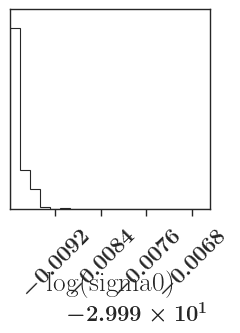

In [315]:
flat_samples = sampler.get_chain(thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=['log(sigma0)'])

In [316]:
np.median(samples)

-29.999907860663512

In [317]:
brentq(funr_new, -500, 300, args=(test_cluster, [-10, -2], -2))

/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/eleanorstuart/opt/anaconda3/envs/idm/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


-7.528205929895033